In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pylab as py
import seaborn as sns
from copy import deepcopy
import warnings
from scipy.stats import pearsonr, f_oneway, ttest_ind, kstest, norm
from sklearn.preprocessing import StandardScaler, MinMaxScaler, TargetEncoder, PolynomialFeatures
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, PrecisionRecallDisplay
from sklearn.metrics import recall_score, precision_score, precision_recall_curve, auc, roc_auc_score, roc_curve, f1_score, RocCurveDisplay
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.impute import KNNImputer
from scipy.stats import pearsonr
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.compat import lzip
import statsmodels.stats.api as sms
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('https://d2beiqkhq929f0.cloudfront.net/public_assets/assets/000/003/549/original/logistic_regression.csv?1651045921')

#### `Making sure that any column with string values have no leading or trailing whitespaces`

In [3]:
for col in df.columns:
    if df[col].dtype == 'str' or df[col].dtype == 'object':
        df[col] = df[col].str.strip()

### `Data dictionary:`

`1. loan_amnt :` The listed amount of the loan applied for by the borrower. If at some point in time, the credit department reduces the loan amount, then it will be reflected in this value.

`2. term :` The number of payments on the loan. Values are in months and can be either 36 or 60.

`3. int_rate :` Interest Rate on the loan.

`4. installment :` The monthly payment owed by the borrower if the loan originates.

`5. grade :` LoanTap assigned loan grade.

`6. sub_grade :` LoanTap assigned loan subgrade

`7. emp_title :` The job title supplied by the Borrower when applying for the loan.

`8. emp_length :` Employment length in years. Possible values are between 0 and 10 where 0 means less than one year and 10 means ten or more years.

`9. home_ownership :` The home ownership status provided by the borrower during registration or obtained from the credit report.

`10. annual_inc :` The self-reported annual income provided by the borrower during registration.

`11. verification_status :` Indicates if income was verified by LoanTap, not verified, or if the income source was verified.

`12. issue_d :` The month which the loan was funded.

`13. loan_status :` Current status of the loan - Target Variable.

`14. purpose :` A category provided by the borrower for the loan request.

`15. title :` The loan title provided by the borrower.

`16. dti :` A ratio calculated using the borrower’s total monthly debt payments on the total debt obligations, excluding mortgage and the requested LoanTap loan, divided by the borrower’s self-reported monthly income.

`17. earliest_cr_line :` The month the borrower's earliest reported credit line was opened.

`18. open_acc :` The number of open credit lines in the borrower's credit file.

`19. pub_rec :` Number of derogatory public records.

`20. revol_bal :` Total credit revolving balance.

`21. revol_util :` Revolving line utilization rate, or the amount of credit the borrower is using relative to all available revolving credit.

`22. total_acc :` The total number of credit lines currently in the borrower's credit file.

`23. initial_list_status :` The initial listing status of the loan. Possible values are – W, F.

`24. application_type :` Indicates whether the loan is an individual application or a joint application with two co-borrowers.

`25. mort_acc :` Number of mortgage accounts.

`26. pub_rec_bankruptcies :` Number of public record bankruptcies.

`27. address:` Address of the individual.

In [4]:
df.head()

,loan_amnt,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,...,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,application_type,mort_acc,pub_rec_bankruptcies,address
0,10000.0,36 months,11.44,329.48,B,B4,Marketing,10+ years,RENT,117000.0,...,16.0,0.0,36369.0,41.8,25.0,w,INDIVIDUAL,0.0,0.0,"0174 Michelle Gateway\r\nMendozaberg, OK 22690"
1,8000.0,36 months,11.99,265.68,B,B5,Credit analyst,4 years,MORTGAGE,65000.0,...,17.0,0.0,20131.0,53.3,27.0,f,INDIVIDUAL,3.0,0.0,"1076 Carney Fort Apt. 347\r\nLoganmouth, SD 05113"
2,15600.0,36 months,10.49,506.97,B,B3,Statistician,< 1 year,RENT,43057.0,...,13.0,0.0,11987.0,92.2,26.0,f,INDIVIDUAL,0.0,0.0,"87025 Mark Dale Apt. 269\r\nNew Sabrina, WV 05113"
3,7200.0,36 months,6.49,220.65,A,A2,Client Advocate,6 years,RENT,54000.0,...,6.0,0.0,5472.0,21.5,13.0,f,INDIVIDUAL,0.0,0.0,"823 Reid Ford\r\nDelacruzside, MA 00813"
4,24375.0,60 months,17.27,609.33,C,C5,Destiny Management Inc.,9 years,MORTGAGE,55000.0,...,13.0,0.0,24584.0,69.8,43.0,f,INDIVIDUAL,1.0,0.0,"679 Luna Roads\r\nGreggshire, VA 11650"


# **`Problem statement:`**

LoanTap is an online platform committed to delivering customized loan products to millennials. They innovate in an otherwise dull loan segment, to deliver instant, flexible loans on consumer friendly terms to salaried professionals and businessmen.

The data science team at LoanTap is building an underwriting layer to determine the creditworthiness of MSMEs as well as individuals.

LoanTap deploys formal credit to salaried individuals and businesses 4 main financial instruments:

1. Personal Loan
2. EMI Free Loan
3. Personal Overdraft
4. Advance Salary Loan
This case study will focus on the underwriting process behind Personal Loan only

#### Basically, we have to identify the metrics which are highly correlated with the target variable i.e loan_status and leverage those features to predict whether a customer's loan request shoud be approved or not for better risk modelling.

#### There are 32995 datapoints (rows) and 27 columns in the data. Out of these 27 columns, 26 are the independent variables (features) and one target variable `"loan_status"`

In [5]:
df.shape

(396030, 27)

In [6]:
df.dtypes

loan_amnt               float64
term                     object
int_rate                float64
installment             float64
grade                    object
sub_grade                object
emp_title                object
emp_length               object
home_ownership           object
annual_inc              float64
verification_status      object
issue_d                  object
loan_status              object
purpose                  object
title                    object
dti                     float64
earliest_cr_line         object
open_acc                float64
pub_rec                 float64
revol_bal               float64
revol_util              float64
total_acc               float64
initial_list_status      object
application_type         object
mort_acc                float64
pub_rec_bankruptcies    float64
address                  object
dtype: object

#### `Data types of the variables:`
1. `loan_amnt` - float64 (Independent variable or feature)
2. `term` - object (Independent variable or feature)
3. `int_rate` - float64 (Independent variable or feature)
4. `installment` - float64 (Independent variable or feature)
5. `grade` - object (Independent variable or feature)
6. `sub_grade` - object (Independent variable or feature)
7. `emp_title` - object (Independent variable or feature)
8. `emp_length` - object (Independent variable or feature)
9. `home_ownership` - object (Independent variable or feature)
10. `annual_inc` - float64 (Independent variable or feature)
11. `verification_status` - object (Independent variable or feature)
12. `issue_d` - object (Independent variable or feature)
13. `loan_status` - object (Target or response variable)
14. `purpose` - object (Independent variable or feature)
15. `title` - object (Independent variable or feature)
16. `dti` - float64 (Independent variable or feature)
17. `earliest_cr_line` - object (Independent variable or feature)
18. `open_acc` - float64 (Independent variable or feature)
19. `pub_rec` - float64 (Independent variable or feature)
20. `revol_bal` - float64 (Independent variable or feature)
21. `revol_util` - float64 (Independent variable or feature)
22. `total_acc` - float64 (Independent variable or feature)
23. `initial_list_status` - object (Independent variable or feature)
24. `application_type` - object (Independent variable or feature)
25. `mort_acc` - float64 (Independent variable or feature)
26. `pub_rec_bankruptcies` - float64 (Independent variable or feature)
27. `address` - object (Independent variable or feature)

Some features like `pub_rec`, `mort_acc`, `pub_rec_bankruptcies` etc. will require some feature engineering

#### `Statistical Summary`
1. `loan_amnt:` Minimum loan_amnt is 500, 25th percentile value is 8000, median loan_amnt is 12000, 75th percentile value is 20000 and maximum loan_amnt is 40000. From these values, it looks like loan_amnt distribution is right-skewed i.e. there are few customers who have very high loan_amnt.
2. `term:` 302005 out of 396030 (~76%) customers are applying for loan with a terms of 36 months.
3. `int_rate:` Minimum int_rate is 5.32%, 25th percentile value is 10.49%, median int_rate is 13.33%, 75th percentile value is 16.49% and maximum int_rate is 30.99%. 
4. `installment:` Minimum installment is 16.08, 25th percentile value is 250.33, median installment is 375.43, 75th percentile value is 567.3 and maximum installment is 1533.81. From these values, it looks like installment distribution is right-skewed i.e. there are few customers who have very high installment.
5. `grade:` 116018 out of 396030 (~30%) customers have grade `B`.
6. `sub_grade:` 26655 out of 396030 (~7%) customers have sub_grade `B3`.
7. `emp_title:` The most frequent `emp_title` is `Teacher` (4507 out of 396030 (~1%))
8. `emp_length:` 126041 out of 396030 (~32%) customers have experience i.e. `emp_length` of 10+ years.
9. `home_ownership:` 198348 out of 396030 (~50%) customers are mortagaged home.
10. `annual_inc:` Minimum annual_inc is 0 (outlier we'll have to deal with later), 25th percentile value is ~45000, median annual_inc is ~64000, 75th percentile value is ~90000 and maximum annual_inc is 8700000. From these values, it looks like annual_inc distribution is right-skewed i.e. there are few customers who have very high annual_inc.
11. `verification_status:` 139563 out of 396030 (~35%) customers are verified.
12. `issue_d:` There are 115 unique values in `issue_d` (will have to process later) out of which the most frequesnt ones (14846) are `Oct-2014`.
13. `loan_status:` 318357 out of 32995 (~80%) customers have fully paid their loan.
14. `purpose:` 234507 out of 32995 (~59%) customers took loan for debt_consolidation.
15. `title:` 152711 out of 32995 (~39%) customers have the loan title Debt consolidation.
16. `dti:` Minimum dti is 0.0 (may be outliers which we'll have to deal with), 25th percentile value is 11.28, median dti is 16.91, 75th percentile value is 22.98 and maximum dti is 9999 (may be outliers which we'll have to deal with). From these values, it looks like dti distribution is right-skewed i.e. there are few customers who have very high dti.
17. `earliest_cr_line:` There are 684 unique values in `earliest_cr_line` (will have to process later) out of which the most frequesnt ones (3017) are `Oct-2000`.
18. `open_acc:` Minimum open_acc is 0.0 , 25th percentile value is 8, median open_acc is 10, 75th percentile value is 14 and maximum open_acc is 90. From these values, it looks like open_acc distribution is right-skewed i.e. there are few customers who have very high number of open_acc.
19. `pub_rec:` Atleast 75% of the customers have 0 pub_rec and the maximum value of the same is 86 which means there are few customers who have high pub_rec i.e. 86.
20. `revol_bal:` Minimum revol_bal is 0.0 , 25th percentile value is 6025, median revol_bal is 11181, 75th percentile value is 19620 and maximum revol_bal is 1743266. From these values, it looks like revol_bal distribution is right-skewed i.e. there are few customers who have very high revol_bal.
21. `revol_util:` Minimum revol_util is 0.0 , 25th percentile value is 35.8, median revol_util is 54.8, 75th percentile value is 72.9 and maximum revol_util is 892.30. From these values, it seems like revol_util distribution is right-skewed i.e. there are few customers who have very high revol_util.
22. `total_acc:` Minimum total_acc is 2, 25th percentile value is 17, median total_acc is 24, 75th percentile value is 32 and maximum total_acc is 151. From these values, it looks like total_acc distribution is right-skewed i.e. there are few customers who have very high number of total_acc.
23. `initial_list_status:` There are 2 unique values in `initial_list_status` out of which the most frequent ones (238066 out of 396030 ~60%) are `f`.
24. `application_type:` There are 3 unique values in `application_type` out of which 395319 out of 396030 (~99.8%) are `INDIVIDUAL`.
25. `mort_acc:` Atleast 25% of the customers have mort_acc = 0, median mort_acc is 1, 75th percentile value is 3 and maximum mort_acc is 34. From these values, it looks like mort_acc distribution is right-skewed i.e. there are few customers who have very high number of mort_acc.
26. `pub_rec_bankruptcies:` Atleast 75% of the customers have 0 pub_rec_bankruptcies and the maximum value of the same is 8 which means there are few customers who have high pub_rec_bankruptcies i.e. 8.
27. `address:` For address, there are 396030 unique values whuch we'll have to process it and we can make some sense out of it.

In [7]:
df.describe(include = 'all')

,loan_amnt,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,...,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,application_type,mort_acc,pub_rec_bankruptcies,address
count,396030.000000,396030,396030.000000,396030.000000,396030,396030,373103,377729,396030,3.960300e+05,...,396030.000000,396030.000000,3.960300e+05,395754.000000,396030.000000,396030,396030,358235.000000,395495.000000,396030
unique,NaN,2,NaN,NaN,7,35,168315,11,6,NaN,...,NaN,NaN,NaN,NaN,NaN,2,3,NaN,NaN,393700
top,NaN,36 months,NaN,NaN,B,B3,Teacher,10+ years,MORTGAGE,NaN,...,NaN,NaN,NaN,NaN,NaN,f,INDIVIDUAL,NaN,NaN,USCGC Smith\r\nFPO AE 70466
freq,NaN,302005,NaN,NaN,116018,26655,4507,126041,198348,NaN,...,NaN,NaN,NaN,NaN,NaN,238066,395319,NaN,NaN,8
mean,14113.888089,NaN,13.639400,431.849698,NaN,NaN,NaN,NaN,NaN,7.420318e+04,...,11.311153,0.178191,1.584454e+04,53.791749,25.414744,NaN,NaN,1.813991,0.121648,NaN
std,8357.441341,NaN,4.472157,250.727790,NaN,NaN,NaN,NaN,NaN,6.163762e+04,...,5.137649,0.530671,2.059184e+04,24.452193,11.886991,NaN,NaN,2.147930,0.356174,NaN
min,500.000000,NaN,5.320000,16.080000,NaN,NaN,NaN,NaN,NaN,0.000000e+00,...,0.000000,0.000000,0.000000e+00,0.000000,2.000000,NaN,NaN,0.000000,0.000000,NaN
25%,8000.000000,NaN,10.490000,250.330000,NaN,NaN,NaN,NaN,NaN,4.500000e+04,...,8.000000,0.000000,6.025000e+03,35.800000,17.000000,NaN,NaN,0.000000,0.000000,NaN
50%,12000.000000,NaN,13.330000,375.430000,NaN,NaN,NaN,NaN,NaN,6.400000e+04,...,10.000000,0.000000,1.118100e+04,54.800000,24.000000,NaN,NaN,1.000000,0.000000,NaN
75%,20000.000000,NaN,16.490000,567.300000,NaN,NaN,NaN,NaN,NaN,9.000000e+04,...,14.000000,0.000000,1.962000e+04,72.900000,32.000000,NaN,NaN,3.000000,0.000000,NaN


## `Missing value detection:`

`emp_title` - 22927 missing values               

`emp_length` - 18301 missing values               

`title` - 1755 missing values                    

`revol_util` - 276 missing values                

`mort_acc` - 37795 missing values               

`pub_rec_bankruptcies` - 535 missing values      

In [8]:
df.isnull().sum()

loan_amnt                   0
term                        0
int_rate                    0
installment                 0
grade                       0
sub_grade                   0
emp_title               22927
emp_length              18301
home_ownership              0
annual_inc                  0
verification_status         0
issue_d                     0
loan_status                 0
purpose                     0
title                    1755
dti                         0
earliest_cr_line            0
open_acc                    0
pub_rec                     0
revol_bal                   0
revol_util                276
total_acc                   0
initial_list_status         0
application_type            0
mort_acc                37795
pub_rec_bankruptcies      535
address                     0
dtype: int64

## `Missing value Treatment:`

#### First we will drop rows where values for either `title` (1755 rows), `revol_util` (276 rows) or `pub_rec_bankruptcies` (535 rows) are missing because of the reason that they constitute a very small proportion (less than 1%) of the total data and we can't just impute by mean or median in for example `pub_rec_bankruptcies` because it can introduce an unfair bias towards some customers. 

In [9]:
df = df[(~df['title'].isnull()) & (~df['revol_util'].isnull()) & (~df['pub_rec_bankruptcies'].isnull())]

In [10]:
df.isnull().sum()

loan_amnt                   0
term                        0
int_rate                    0
installment                 0
grade                       0
sub_grade                   0
emp_title               22668
emp_length              18076
home_ownership              0
annual_inc                  0
verification_status         0
issue_d                     0
loan_status                 0
purpose                     0
title                       0
dti                         0
earliest_cr_line            0
open_acc                    0
pub_rec                     0
revol_bal                   0
revol_util                  0
total_acc                   0
initial_list_status         0
application_type            0
mort_acc                37195
pub_rec_bankruptcies        0
address                     0
dtype: int64

#### Now We can impute `Unknown` for missing values in `emp_title`, and `emp_length` as imputing will mode can misguide.

In [11]:
df.fillna({'emp_title': 'Unknown', 'emp_length': 'Unknown'}, inplace = True)

In [12]:
df.head()

,loan_amnt,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,...,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,application_type,mort_acc,pub_rec_bankruptcies,address
0,10000.0,36 months,11.44,329.48,B,B4,Marketing,10+ years,RENT,117000.0,...,16.0,0.0,36369.0,41.8,25.0,w,INDIVIDUAL,0.0,0.0,"0174 Michelle Gateway\r\nMendozaberg, OK 22690"
1,8000.0,36 months,11.99,265.68,B,B5,Credit analyst,4 years,MORTGAGE,65000.0,...,17.0,0.0,20131.0,53.3,27.0,f,INDIVIDUAL,3.0,0.0,"1076 Carney Fort Apt. 347\r\nLoganmouth, SD 05113"
2,15600.0,36 months,10.49,506.97,B,B3,Statistician,< 1 year,RENT,43057.0,...,13.0,0.0,11987.0,92.2,26.0,f,INDIVIDUAL,0.0,0.0,"87025 Mark Dale Apt. 269\r\nNew Sabrina, WV 05113"
3,7200.0,36 months,6.49,220.65,A,A2,Client Advocate,6 years,RENT,54000.0,...,6.0,0.0,5472.0,21.5,13.0,f,INDIVIDUAL,0.0,0.0,"823 Reid Ford\r\nDelacruzside, MA 00813"
4,24375.0,60 months,17.27,609.33,C,C5,Destiny Management Inc.,9 years,MORTGAGE,55000.0,...,13.0,0.0,24584.0,69.8,43.0,f,INDIVIDUAL,1.0,0.0,"679 Luna Roads\r\nGreggshire, VA 11650"


# **`Univariate Analysis`**

### `1. loan_amnt:` loan_amnt distribution is right-skewed (with many peaks) with outliers on the higher side which suggests that some customers have very high loan_amnt.

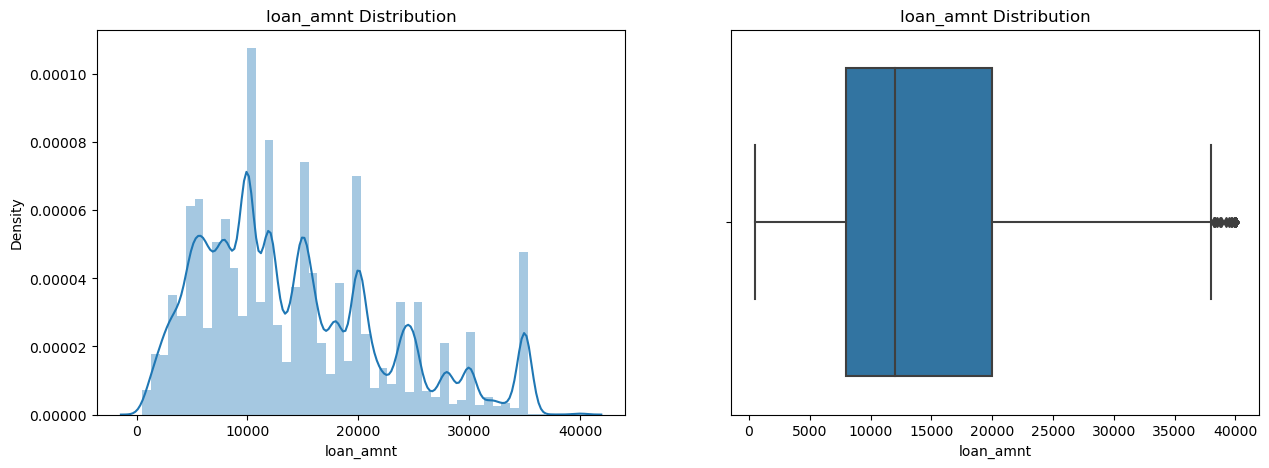

In [13]:
plt.figure(figsize=(15, 5))
plt.subplot(121)
sns.distplot(df['loan_amnt'])
plt.title('loan_amnt Distribution')

plt.subplot(122)
sns.boxplot(df['loan_amnt'])
plt.title('loan_amnt Distribution')
plt.show()

### `2. term:` 76% customers are having a term of 36 months while 24% of them have a term of 60 months.

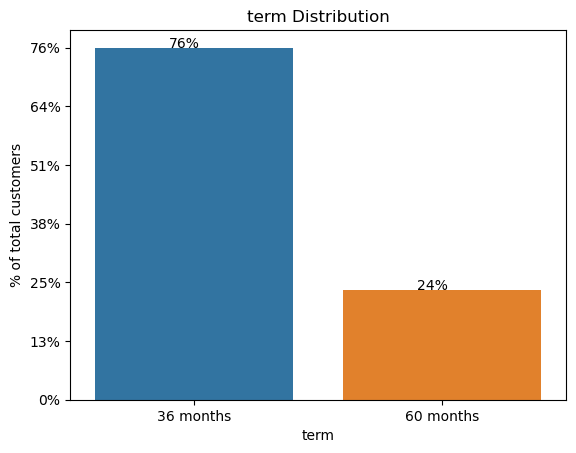

In [14]:
total_size = df.shape[0]
ax = sns.countplot(df['term'])
for p in ax.patches:
    ax.annotate('{:.0f}%'.format(p.get_height() * 100 /total_size), (p.get_x()+0.3, p.get_height()+0.01))
plt.yticks(ticks=range(0, 350000, 50000), labels = [str(round(i * 100 / total_size)) + '%' for i in range(0, 350000, 50000)])

plt.title('term Distribution')
plt.ylabel('% of total customers')
plt.show()

### `3. int_rate:` int_rate distribution looks like a right skewed mix of gaussians (with many peaks) with a median interest rate of 13.33% and outliers on the higher side

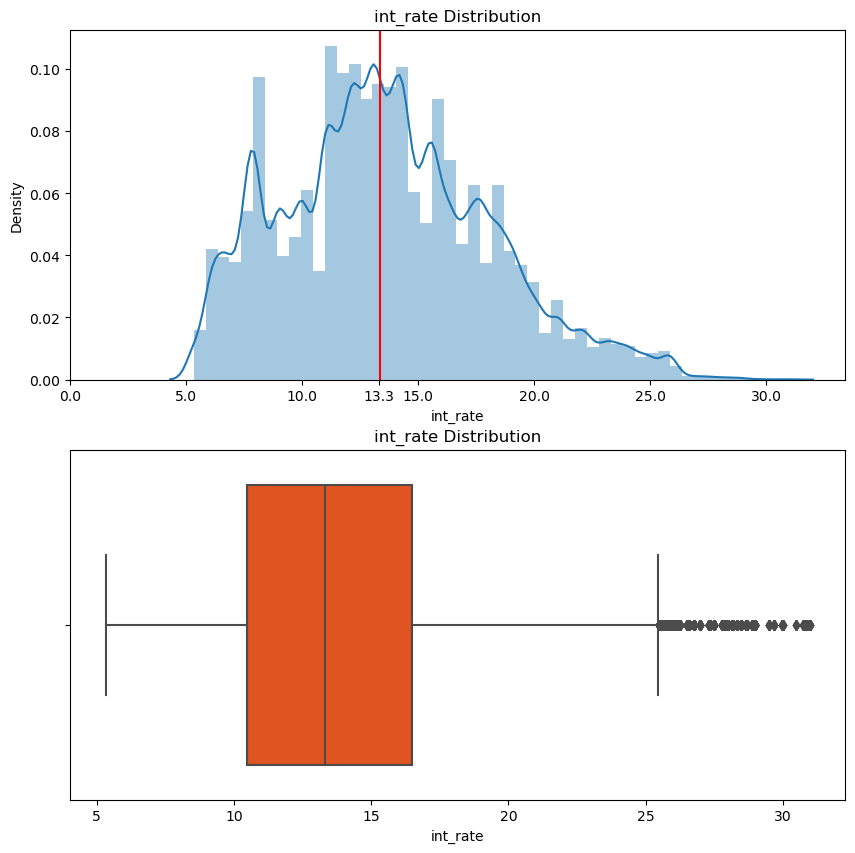

In [15]:
plt.figure(figsize = (10, 10))
plt.subplot(211)
sns.distplot(df['int_rate'])
plt.title('int_rate Distribution')
plt.axvline(df['int_rate'].median(), color = 'red')
plt.xticks(list(range(0, 35, 5)) + [round(df['int_rate'].median(), 1)])

plt.subplot(212)
sns.boxplot(df['int_rate'], color='orangered')
plt.title('int_rate Distribution')
plt.show()

### `4. installment:` Installment distribution is right-skewed (with a median value of 375) which suggests that some customers have very high installment.

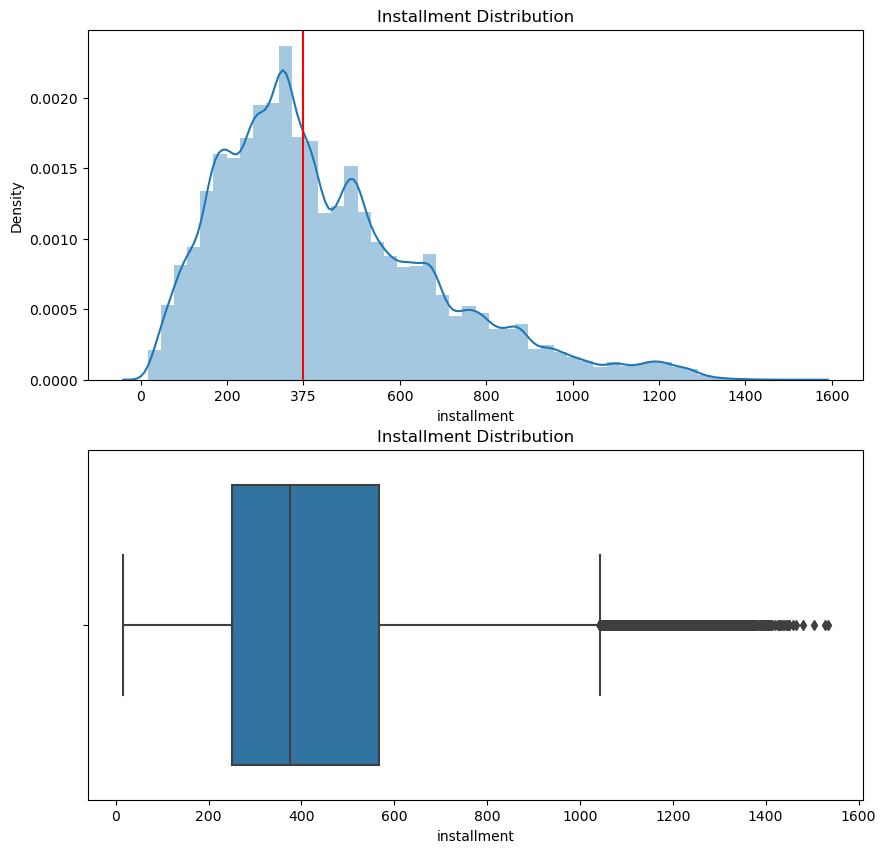

In [16]:
plt.figure(figsize = (10, 10))

plt.subplot(211)
sns.distplot(df['installment'])
plt.axvline(df['installment'].median(), color = 'red')
plt.xticks(list(range(0, 400, 200)) + list(range(600, 1800, 200)) + [df['installment'].median()])
plt.title('Installment Distribution')

plt.subplot(212)
sns.boxplot(df['installment'])
plt.title('Installment Distribution')
plt.show()

### `5. grade:` ~56% of the customers have grade `B` or `C` while customers having grade `F` & `G` combined are very less (only 4%) in proportion.

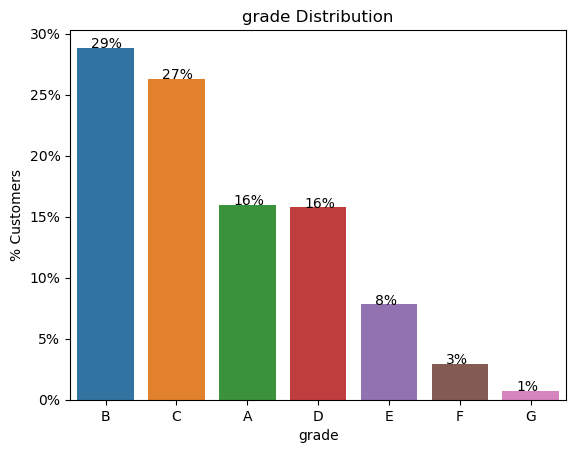

In [17]:
ax = sns.countplot(df['grade'], order = df['grade'].value_counts().index)
for p in ax.patches:
    ax.annotate('{:.0f}%'.format(round(p.get_height() * 100 / total_size)), (p.get_x()+0.2, p.get_height()+0.01))    

plt.yticks(ticks = range(0, 140000, 20000), labels = [str(round(i * 100 / total_size)) + '%' for i in range(0, 140000, 20000)])
plt.title('grade Distribution')
plt.ylabel('% Customers')
plt.show()

### `6. sub_grade:`

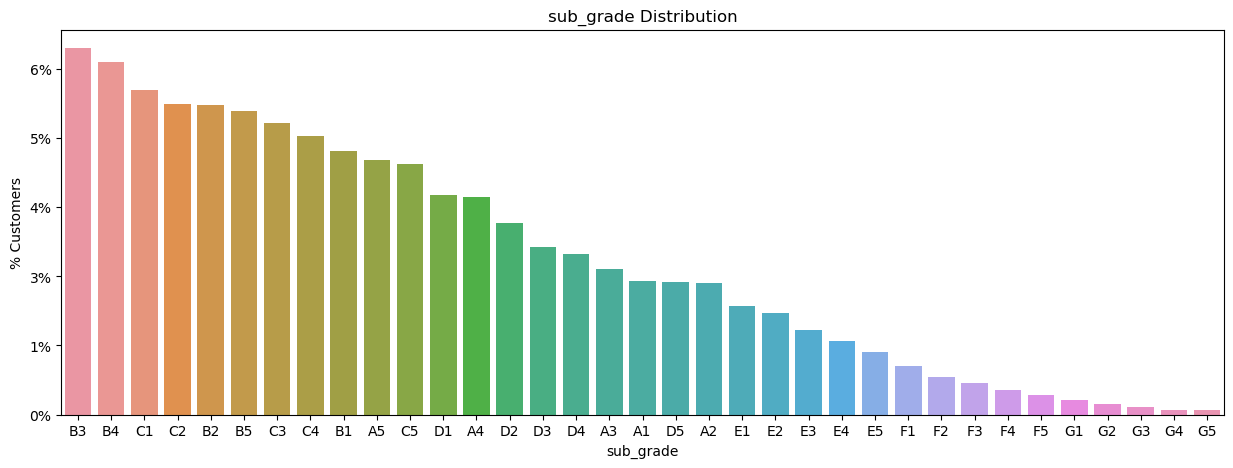

In [18]:
plt.figure(figsize = (15, 5))
ax = sns.countplot(df['sub_grade'], order = df['sub_grade'].value_counts().index)

plt.yticks(ticks = range(0, 30000, 5000), labels = [str(round(i * 100 / total_size)) + '%' for i in range(0, 30000, 5000)])
plt.ylabel('% Customers')
plt.title('sub_grade Distribution')
plt.show()

### `7. emp_title:` There are 167471 unique values in emp_title which is why we'll not be able to plot the distribution properly. So let's plot the distribution of top 10 frequent ones.
#### There are ~6% missing entries i.e. `Unknown` while `Teacher` being the most frequent emp_title

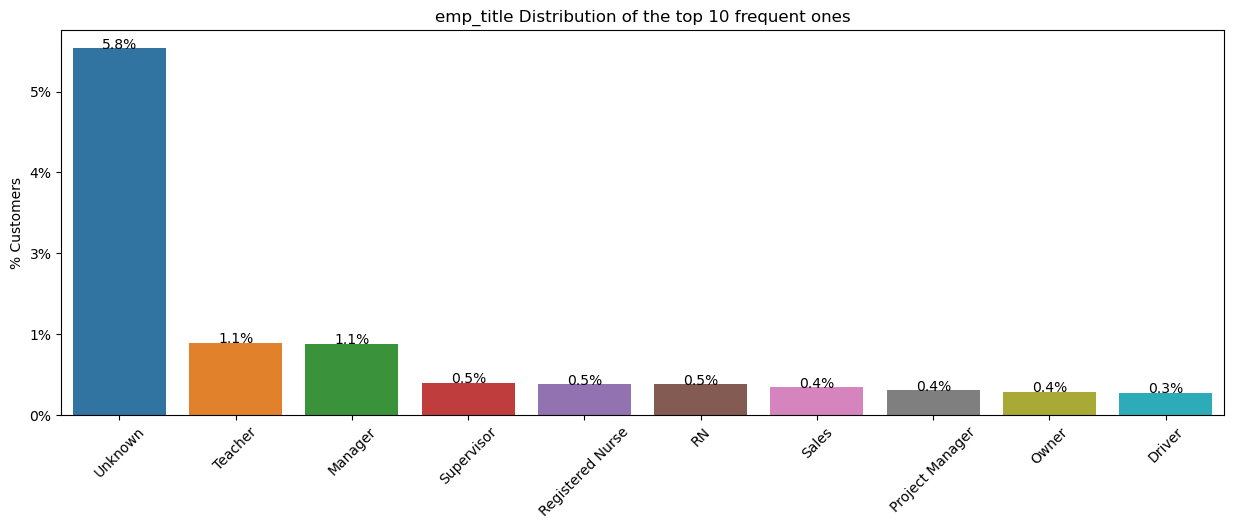

In [19]:
plt.figure(figsize = (15, 5))
ax = sns.barplot(x = df['emp_title'].value_counts()[:10].index, y = df['emp_title'].value_counts()[:10].values)
for p in ax.patches:
    ax.annotate('{:.1f}%'.format(round(p.get_height() * 100 / total_size, 1)), (p.get_x()+0.25, p.get_height()+0.01))
    
plt.yticks(ticks = range(0, 25000, 5000), labels = [str(round(i * 100 / total_size)) + '%' for i in range(0, 25000, 5000)])
plt.ylabel('% Customers')
plt.title('emp_title Distribution of the top 10 frequent ones')
plt.xticks(rotation = 45)
plt.show()

### `8. emp_length:` ~32% of the customers have employment length of 10+ years

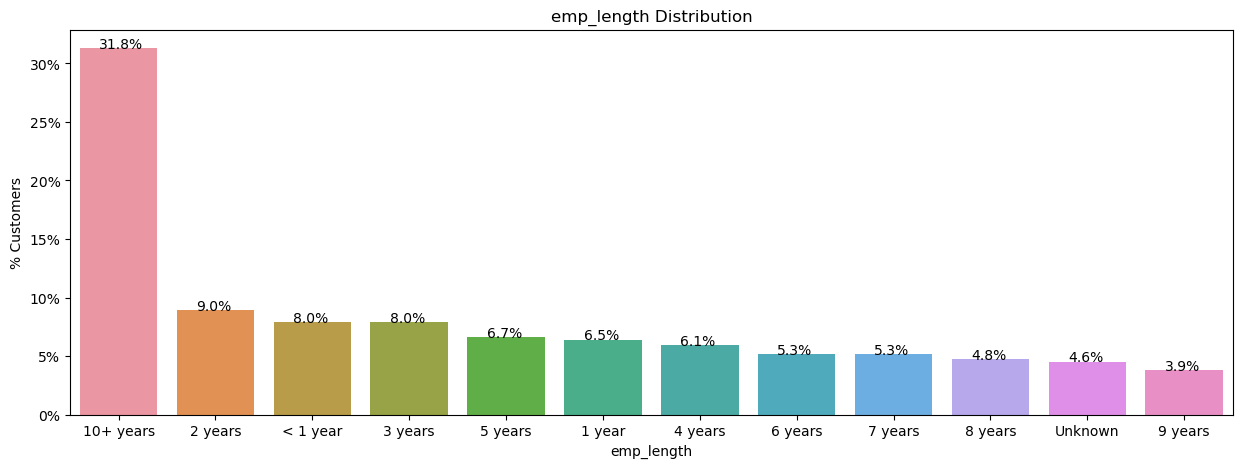

In [20]:
plt.figure(figsize = (15, 5))
ax = sns.countplot(df['emp_length'], order = df['emp_length'].value_counts().index)
for p in ax.patches:
    ax.annotate('{:.1f}%'.format(round(p.get_height() * 100 / total_size, 1)), (p.get_x()+0.2, p.get_height()+0.01))
plt.yticks(ticks = range(0, 140000, 20000), labels = [str(round(i * 100 / total_size)) + '%' for i in range(0, 140000, 20000)])
plt.ylabel('% Customers')
plt.title('emp_length Distribution')
plt.show()

### `9. home_ownership:` ~50% of the customers have mortgaged home, ~40% of the customers have rented home while only ~10% of them have their own home.

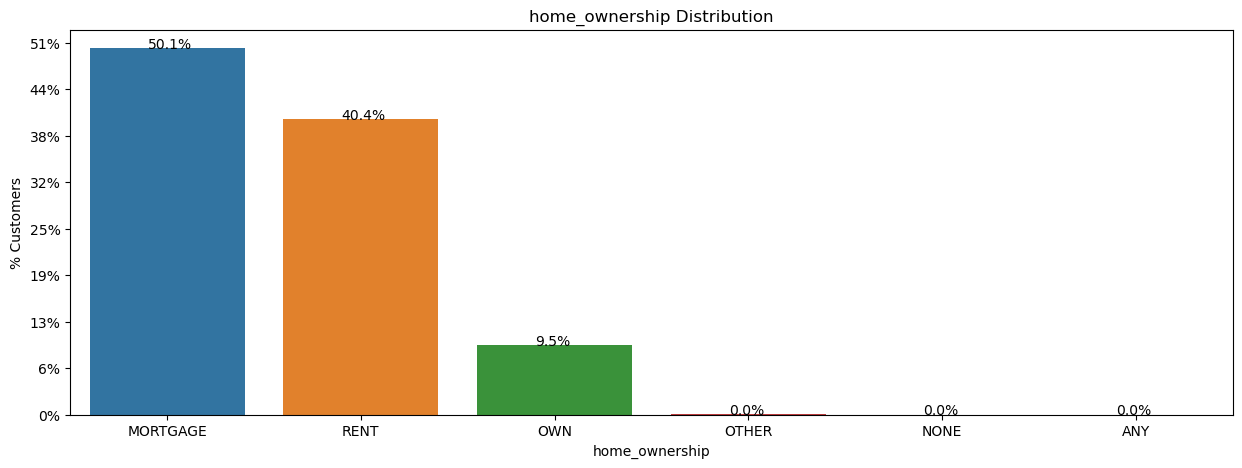

In [21]:
plt.figure(figsize = (15, 5))
ax = sns.countplot(df['home_ownership'], order = df['home_ownership'].value_counts().index)
for p in ax.patches:
    ax.annotate('{:.1f}%'.format(round(p.get_height() * 100 / total_size, 1)), (p.get_x()+0.3, p.get_height()+0.01))

plt.yticks(ticks = range(0, 225000, 25000), labels = [str(round(i * 100 / total_size)) + '%' for i in range(0, 225000, 25000)])
plt.ylabel('% Customers')
plt.title('home_ownership Distribution')
plt.show()

### `10. annual_inc:` As income is very highly right skewed that's why we'll have to plot it on a log-scale.
#### As we can see that after applying log transformation on annual income, distribution looks nearly gaussian which means the `annual_inc` is lognormally distributed which a median value of ~10 ^ 4.8 (= 65000)

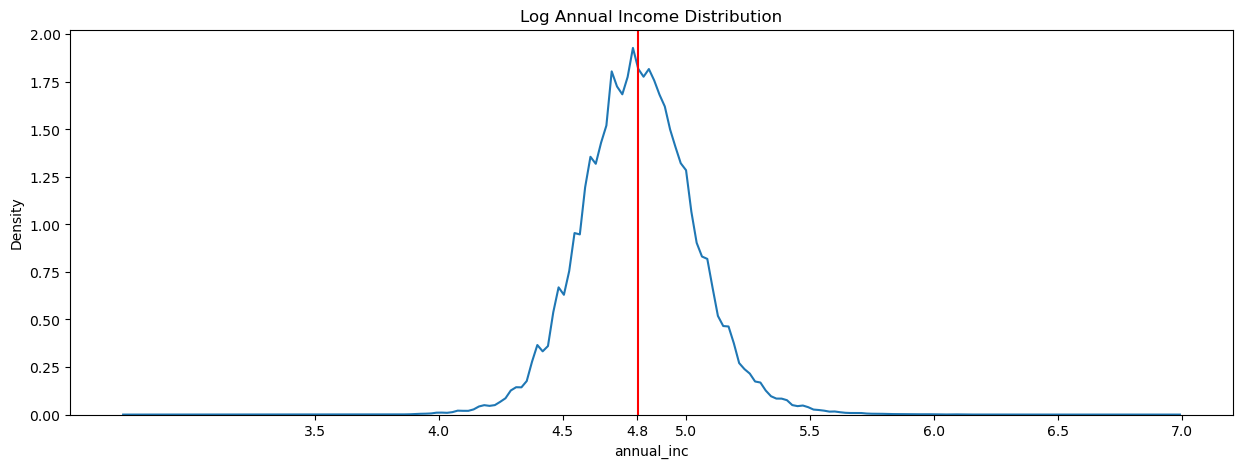

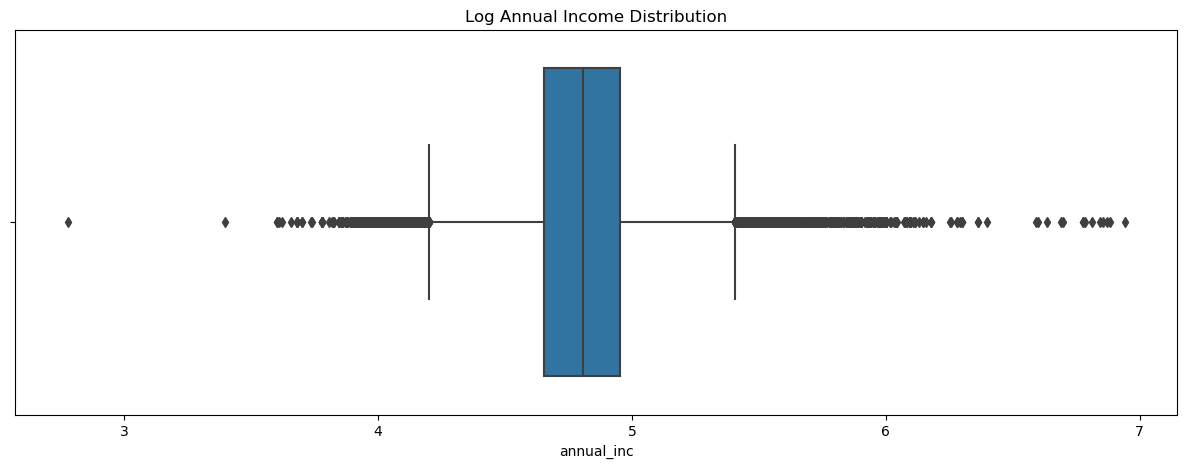

In [22]:
plt.figure(figsize = (15, 5))
sns.kdeplot(np.log10(df['annual_inc']))
plt.axvline(np.log10(df['annual_inc'].median()), color = 'red')
plt.xticks(list(np.arange(3.5, 7.5, 0.5)) + [round(np.log10(df['annual_inc'].median()), 1)])
plt.title('Log Annual Income Distribution')
plt.show()

plt.figure(figsize = (15, 5))
sns.boxplot(np.log10(df['annual_inc']))
plt.title('Log Annual Income Distribution')
plt.show()

### `11. verification_status:` The data is split almost equally between the `Verified`, `Source Verified` & `Not Verified` customers.

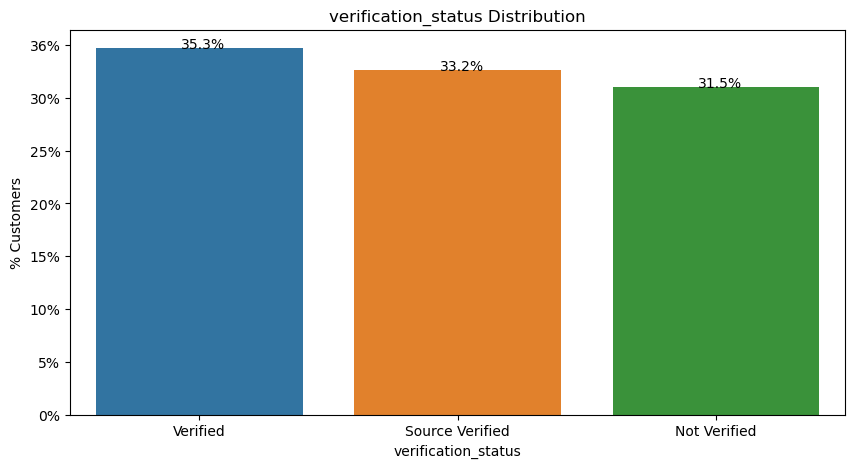

In [23]:
plt.figure(figsize = (10, 5))
ax = sns.countplot(df['verification_status'], order = df['verification_status'].value_counts().index)
for p in ax.patches:
    ax.annotate('{:.1f}%'.format(round(p.get_height() * 100 / total_size, 1)), (p.get_x()+0.33, p.get_height()+0.01))

plt.yticks(ticks = range(0, 160000, 20000), labels = [str(round(i * 100 / total_size)) + '%' for i in range(0, 160000, 20000)])
plt.ylabel('% Customers')
plt.title('verification_status Distribution')
plt.show()

### `12. issue_d:` There are 112 unique values in issue_d which is why we'll not be able to plot the distribution properly. So let's plot the top 10 frequent ones.

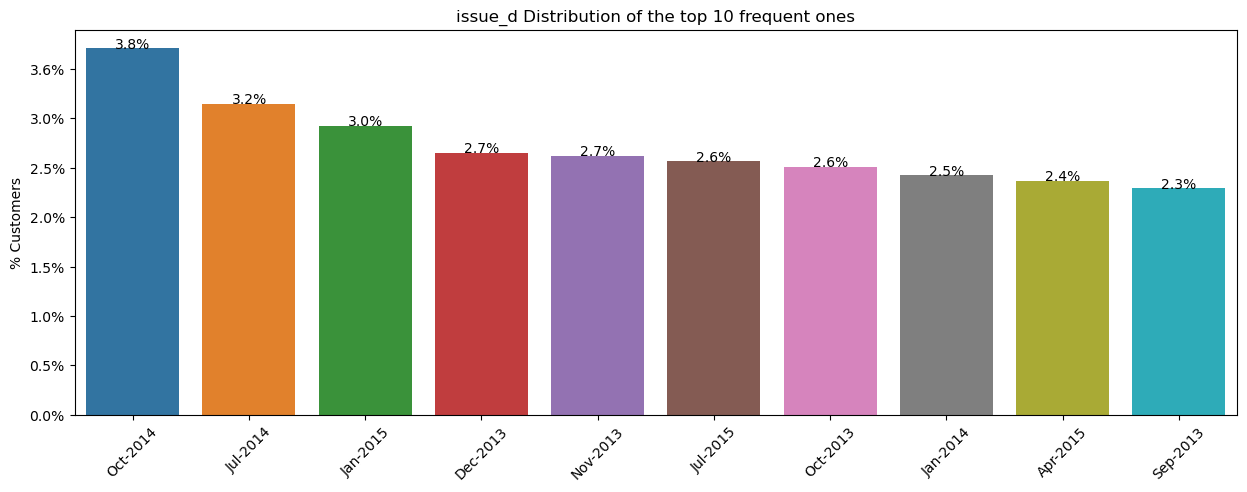

In [24]:
plt.figure(figsize = (15, 5))
ax = sns.barplot(x = df['issue_d'].value_counts()[:10].index, y = df['issue_d'].value_counts()[:10].values)
for p in ax.patches:
    ax.annotate('{:.1f}%'.format(round(p.get_height() * 100 / total_size, 1)), (p.get_x()+0.25, p.get_height()+0.01))
plt.yticks(ticks = range(0, 16000, 2000), labels = [str(round(i * 100 / total_size, 1)) + '%' for i in range(0, 16000, 2000)])
plt.title('issue_d Distribution of the top 10 frequent ones')
plt.xticks(rotation = 45)
plt.ylabel('% Customers')
plt.show()

### `13. loan_status:` 80% of the customers have fully paid thier loan.

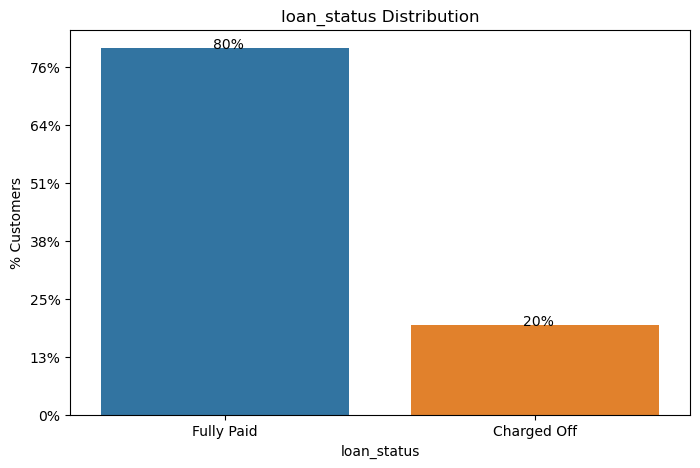

In [25]:
plt.figure(figsize = (8, 5))
ax = sns.countplot(df['loan_status'], order = df['loan_status'].value_counts().index)
for p in ax.patches:
    ax.annotate('{:.0f}%'.format(round(p.get_height() * 100 / total_size)), (p.get_x()+0.36, p.get_height()+0.01))

plt.title('loan_status Distribution')
plt.yticks(ticks = range(0, 350000, 50000), labels = [str(round(i * 100 / total_size)) + '%' for i in range(0, 350000, 50000)])
plt.ylabel('% Customers')
plt.show()

### `14. purpose:` More than 80% of the customers have the purpose of debt consolidation and credit card.

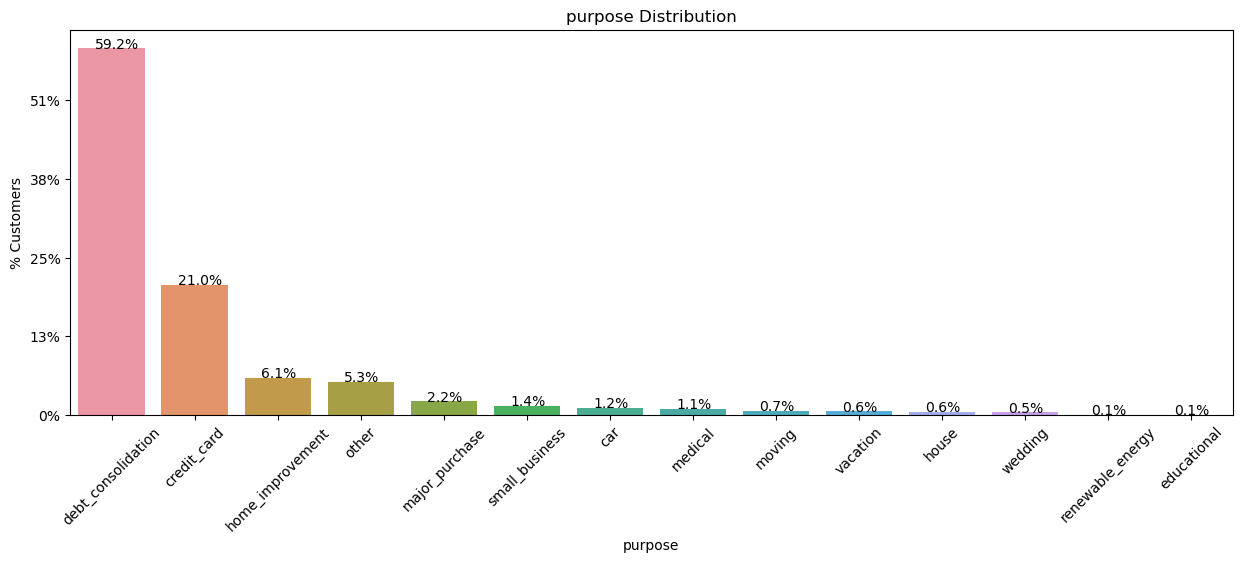

In [26]:
plt.figure(figsize = (15, 5))
ax = sns.countplot(df['purpose'], order = df['purpose'].value_counts().index)
for p in ax.patches:
    ax.annotate('{:.1f}%'.format(round(p.get_height() * 100 / total_size, 1)), (p.get_x()+0.2, p.get_height()+0.01))

plt.yticks(ticks = range(0, 250000, 50000), labels = [str(round(i * 100 / total_size)) + '%' for i in range(0, 250000, 50000)])
plt.ylabel('% Customers')
plt.title('purpose Distribution')
plt.xticks(rotation = 45)
plt.show()

### `15. title:` The data has 47138 unique entries in the `title` column. So we'll not be able to plot it properly. Let's just plot the top 10 frequent ones. As we can see that more than 50% of the people have `Debt Consolidation` & `Credit Card Refinancing` as loan title.

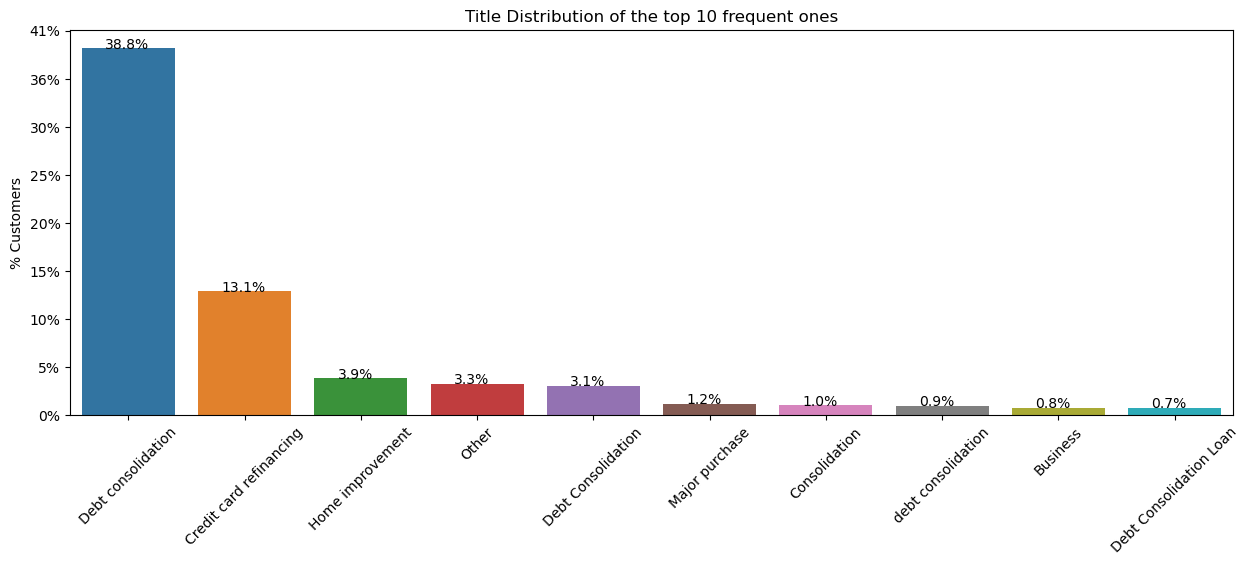

In [27]:
plt.figure(figsize = (15, 5))
ax = sns.barplot(x = df['title'].value_counts()[:10].index, y = df['title'].value_counts()[:10].values)
for p in ax.patches:
    ax.annotate('{:.1f}%'.format(round(p.get_height() * 100 / total_size, 1)), (p.get_x()+0.2, p.get_height()+0.01))
plt.yticks(ticks = range(0, 180000, 20000), labels = [str(round(i * 100 / total_size)) + '%' for i in range(0, 180000, 20000)])
plt.ylabel('% Customers')
plt.title('Title Distribution of the top 10 frequent ones')
plt.xticks(rotation = 45)
plt.show()

### `16. dti:` As dti distribution is extremely right-skewed (with a median value of 16.91) with maximum value of 9999 which seems like outlier, we'll plot the distribution on log scale

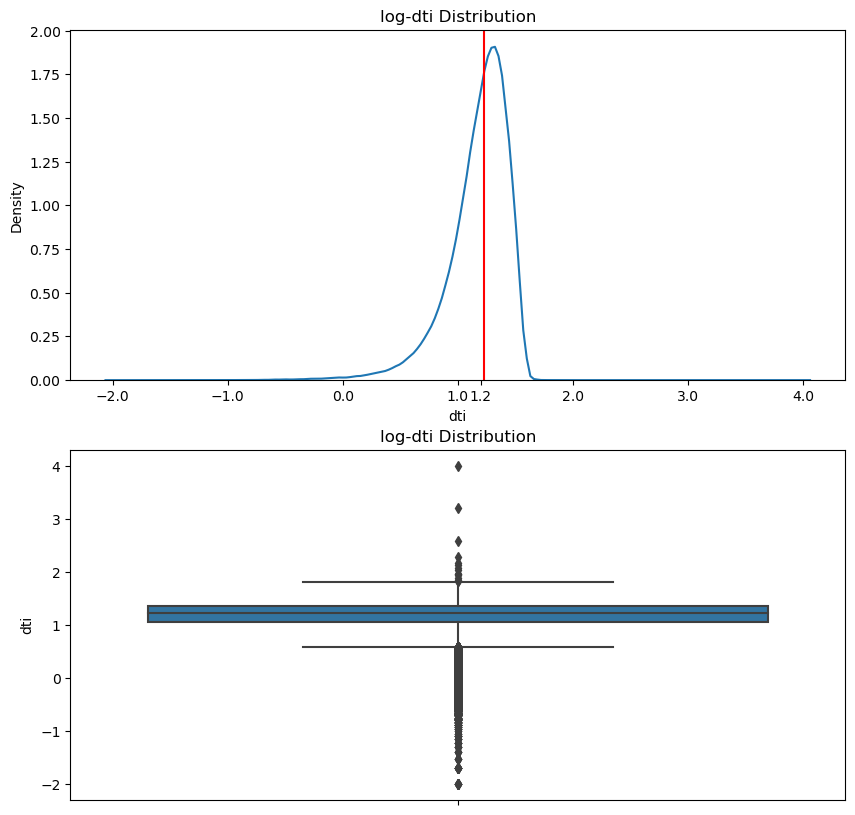

In [28]:
plt.figure(figsize = (10, 10))
plt.subplot(211)
sns.kdeplot(np.log10(df['dti']))
plt.axvline(np.log10(df['dti'].median()), color = 'red')
plt.xticks(list(range(-2, 5)) + [round(np.log10(df['dti'].median()), 1)])
plt.title('log-dti Distribution')

plt.subplot(212)
sns.boxplot(y = np.log10(df['dti']))
plt.title('log-dti Distribution')
plt.show()

### `17. earliest_cr_line:` There are 683 unique values in earliest_cr_line which is why we'll not be able to plot the distribution properly. So let's plot the top 10 frequent ones.

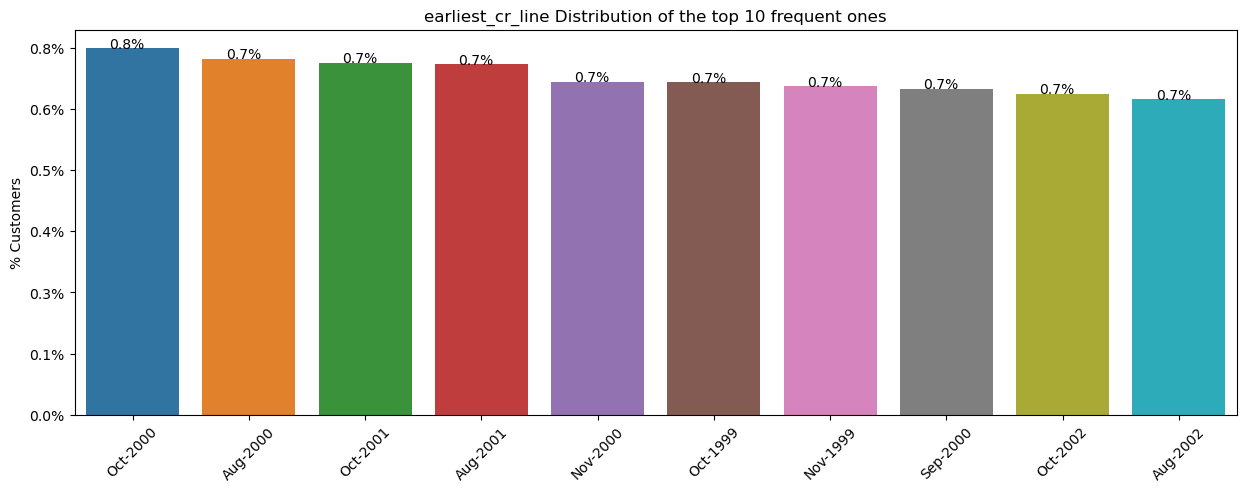

In [29]:
plt.figure(figsize = (15, 5))
ax = sns.barplot(x = df['earliest_cr_line'].value_counts()[:10].index, y = df['earliest_cr_line'].value_counts()[:10].values)
for p in ax.patches:
    ax.annotate('{:.1f}%'.format(round(p.get_height() * 100 / total_size, 1)), (p.get_x()+0.2, p.get_height()+0.01))
plt.yticks(ticks = range(0, 3500, 500), labels = [str(round(i * 100 / total_size, 1)) + '%' for i in range(0, 3500, 500)])
plt.ylabel('% Customers')
plt.title('earliest_cr_line Distribution of the top 10 frequent ones')
plt.xticks(rotation = 45)
plt.show()

### `18. open_acc:` ~50% of the customers have `open_acc` between 7 and 12

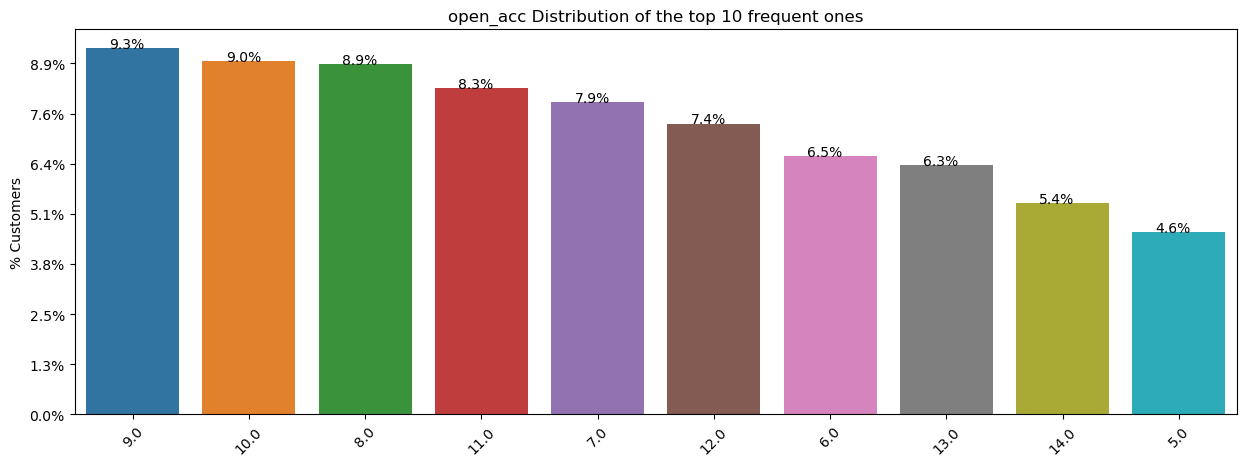

In [30]:
plt.figure(figsize = (15, 5))
ax = sns.barplot(x = df['open_acc'].value_counts().iloc[:10].index, y = df['open_acc'].value_counts().iloc[:10].values,
                 order = df['open_acc'].value_counts().iloc[:10].index)
for p in ax.patches:
    ax.annotate('{:.1f}%'.format(round(p.get_height() * 100 / total_size, 1)), (p.get_x()+0.2, p.get_height()+0.01))
plt.yticks(ticks = range(0, 40000, 5000), labels = [str(round(i * 100 / total_size, 1)) + '%' for i in range(0, 40000, 5000)])
plt.ylabel('% Customers')
plt.title('open_acc Distribution of the top 10 frequent ones')
plt.xticks(rotation = 45)
plt.show()

### `19. pub_rec:` ~85% of the customers have 0 `pub_rec`

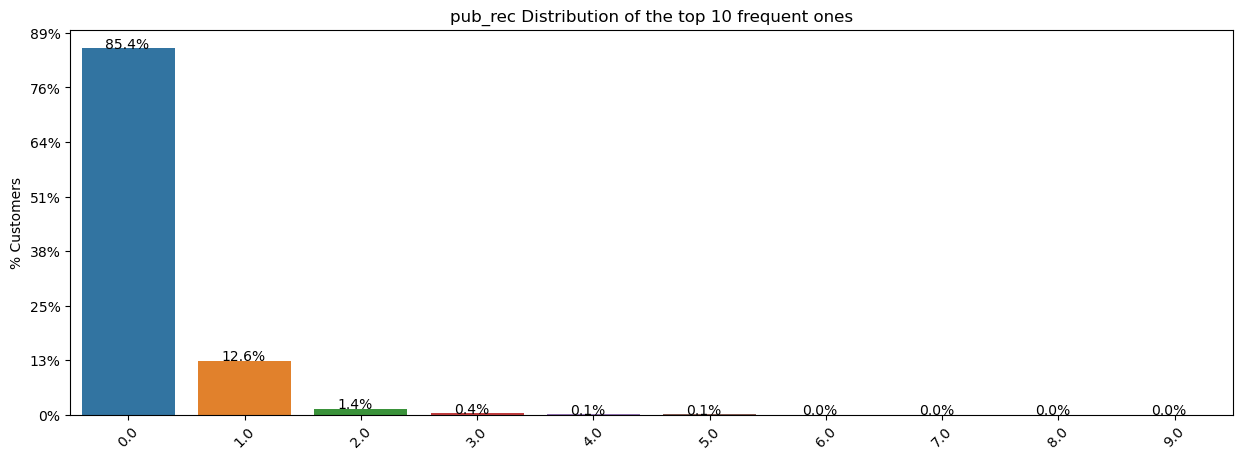

In [31]:
plt.figure(figsize = (15, 5))
ax = sns.barplot(x = df['pub_rec'].value_counts().index, y = df['pub_rec'].value_counts().values,
                 order = df['pub_rec'].value_counts().iloc[:10].index)
for p in ax.patches:
    ax.annotate('{:.1f}%'.format(round(p.get_height() * 100 / total_size, 1)), (p.get_x()+0.2, p.get_height()+0.01))
plt.yticks(ticks = range(0, 400000, 50000), labels = [str(round(i * 100 / total_size)) + '%' for i in range(0, 400000, 50000)])
plt.ylabel('% Customers')
plt.title('pub_rec Distribution of the top 10 frequent ones')
plt.xticks(rotation = 45)
plt.show()

### `20. revol_bal:` As `revol_bal` has a very high range of values (with a median value of 11194) so plotting on log-scale will make much more sense.
#### As we can see the log of revol_bal is looking very close to gaussian (except the few outliers on the left end), which means that revol_bal is lognormally distributed with outliers on the higher side.

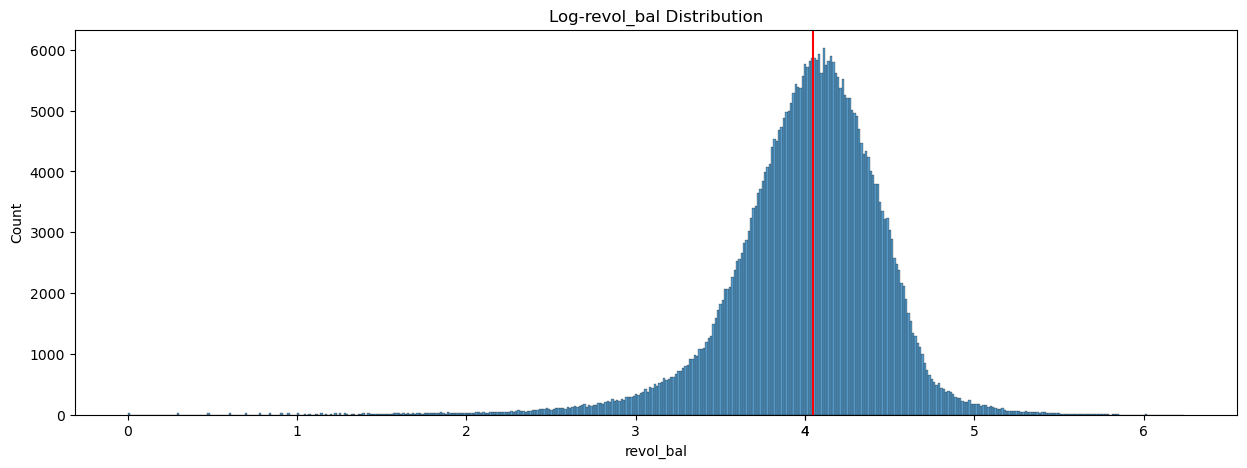

In [32]:
plt.figure(figsize = (15, 5))
sns.histplot(np.log10(df['revol_bal']))
plt.axvline(np.log10(df['revol_bal'].median()), color = 'red')
plt.xticks(list(range(7)) + [round(np.log10(df['revol_bal'].median()), 1)])
plt.title('Log-revol_bal Distribution')
plt.show()

### `21. revol_util:` The distribution of `revol_util` is a little right-skewed with median value of 54.9 and a few outliers on the higher side.

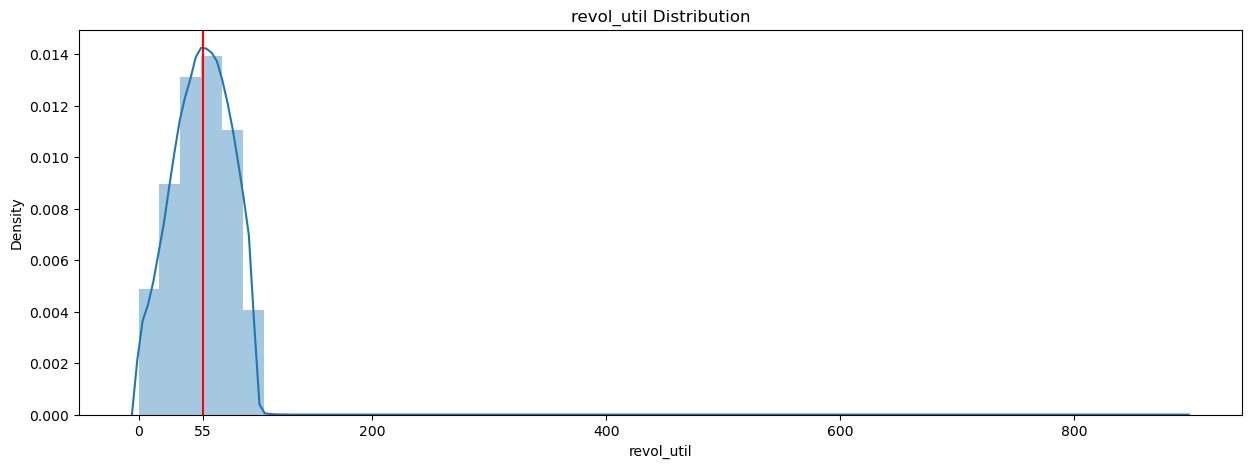

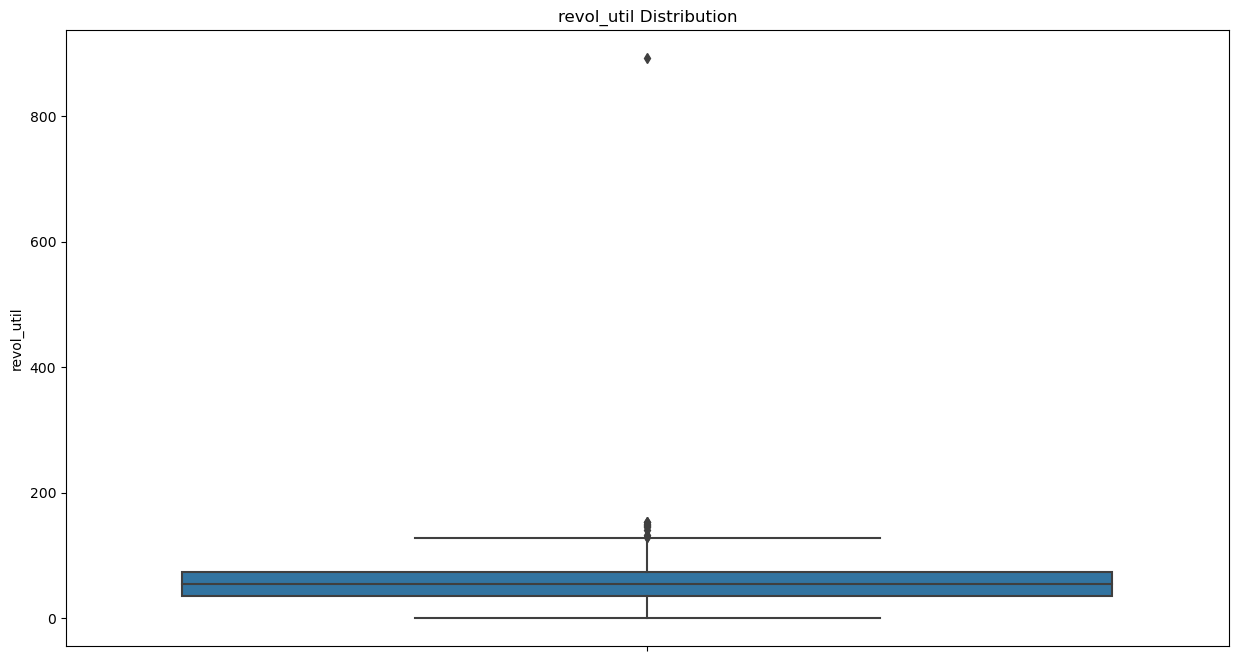

In [33]:
plt.figure(figsize = (15, 5))
sns.distplot(df['revol_util'])
plt.axvline(df['revol_util'].median(), color = 'red')
plt.xticks(list(range(0, 1000, 200)) + [round(df['revol_util'].median())])
plt.title('revol_util Distribution')
plt.show()

plt.figure(figsize = (15, 8))
sns.boxplot(y = df['revol_util'])
plt.title('revol_util Distribution')
plt.show()

### `22. total_acc:` The distribution of `total_acc` is a right skewed with a median value of 24 and outliers on the higher side.

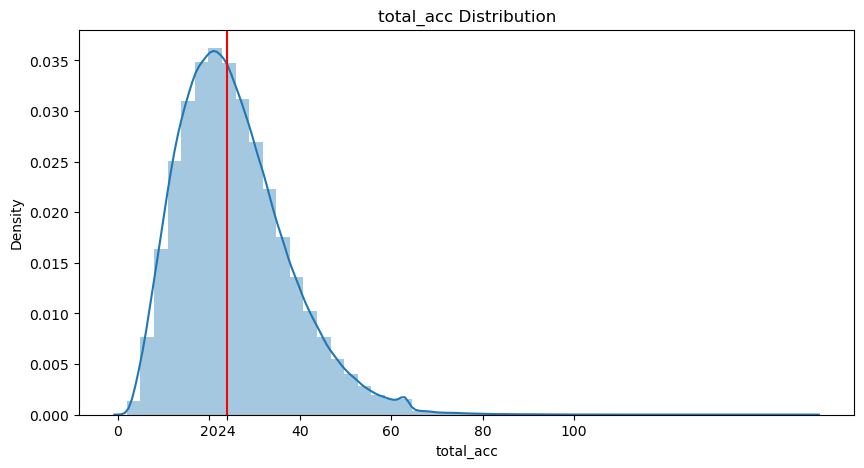

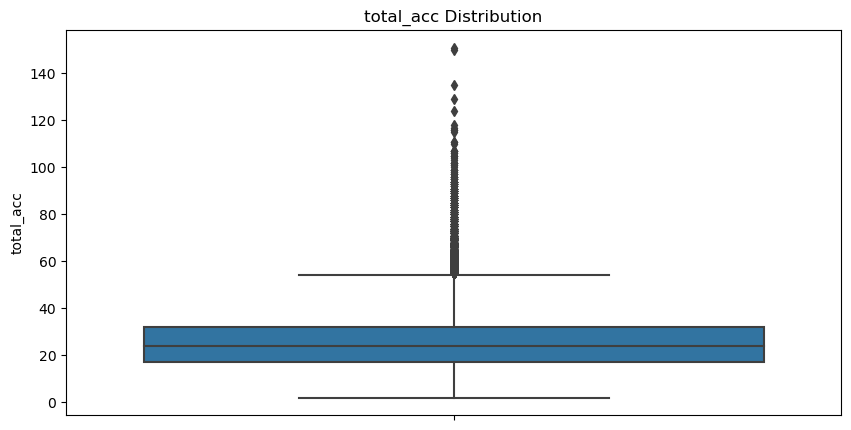

In [34]:
plt.figure(figsize = (10, 5))
sns.distplot(df['total_acc'])
plt.axvline(df['total_acc'].median(), color = 'red')
plt.xticks(list(range(0, 120, 20)) + [round(df['total_acc'].median())])
plt.title('total_acc Distribution')
plt.show()

plt.figure(figsize = (10, 5))
sns.boxplot(y = df['total_acc'])
plt.title('total_acc Distribution')
plt.show()

### `23. initial_list_status:` 60 % of the customers have initial_list_status = 'f' and remaining are 'w'

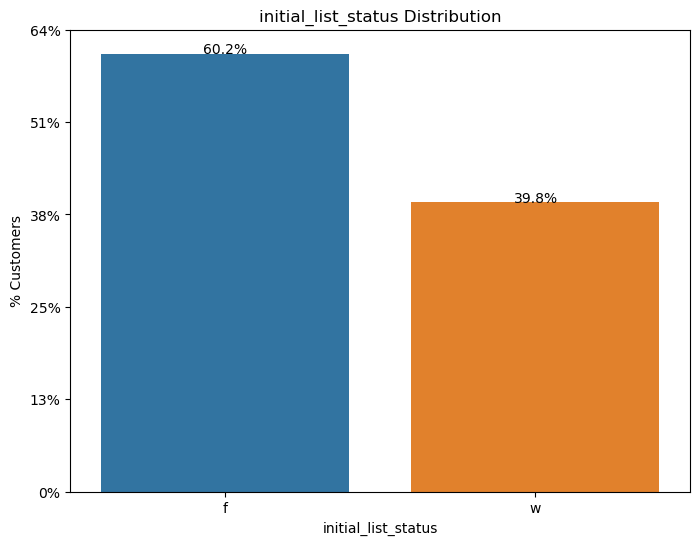

In [35]:
plt.figure(figsize = (8, 6))
ax = sns.countplot(df['initial_list_status'], order = df['initial_list_status'].value_counts().index)
for p in ax.patches:
    ax.annotate('{:.1f}%'.format(round(p.get_height() * 100 / total_size, 1)), (p.get_x()+0.33, p.get_height()+0.01))
plt.yticks(ticks = range(0, 300000, 50000), labels = [str(round(i * 100 / total_size)) + '%' for i in range(0, 300000, 50000)])
plt.ylabel('% Customers')
plt.title('initial_list_status Distribution')
plt.show()

### `24. application_type:` More than 99% of the customers have application_type = INDIVIDUAL.

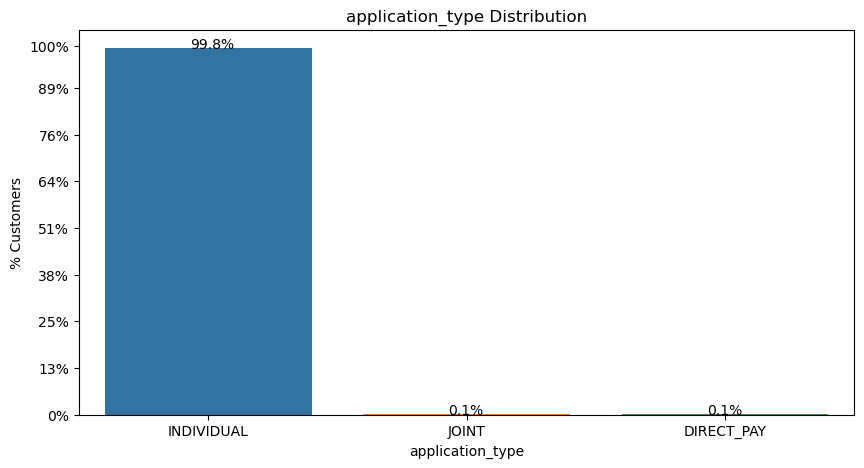

In [36]:
plt.figure(figsize = (10, 5))
ax = sns.countplot(df['application_type'], order = df['application_type'].value_counts().index)
for p in ax.patches:
    ax.annotate('{:.1f}%'.format(round(p.get_height() * 100 / total_size, 1)), (p.get_x()+0.33, p.get_height()+0.01))
plt.yticks(ticks = list(range(0, 400000, 50000)) + [395000],
           labels = [str(round(i * 100 / total_size)) + '%' for i in range(0, 400000, 50000)] + [str(round(395000 * 100 / total_size)) + '%'])
plt.ylabel('% Customers')
plt.title('application_type Distribution')
plt.show()

### `25. mort_acc:` More than 33% of the customers have mort_acc = 0

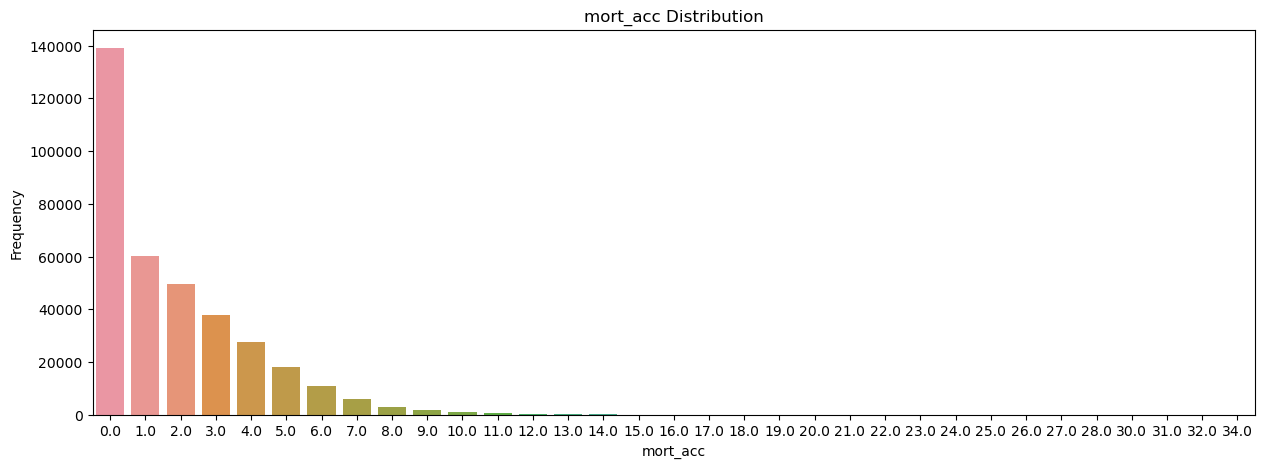

In [37]:
plt.figure(figsize = (15, 5))
ax = sns.countplot(df['mort_acc'])
plt.title('mort_acc Distribution')
plt.ylabel('Frequency')
plt.show()

### `26. pub_rec_bankruptcies:` ~89% of the customers have pub_rec_bankruptcies = 0

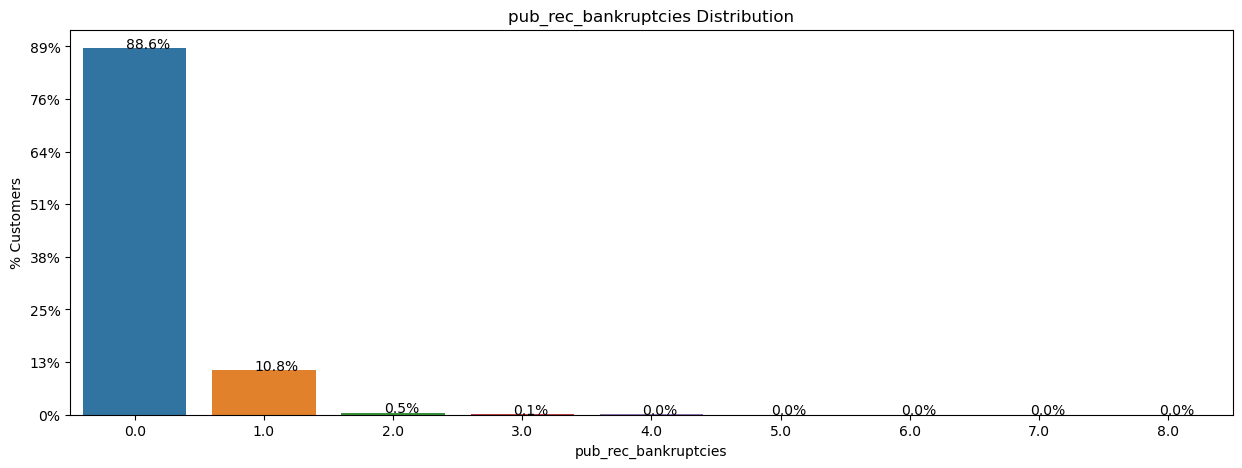

In [38]:
plt.figure(figsize = (15, 5))
ax = sns.countplot(df['pub_rec_bankruptcies'])
for p in ax.patches:
    ax.annotate('{:.1f}%'.format(round(p.get_height() * 100 / total_size, 1)), (p.get_x()+0.33, p.get_height()+0.01))
plt.yticks(ticks = range(0, 400000, 50000), labels = [str(round(i * 100 / total_size)) + '%' for i in range(0, 400000, 50000)])
plt.ylabel('% Customers')
plt.title('pub_rec_bankruptcies Distribution')
plt.show()

***

# **`Bivariate Analysis`**

### `1. loan_status vs loan_amnt:`

In [39]:
loan_approve_pct_vs_loan_amnt = df[['loan_amnt', 'loan_status']].copy()
loan_approve_pct_vs_loan_amnt['loan_amnt'] = loan_approve_pct_vs_loan_amnt['loan_amnt'].apply(lambda x: '<5000' if x < 5000
                                                                                              else '5000-10000' if 5000 <= x < 10000
                                                                                              else '10000-15000' if 10000 <= x < 15000
                                                                                              else '15000-20000' if 15000 <= x < 20000
                                                                                              else '20000-25000' if 20000 <= x < 25000
                                                                                              else '25000-30000' if 25000 <= x < 30000
                                                                                              else '30000-35000' if 30000 <= x < 35000
                                                                                              else '35000-40000')

In [40]:
def fully_paid_pct(x):
    if x.isin([0, 1]).all():
        return round(x.sum()/x.count(), 3) * 100
    else:
        return round((x == 'Fully Paid').sum()/len(x), 3) * 100

In [41]:
loan_approve_pct_vs_loan_amnt = (loan_approve_pct_vs_loan_amnt.groupby('loan_amnt').agg({'loan_status': fully_paid_pct})
                                 .reset_index().rename(columns = {'loan_status': 'loan_fully_paid_pct'}))

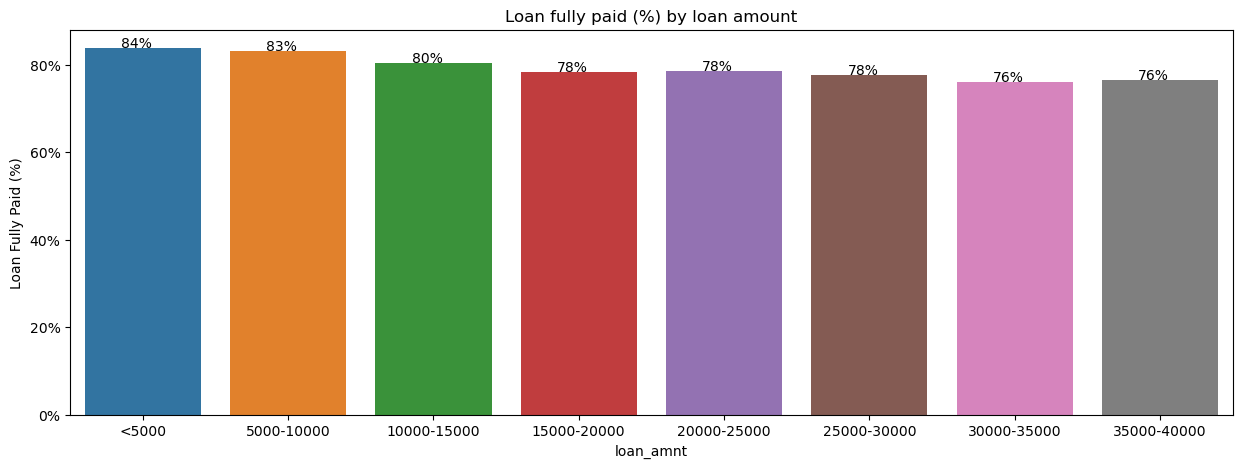

In [42]:
plt.figure(figsize = (15, 5))
ax = sns.barplot(x = loan_approve_pct_vs_loan_amnt['loan_amnt'], y = loan_approve_pct_vs_loan_amnt['loan_fully_paid_pct'],
                 order = ['<5000', '5000-10000', '10000-15000', '15000-20000', '20000-25000', '25000-30000', '30000-35000', '35000-40000'])
for p in ax.patches:
    ax.annotate('{:.0f}%'.format(p.get_height()), (p.get_x()+0.25, p.get_height()+0.1))
plt.title('Loan fully paid (%) by loan amount')
plt.ylabel('Loan Fully Paid (%)')
plt.yticks(ticks = range(0, 100, 20), labels = [f'{i}%' for i in range(0, 100, 20)])
plt.show()

### `2. loan_status vs term:` Loans with 36 months term tend to higher chances of loan fully paid as compared to 60 months of term.

In [43]:
loan_approve_pct_vs_term = (df.groupby('term').agg({'loan_status': fully_paid_pct})
                                 .reset_index().rename(columns = {'loan_status': 'loan_fully_paid_pct'}))

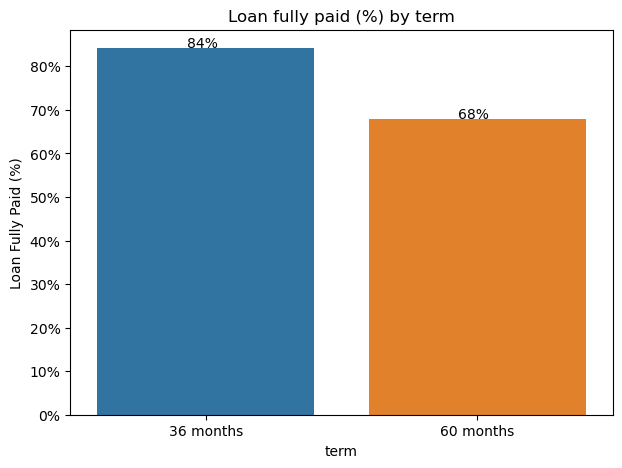

In [44]:
plt.figure(figsize = (7, 5))
ax = sns.barplot(x = loan_approve_pct_vs_term['term'], y = loan_approve_pct_vs_term['loan_fully_paid_pct'])
for p in ax.patches:
    ax.annotate('{:.0f}%'.format(p.get_height()), (p.get_x()+0.33, p.get_height()+0.1))
plt.title('Loan fully paid (%) by term')
plt.ylabel('Loan Fully Paid (%)')
plt.yticks(ticks = range(0, 90, 10), labels = [f'{i}%' for i in range(0, 90, 10)])
plt.show()

### `3. loan_status vs int_rate:` As the interest rate tends to increase, the chances of loan fully paid tends to decrease.

In [45]:
loan_approve_pct_vs_int_rate = df[['int_rate', 'loan_status']].copy()
loan_approve_pct_vs_int_rate['int_rate'] = loan_approve_pct_vs_int_rate['int_rate'].apply(lambda x: '5-10' if 5 <= x < 10
                                                                                              else '10-15' if 10 <= x < 15
                                                                                              else '15-20' if 15 <= x < 20
                                                                                              else '20-25' if 20 <= x < 25
                                                                                              else '25-31')

In [46]:
loan_approve_pct_vs_int_rate = (loan_approve_pct_vs_int_rate.groupby('int_rate').agg({'loan_status': fully_paid_pct})
                                 .reset_index().rename(columns = {'loan_status': 'loan_fully_paid_pct'}))

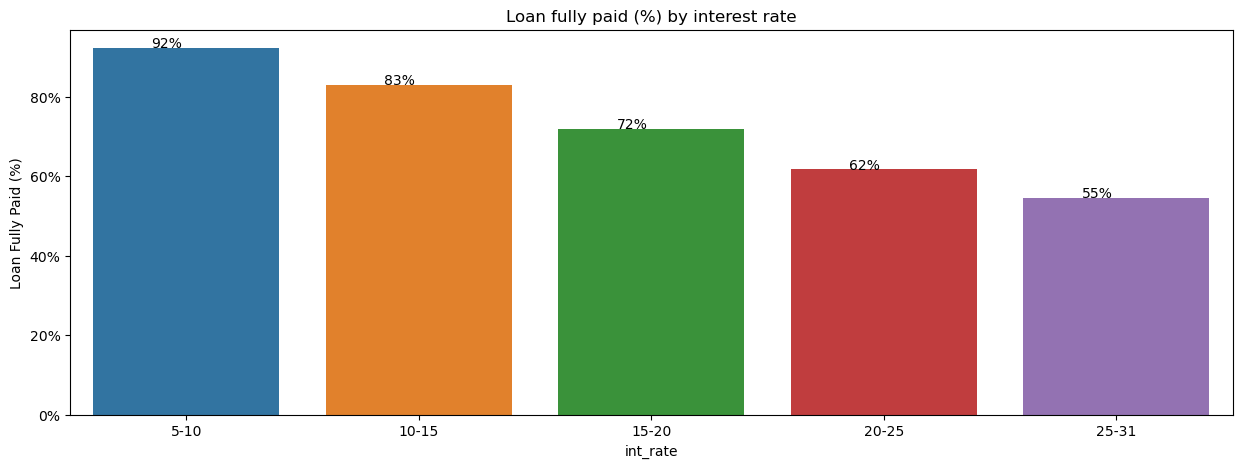

In [47]:
plt.figure(figsize = (15, 5))
ax = sns.barplot(x = loan_approve_pct_vs_int_rate['int_rate'], y = loan_approve_pct_vs_int_rate['loan_fully_paid_pct'],
                order = ['5-10', '10-15', '15-20', '20-25', '25-31'])
for p in ax.patches:
    ax.annotate('{:.0f}%'.format(p.get_height()), (p.get_x()+0.25, p.get_height()+0.1))
plt.title('Loan fully paid (%) by interest rate')
plt.yticks(ticks = range(0, 90, 20), labels = [f'{i}%' for i in range(0, 90, 20)])
plt.ylabel('Loan Fully Paid (%)')
plt.show()

### `4. loan_status vs installment:` The rate of loan fully paid seems to be similar across all the installment ranges

In [48]:
loan_approve_pct_vs_installment = df[['installment', 'loan_status']].copy()
loan_approve_pct_vs_installment['installment'] = loan_approve_pct_vs_installment['installment'].apply(lambda x: '<250' if x < 250
                                                                                              else '250-500' if 250 <= x < 500
                                                                                              else '500-750' if 500 <= x < 750
                                                                                              else '750-1000' if 750 <= x < 1000
                                                                                              else '1000-1600')

In [49]:
loan_approve_pct_vs_installment = (loan_approve_pct_vs_installment.groupby('installment').agg({'loan_status': fully_paid_pct})
                                 .reset_index().rename(columns = {'loan_status': 'loan_fully_paid_pct'}))

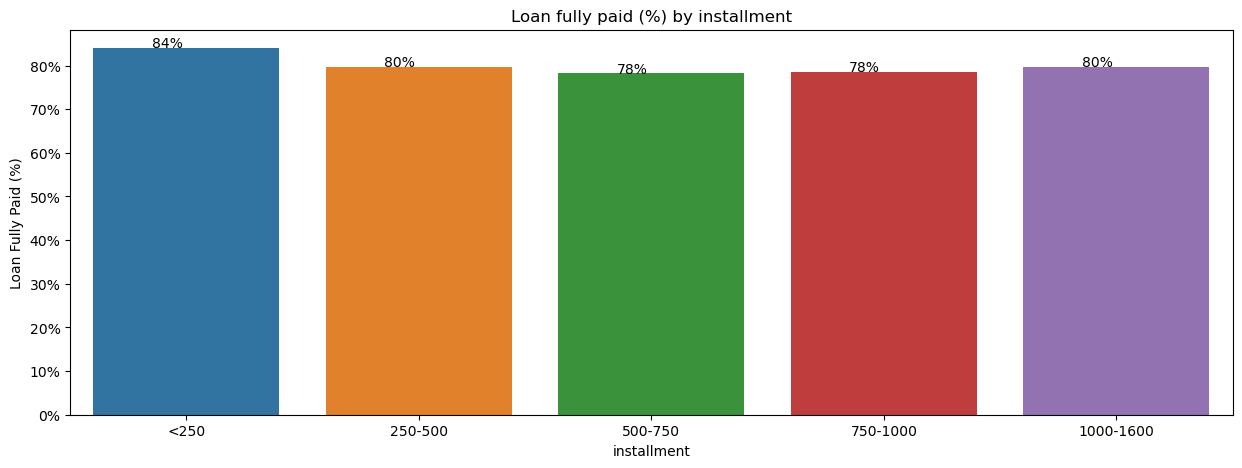

In [50]:
plt.figure(figsize = (15, 5))
ax = sns.barplot(x = loan_approve_pct_vs_installment['installment'], y = loan_approve_pct_vs_installment['loan_fully_paid_pct'],
                order = ['<250', '250-500', '500-750', '750-1000', '1000-1600'])
for p in ax.patches:
    ax.annotate('{:.0f}%'.format(p.get_height()), (p.get_x()+0.25, p.get_height()+0.1))
plt.title('Loan fully paid (%) by installment')
plt.yticks(ticks = range(0, 90, 10), labels = [f'{i}%' for i in range(0, 90, 10)])
plt.ylabel('Loan Fully Paid (%)')
plt.show()

### `5. loan_status vs grade:` As the grade decreases, the chances of loan fully paid also decreases.

In [51]:
loan_approve_pct_vs_grade = (df.groupby('grade').agg({'loan_status': fully_paid_pct})
                                 .reset_index().rename(columns = {'loan_status': 'loan_fully_paid_pct'}))

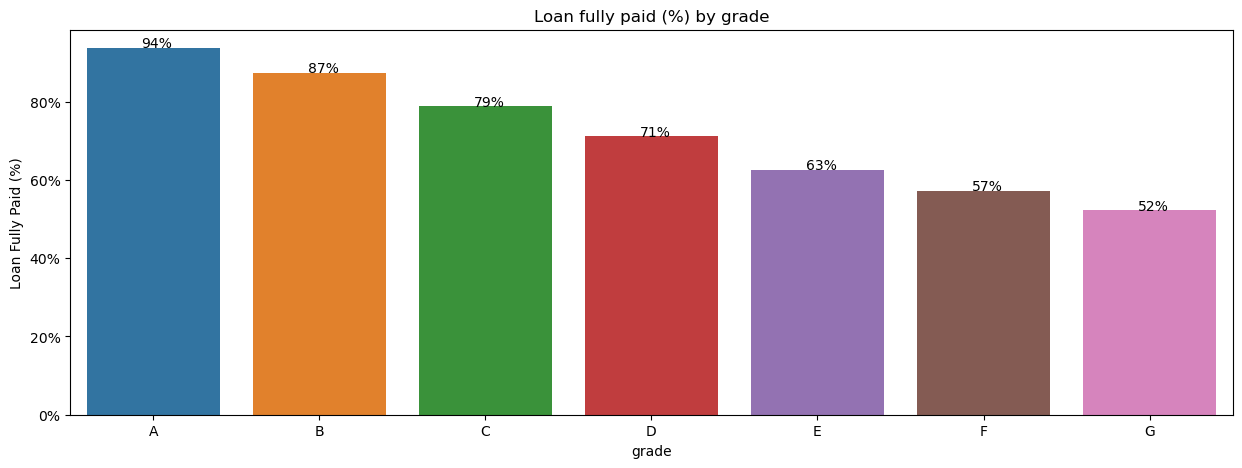

In [52]:
plt.figure(figsize = (15, 5))
ax = sns.barplot(x = loan_approve_pct_vs_grade['grade'], y = loan_approve_pct_vs_grade['loan_fully_paid_pct'])
for p in ax.patches:
    ax.annotate('{:.0f}%'.format(p.get_height()), (p.get_x()+0.33, p.get_height()+0.1))
plt.title('Loan fully paid (%) by grade')
plt.yticks(ticks = range(0, 90, 20), labels = [f'{i}%' for i in range(0, 90, 20)])
plt.ylabel('Loan Fully Paid (%)')
plt.show()

### `6. loan_status vs sub_grade:` As the sub_grade decreases, the chances of loan fully paid also decreases.

In [53]:
loan_approve_pct_vs_sub_grade = (df.groupby('sub_grade').agg({'loan_status': fully_paid_pct})
                                 .reset_index().rename(columns = {'loan_status': 'loan_fully_paid_pct'}))

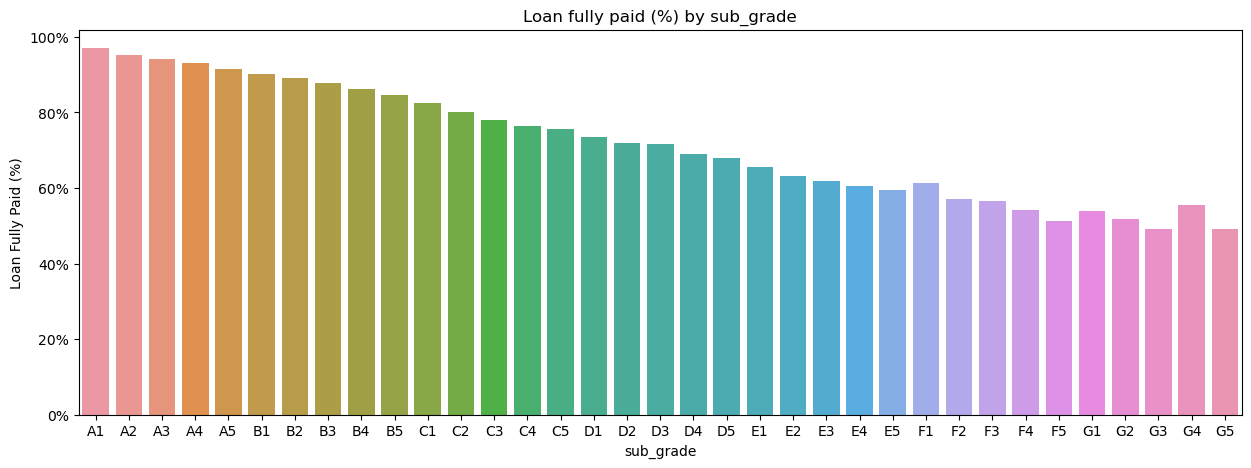

In [54]:
plt.figure(figsize = (15, 5))
ax = sns.barplot(x = loan_approve_pct_vs_sub_grade['sub_grade'], y = loan_approve_pct_vs_sub_grade['loan_fully_paid_pct'])
plt.title('Loan fully paid (%) by sub_grade')
plt.yticks(ticks = range(0, 120, 20), labels = [f'{i}%' for i in range(0, 120, 20)])
plt.ylabel('Loan Fully Paid (%)')
plt.show()

### `7. loan_status vs emp_title:` As there are 167471 unique values in `emp_title`, that's why we can't plot the correlation between `loan_status` & `emp_title`

### `8. loan_status vs emp_length:` The rate of loan fully paid seems to be similar across all the emp_length ranges except when the emp_length is missing where it is lowest i.e. 72%.

In [55]:
loan_approve_pct_vs_emp_length = (df.groupby('emp_length').agg({'loan_status': fully_paid_pct})
                                 .reset_index().rename(columns = {'loan_status': 'loan_fully_paid_pct'}))

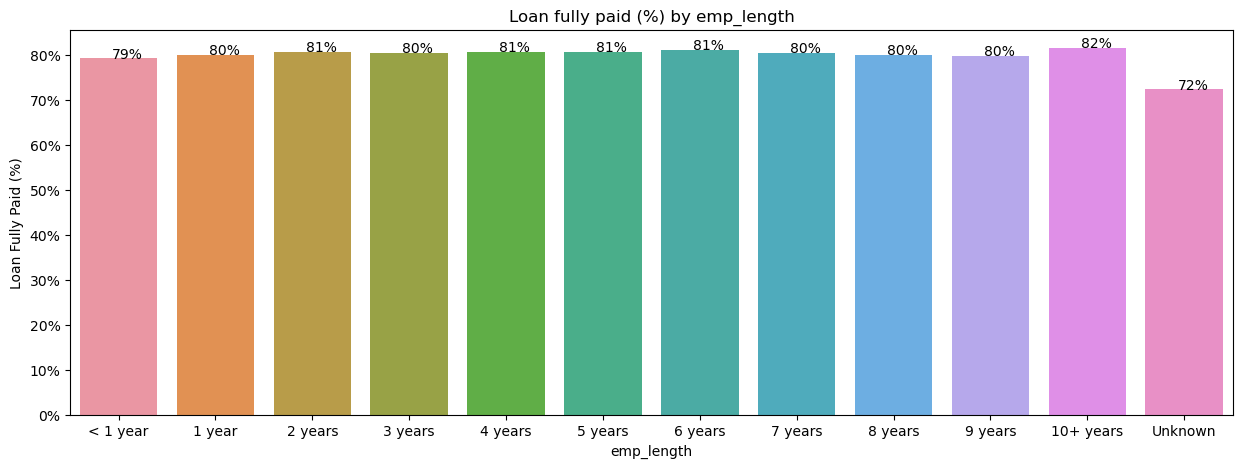

In [56]:
plt.figure(figsize = (15, 5))
ax = sns.barplot(x = loan_approve_pct_vs_emp_length['emp_length'], y = loan_approve_pct_vs_emp_length['loan_fully_paid_pct'],
                order = ['< 1 year', '1 year', '2 years', '3 years', '4 years', '5 years', '6 years', '7 years', '8 years', '9 years', '10+ years', 'Unknown'])
for p in ax.patches:
    ax.annotate('{:.0f}%'.format(p.get_height()), (p.get_x()+0.33, p.get_height()+0.1))
plt.title('Loan fully paid (%) by emp_length')
plt.yticks(ticks = range(0, 90, 10), labels = [f'{i}%' for i in range(0, 90, 10)])
plt.ylabel('Loan Fully Paid (%)')
plt.show()

### `9. loan_status vs home_ownership:`

In [57]:
loan_approve_pct_vs_home_ownership = (df.groupby('home_ownership').agg({'loan_status': [fully_paid_pct, 'count']})
                                 .reset_index().rename(columns = {'loan_status': 'loan_fully_paid_pct'}))
loan_approve_pct_vs_home_ownership.columns = ['home_ownership', 'loan_fully_paid_pct', 'sample size']

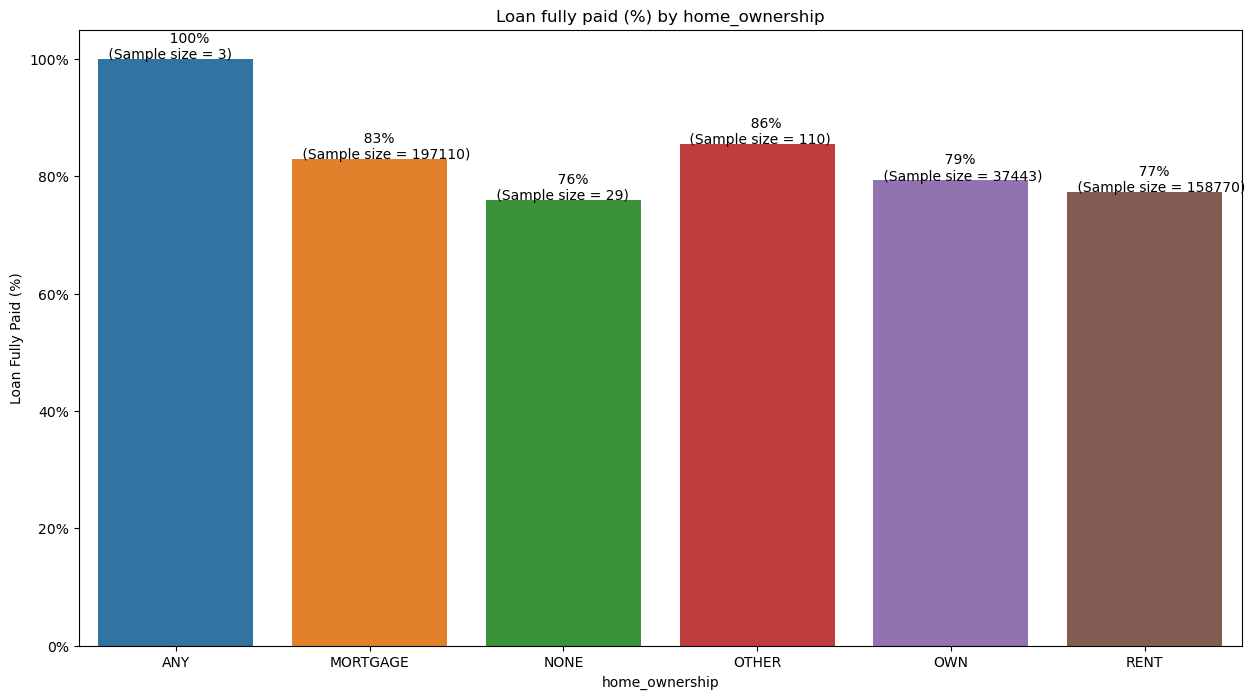

In [58]:
plt.figure(figsize = (15, 8))
ax = sns.barplot(x = loan_approve_pct_vs_home_ownership['home_ownership'], y = loan_approve_pct_vs_home_ownership['loan_fully_paid_pct'])
i = 0
for p in ax.patches:
    ax.annotate(" " * 15 + f'{round(p.get_height())}%\n (Sample size = {loan_approve_pct_vs_home_ownership.loc[i, "sample size"]})',
                (p.get_x() +0.03, p.get_height()+0.1))
    i += 1
plt.title('Loan fully paid (%) by home_ownership')
plt.yticks(ticks = range(0, 120, 20), labels = [f'{i}%' for i in range(0, 120, 20)])
plt.ylabel('Loan Fully Paid (%)')
plt.show()

### `10. loan_status vs annual_inc:` As the annual income increases, the percentage of loan fully paid also tends to increase.

In [59]:
loan_approve_pct_vs_annual_inc = df[['annual_inc', 'loan_status']].copy()
loan_approve_pct_vs_annual_inc['annual_inc'] = loan_approve_pct_vs_annual_inc['annual_inc'].apply(lambda x: '<50000' if x < 50000
                                                                                                  else '50000-75000' if 50000 <= x < 75000
                                                                                                  else '75000-100000' if 75000 <= x < 100000
                                                                                                  else '>100000')

In [60]:
loan_approve_pct_vs_annual_inc = (loan_approve_pct_vs_annual_inc.groupby('annual_inc').agg({'loan_status': fully_paid_pct})
                                 .reset_index().rename(columns = {'loan_status': 'loan_fully_paid_pct'}))

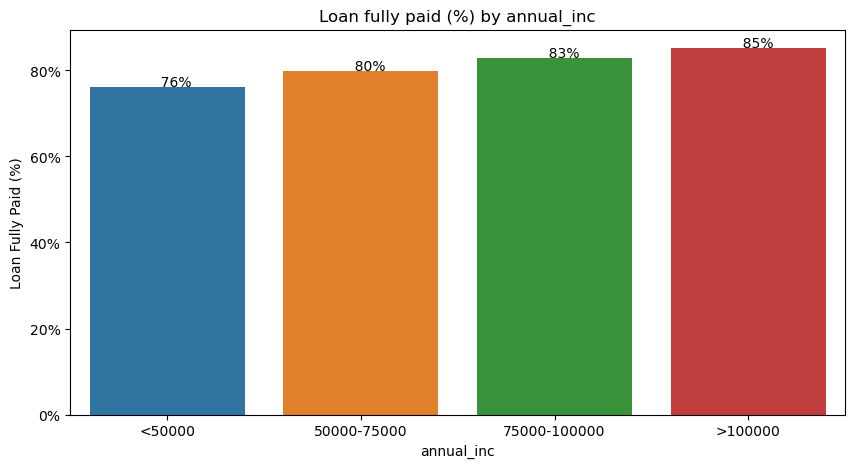

In [61]:
plt.figure(figsize = (10, 5))
ax = sns.barplot(x = loan_approve_pct_vs_annual_inc['annual_inc'], y = loan_approve_pct_vs_annual_inc['loan_fully_paid_pct'],
                order = ['<50000', '50000-75000', '75000-100000', '>100000'])
i = 0
for p in ax.patches:
    ax.annotate(" " * 15 + f'{round(p.get_height())}%', (p.get_x() +0.03, p.get_height()+0.1))
    i += 1
plt.title('Loan fully paid (%) by annual_inc')
plt.yticks(ticks = range(0, 100, 20), labels = [f'{i}%' for i in range(0, 100, 20)])
plt.ylabel('Loan Fully Paid (%)')
plt.show()

###  `11. loan_status vs verification_status:`

In [62]:
loan_approve_pct_vs_verification_status = (df.groupby('verification_status').agg({'loan_status': [fully_paid_pct, 'count']})
                                 .reset_index().rename(columns = {'loan_status': 'loan_fully_paid_pct'}))
loan_approve_pct_vs_verification_status.columns = ['verification_status', 'loan_fully_paid_pct', 'sample size']

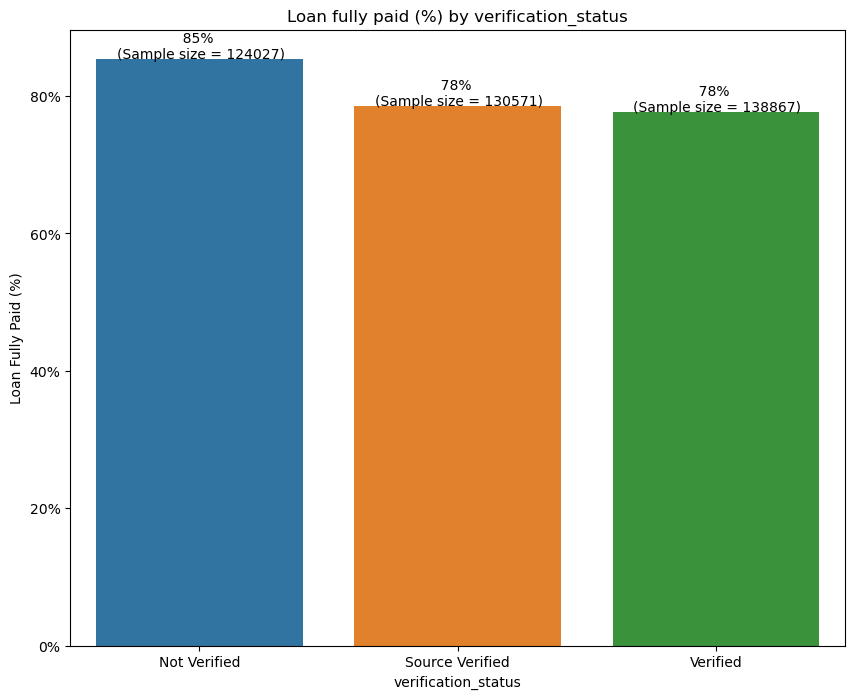

In [63]:
plt.figure(figsize = (10, 8))
ax = sns.barplot(x = loan_approve_pct_vs_verification_status['verification_status'], y = loan_approve_pct_vs_verification_status['loan_fully_paid_pct'])
i = 0
for p in ax.patches:
    ax.annotate(' ' * 15 + f'{round(p.get_height())}%\n' + f'(Sample size = {loan_approve_pct_vs_verification_status.loc[i, "sample size"]})',
                (p.get_x() +0.08, p.get_height()+0.1))
    i += 1
plt.title('Loan fully paid (%) by verification_status')
plt.yticks(ticks = range(0, 100, 20), labels = [f'{i}%' for i in range(0, 100, 20)])
plt.ylabel('Loan Fully Paid (%)')
plt.show()

###  `12. loan_status vs issue_d:` As there are 58 unique values in `issue_d` columns comprising of Month & year. Let's plot just by year itself

In [64]:
loan_approve_pct_vs_issued_d = df[['issue_d', 'loan_status']].copy()
loan_approve_pct_vs_issued_d['issue_d'] = loan_approve_pct_vs_issued_d['issue_d'].str[-4:].str.strip()
loan_approve_pct_vs_issued_d = (loan_approve_pct_vs_issued_d.groupby('issue_d').agg({'loan_status': [fully_paid_pct, 'count']})
                                 .reset_index().rename(columns = {'loan_status': 'loan_fully_paid_pct'}))
loan_approve_pct_vs_issued_d.columns = ['issue_d', 'loan_fully_paid_pct', 'sample size']

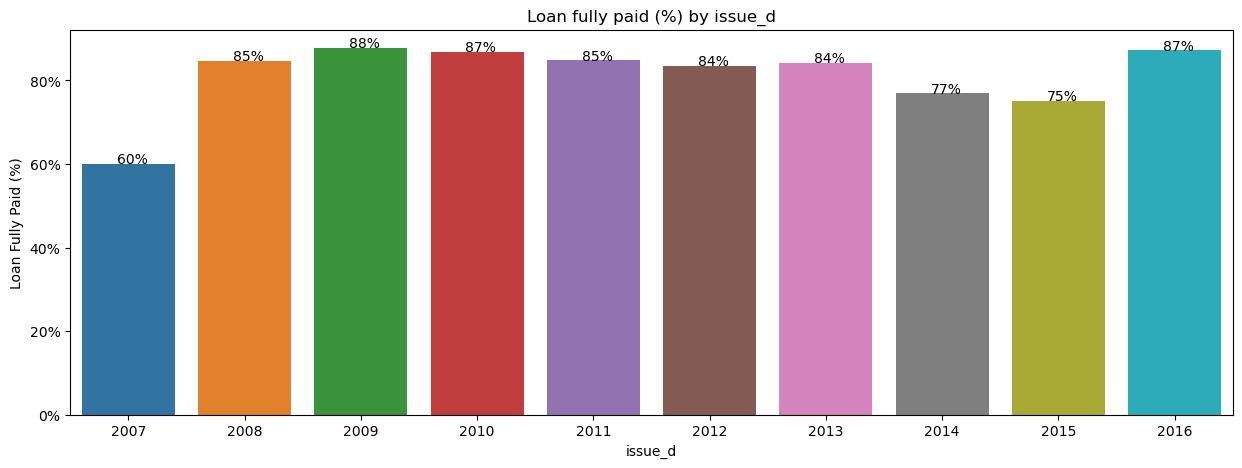

In [65]:
plt.figure(figsize = (15, 5))
ax = sns.barplot(x = loan_approve_pct_vs_issued_d['issue_d'], y = loan_approve_pct_vs_issued_d['loan_fully_paid_pct'])
i = 0
for p in ax.patches:
    ax.annotate(f'{round(p.get_height())}%', (p.get_x() +0.3, p.get_height()+0.1))
    i += 1
plt.title('Loan fully paid (%) by issue_d')
plt.yticks(ticks = range(0, 90, 20), labels = [f'{i}%' for i in range(0, 90, 20)])
plt.ylabel('Loan Fully Paid (%)')
plt.show()

###  `13. loan_status vs purpose:`

In [66]:
loan_approve_pct_vs_purpose = (df.groupby('purpose').agg({'loan_status': [fully_paid_pct, 'count']})
                                 .reset_index().rename(columns = {'loan_status': 'loan_fully_paid_pct'}))
loan_approve_pct_vs_purpose.columns = ['purpose', 'loan_fully_paid_pct', 'sample size']

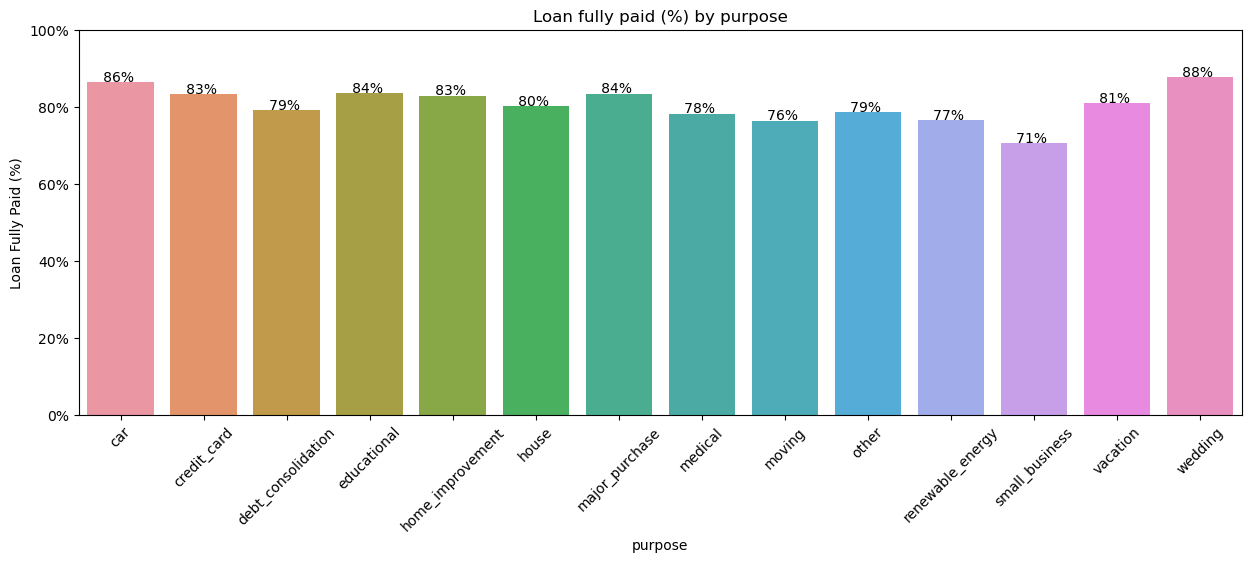

In [67]:
plt.figure(figsize = (15, 5))
ax = sns.barplot(x = loan_approve_pct_vs_purpose['purpose'], y = loan_approve_pct_vs_purpose['loan_fully_paid_pct'])
i = 0
for p in ax.patches:
    ax.annotate(' ' * 3 + f'{round(p.get_height())}%', (p.get_x() +0.03, p.get_height()+0.1))
    i += 1
plt.title('Loan fully paid (%) by purpose')
plt.xticks(rotation = 45)
plt.yticks(ticks = range(0, 120, 20), labels = [f'{i}%' for i in range(0, 120, 20)])
plt.ylabel('Loan Fully Paid (%)')
plt.show()

### `14. loan_status vs dti:` As ratio of borrower’s total monthly debt payments over self-reported monthly income increases, the percentage of loan fully paid tends to decrease.

In [68]:
loan_approve_pct_vs_dti = df[['dti', 'loan_status']].copy()
loan_approve_pct_vs_dti['dti'] = loan_approve_pct_vs_dti['dti'].apply(lambda x: '0-10' if 0 <= x < 10
                                                                      else '10-15' if 10 <= x < 15
                                                                      else '15-20' if 15 <= x < 20
                                                                      else '20-25' if 20 <= x < 25
                                                                      else '25-40' if 25 <= x < 40
                                                                      else '>40')

In [69]:
loan_approve_pct_vs_dti = (loan_approve_pct_vs_dti.groupby('dti').agg({'loan_status': fully_paid_pct})
                                 .reset_index().rename(columns = {'loan_status': 'loan_fully_paid_pct'}))

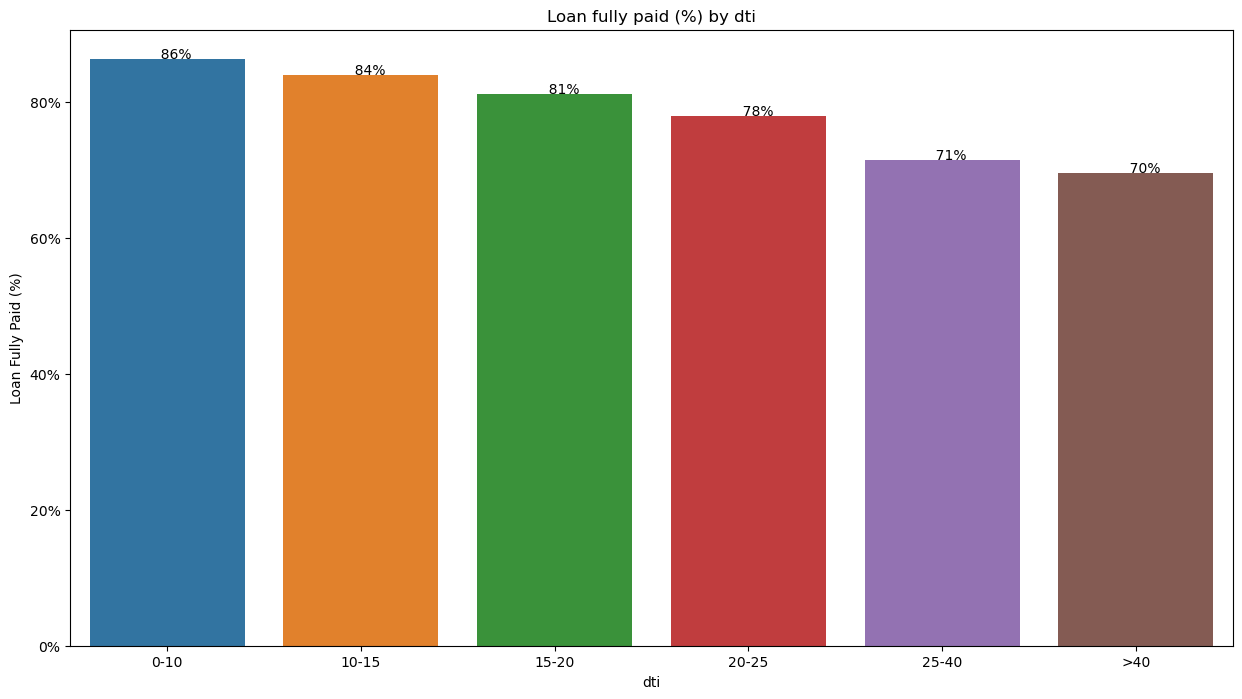

In [70]:
plt.figure(figsize = (15, 8))
ax = sns.barplot(x = loan_approve_pct_vs_dti['dti'], y = loan_approve_pct_vs_dti['loan_fully_paid_pct'])
i = 0
for p in ax.patches:
    ax.annotate(" " * 15 + f'{round(p.get_height())}%', (p.get_x() +0.03, p.get_height()+0.1))
    i += 1
plt.title('Loan fully paid (%) by dti')
plt.yticks(ticks = range(0, 90, 20), labels = [f'{i}%' for i in range(0, 90, 20)])
plt.ylabel('Loan Fully Paid (%)')
plt.show()

###  `15. loan_status vs earliest_cr_line:` As there are 683 unique values in `earliest_cr_line` columns comprising of Month & year. From the distribution, it looks like the percent of loan fully paid increased with the year of earliest_cr_line till late 1990's and then started to fall.

In [71]:
loan_approve_pct_vs_earliest_cr_line = df[['earliest_cr_line', 'loan_status']].copy()
loan_approve_pct_vs_earliest_cr_line['earliest_cr_line'] = loan_approve_pct_vs_earliest_cr_line['earliest_cr_line'].str[-4:].str.strip().astype('int64')
loan_approve_pct_vs_earliest_cr_line['earliest_cr_line'] = (loan_approve_pct_vs_earliest_cr_line['earliest_cr_line']
                                                            .apply(lambda x: '1940-1970' if 1940 <= x <= 1970 
                                                                   else '1971-1980' if 1971 <= x <= 1980
                                                                   else '1981-1990' if 1981 <= x <= 1990
                                                                   else '1991-2000' if 1991 <= x <= 2000
                                                                   else '2001-2010' if 2001 <= x <= 2010
                                                                   else '2011-2015'))
loan_approve_pct_vs_earliest_cr_line = (loan_approve_pct_vs_earliest_cr_line.groupby('earliest_cr_line').agg({'loan_status': [fully_paid_pct, 'count']})
                                 .reset_index().rename(columns = {'loan_status': 'loan_fully_paid_pct'}))
loan_approve_pct_vs_earliest_cr_line.columns = ['earliest_cr_line', 'loan_fully_paid_pct', 'sample size']

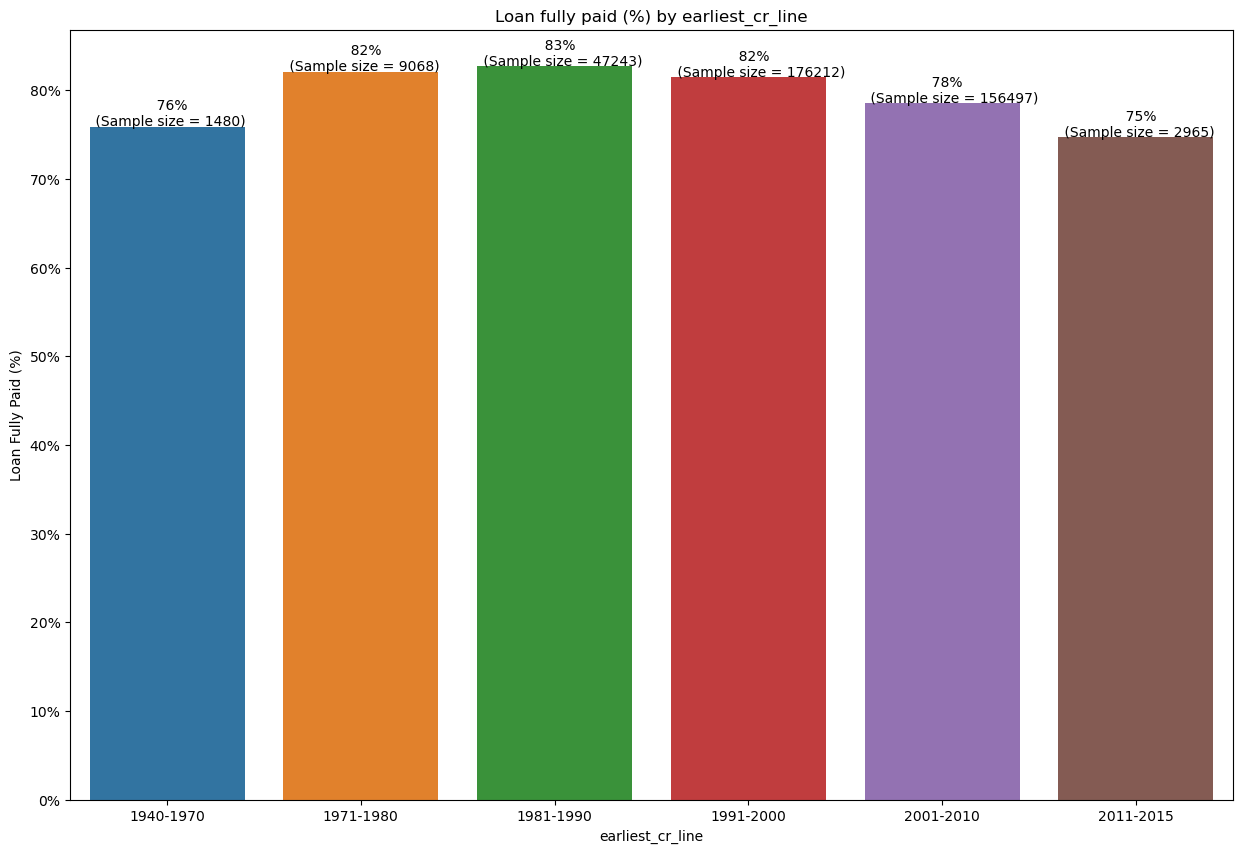

In [72]:
plt.figure(figsize = (15, 10))
ax = sns.barplot(x = loan_approve_pct_vs_earliest_cr_line['earliest_cr_line'], y = loan_approve_pct_vs_earliest_cr_line['loan_fully_paid_pct'])
i = 0
for p in ax.patches:
    ax.annotate(" " * 15 + f'{round(p.get_height())}%\n (Sample size = {loan_approve_pct_vs_earliest_cr_line.loc[i, "sample size"]})',
                (p.get_x() +0.01, p.get_height()+0.1))
    i += 1
plt.title('Loan fully paid (%) by earliest_cr_line')
plt.yticks(ticks = range(0, 90, 10), labels = [f'{i}%' for i in range(0, 90, 10)])
plt.ylabel('Loan Fully Paid (%)')
plt.show()

###  `16. loan_status vs open_acc:` As the value of open_acc increases, the percentage of loan fully paid seems to decrease except of >50 category but for those, the sample size is too low.

In [73]:
loan_approve_pct_vs_open_acc = df[['open_acc', 'loan_status']].copy()
loan_approve_pct_vs_open_acc['open_acc'] = loan_approve_pct_vs_open_acc['open_acc'].apply(lambda x: '1-5' if 1 <= x <= 5
                                                                                          else '6-10' if 6 <= x <= 10
                                                                                          else '11-15' if 11 <= x <= 15
                                                                                          else '16-20' if 16 <= x <= 20
                                                                                          else '21-25' if 21 <= x <= 25
                                                                                          else '26-30' if 26 <= x <= 30
                                                                                          else '31-40' if 31 <= x <= 40
                                                                                          else '41-50' if 41 <= x <= 50
                                                                                          else '>50')
loan_approve_pct_vs_open_acc = (loan_approve_pct_vs_open_acc.groupby('open_acc').agg({'loan_status': [fully_paid_pct, 'count']})
                                 .reset_index().rename(columns = {'loan_status': 'loan_fully_paid_pct'}))
loan_approve_pct_vs_open_acc.columns = ['open_acc', 'loan_fully_paid_pct', 'sample size']

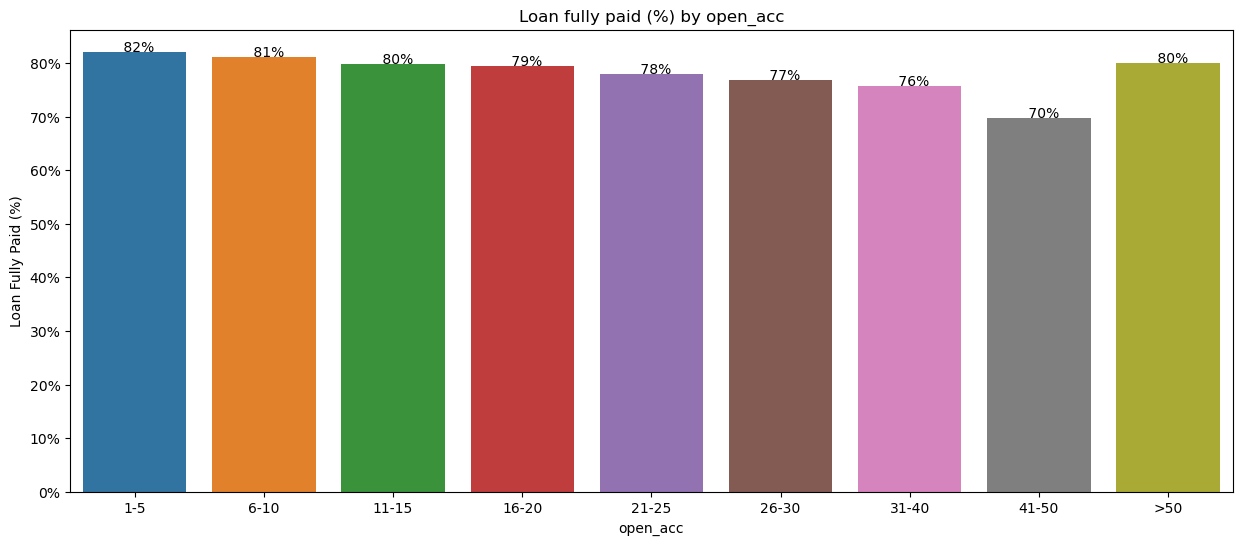

In [74]:
plt.figure(figsize = (15, 6))
ax = sns.barplot(x = loan_approve_pct_vs_open_acc['open_acc'], y = loan_approve_pct_vs_open_acc['loan_fully_paid_pct'],
                order = ['1-5', '6-10', '11-15', '16-20', '21-25', '26-30', '31-40', '41-50', '>50'])

for p in ax.patches:
    ax.annotate(" " * 9 + f'{round(p.get_height())}%', (p.get_x() +0.01, p.get_height()+0.1))
plt.title('Loan fully paid (%) by open_acc')
plt.yticks(ticks = range(0, 90, 10), labels = [f'{i}%' for i in range(0, 90, 10)])
plt.ylabel('Loan Fully Paid (%)')
plt.show()

###  `17. loan_status vs pub_rec:` The percentage of loan fully paid is similar across the customers with public record and no public record.

In [75]:
loan_approve_pct_vs_pub_rec = df[['pub_rec', 'loan_status']].copy()
loan_approve_pct_vs_pub_rec['pub_rec'] = loan_approve_pct_vs_pub_rec['pub_rec'].apply(lambda x: 'No public record' if x == 0 else 'Public Record')
loan_approve_pct_vs_pub_rec = (loan_approve_pct_vs_pub_rec.groupby('pub_rec').agg({'loan_status': [fully_paid_pct, 'count']})
                                 .reset_index().rename(columns = {'loan_status': 'loan_fully_paid_pct'}))
loan_approve_pct_vs_pub_rec.columns = ['pub_rec', 'loan_fully_paid_pct', 'sample size']

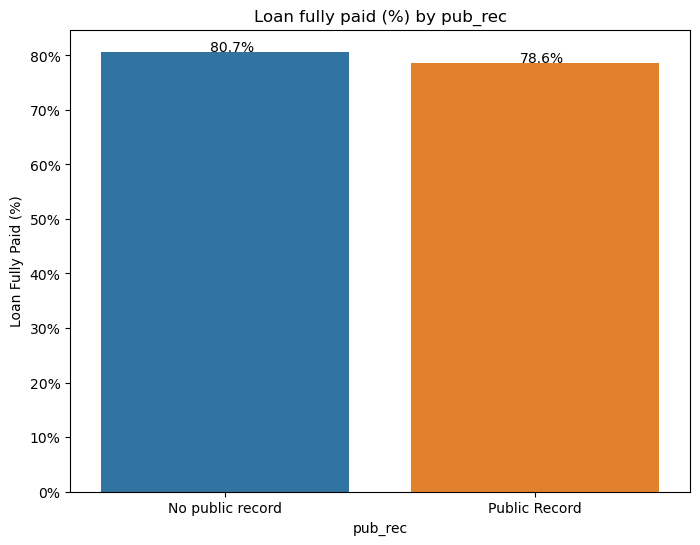

In [76]:
plt.figure(figsize = (8, 6))
ax = sns.barplot(x = loan_approve_pct_vs_pub_rec['pub_rec'], y = loan_approve_pct_vs_pub_rec['loan_fully_paid_pct'])
i = 0
for p in ax.patches:
    ax.annotate(f'{round(p.get_height(), 1)}%', (p.get_x() +0.35, p.get_height()+0.15))
    i += 1
plt.title('Loan fully paid (%) by pub_rec')
plt.yticks(ticks = range(0, 90, 10), labels = [f'{i}%' for i in range(0, 90, 10)])
plt.ylabel('Loan Fully Paid (%)')
plt.show()

###  `18. loan_status vs revol_bal:` The percentage of loan fully paid is similar across all the ranges of revol_bal

In [77]:
loan_approve_pct_vs_revol_bal = df[['revol_bal', 'loan_status']].copy()
loan_approve_pct_vs_revol_bal['revol_bal'] = loan_approve_pct_vs_revol_bal['revol_bal'].apply(lambda x: '0-5000' if 0 <= x <= 5000
                                                                                              else '5000-10000' if 5000 < x <= 10000
                                                                                              else '10000-20000' if 10000 < x <= 20000
                                                                                              else '20000-30000' if 20000 < x <= 30000
                                                                                              else '30000-40000' if 30000 < x <= 40000
                                                                                              else '40000-50000' if 40000 < x <= 50000
                                                                                             else '>50000')
loan_approve_pct_vs_revol_bal = (loan_approve_pct_vs_revol_bal.groupby('revol_bal').agg({'loan_status': [fully_paid_pct, 'count']})
                                 .reset_index().rename(columns = {'loan_status': 'loan_fully_paid_pct'}))
loan_approve_pct_vs_revol_bal.columns = ['revol_bal', 'loan_fully_paid_pct', 'sample size']

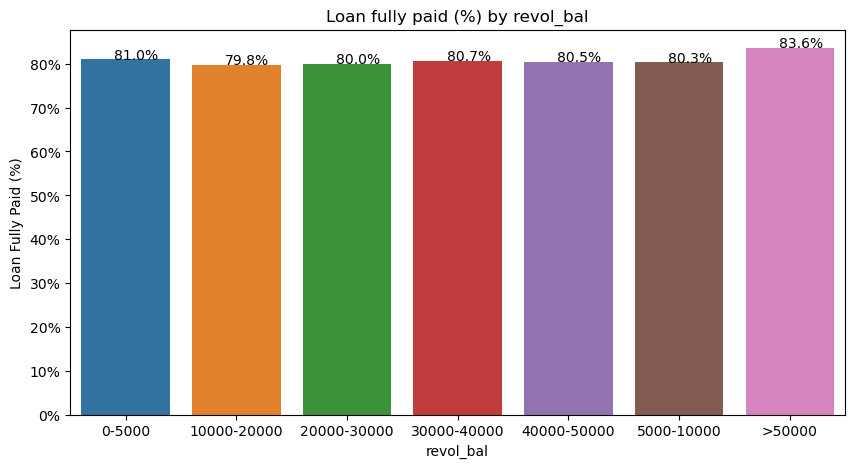

In [78]:
plt.figure(figsize = (10, 5))
ax = sns.barplot(x = loan_approve_pct_vs_revol_bal['revol_bal'], y = loan_approve_pct_vs_revol_bal['loan_fully_paid_pct'])
i = 0
for p in ax.patches:
    ax.annotate(f'{round(p.get_height(), 1)}%', (p.get_x() +0.3, p.get_height()+0.1))
    i += 1
plt.title('Loan fully paid (%) by revol_bal')
plt.yticks(ticks = range(0, 90, 10), labels = [f'{i}%' for i in range(0, 90, 10)])
plt.ylabel('Loan Fully Paid (%)')
plt.show()

###  `19. loan_status vs revol_util:` As the revol_util increases, the percentage of loan fully paid tends to decrease a bit

In [79]:
loan_approve_pct_vs_revol_util = df[['revol_util', 'loan_status']].copy()
loan_approve_pct_vs_revol_util['revol_util'] = loan_approve_pct_vs_revol_util['revol_util'].apply(lambda x: '0' if x == 0 
                                                                                              else '1-25' if 0 < x <= 25
                                                                                              else '26-50' if 25 < x <= 50
                                                                                              else '51-75' if 50 < x <= 75
                                                                                              else '>75')
loan_approve_pct_vs_revol_util = (loan_approve_pct_vs_revol_util.groupby('revol_util').agg({'loan_status': [fully_paid_pct, 'count']})
                                 .reset_index().rename(columns = {'loan_status': 'loan_fully_paid_pct'}))
loan_approve_pct_vs_revol_util.columns = ['revol_util', 'loan_fully_paid_pct', 'sample size']

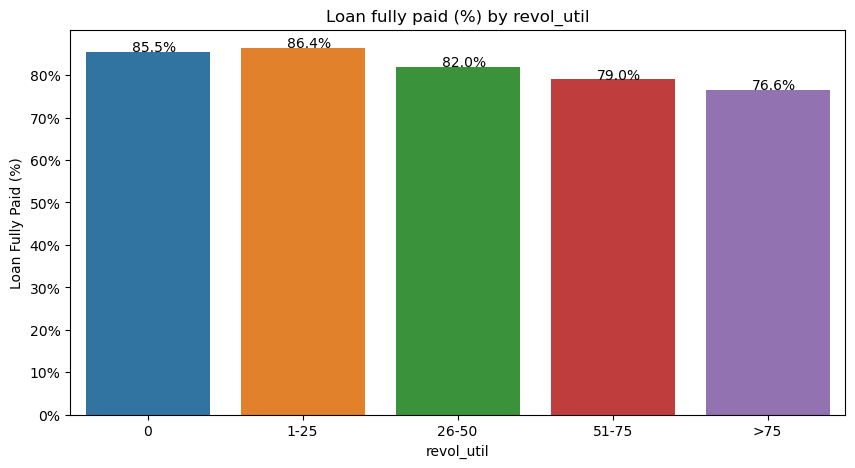

In [80]:
plt.figure(figsize = (10, 5))
ax = sns.barplot(x = loan_approve_pct_vs_revol_util['revol_util'], y = loan_approve_pct_vs_revol_util['loan_fully_paid_pct'])
i = 0
for p in ax.patches:
    ax.annotate(f'{round(p.get_height(), 1)}%', (p.get_x() +0.3, p.get_height()+0.1))
    i += 1
plt.title('Loan fully paid (%) by revol_util')
plt.yticks(ticks = range(0, 90, 10), labels = [f'{i}%' for i in range(0, 90, 10)])
plt.ylabel('Loan Fully Paid (%)')
plt.show()

###  `20. loan_status vs total_acc:` The percentage of loan fully paid is similar across all the total_acc ranges.

In [81]:
loan_approve_pct_vs_total_acc = df[['total_acc', 'loan_status']].copy()
loan_approve_pct_vs_total_acc['total_acc'] = loan_approve_pct_vs_total_acc['total_acc'].apply(lambda x: '1-10' if 1 <= x <= 10 
                                                                                              else '11-20' if 10 < x <= 20
                                                                                              else '21-30' if 20 < x <= 30
                                                                                              else '31-40' if 30 < x <= 40
                                                                                              else '41-50' if 40 < x <= 50
                                                                                              else '>50')
loan_approve_pct_vs_total_acc = (loan_approve_pct_vs_total_acc.groupby('total_acc').agg({'loan_status': [fully_paid_pct, 'count']})
                                 .reset_index().rename(columns = {'loan_status': 'loan_fully_paid_pct'}))
loan_approve_pct_vs_total_acc.columns = ['total_acc', 'loan_fully_paid_pct', 'sample size']
loan_approve_pct_vs_total_acc['order'] = loan_approve_pct_vs_total_acc['total_acc'].apply(lambda x: 0 if x == '<=2' else 1 if x == '3-25'
                                                                                          else 2 if x == '26-35' else 3)
loan_approve_pct_vs_total_acc.sort_values(['order'], inplace = True)

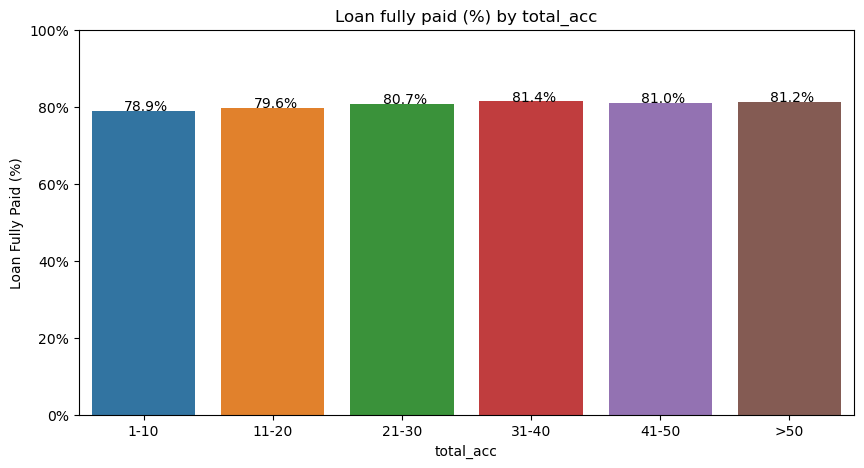

In [82]:
plt.figure(figsize = (10, 5))
ax = sns.barplot(x = loan_approve_pct_vs_total_acc['total_acc'], y = loan_approve_pct_vs_total_acc['loan_fully_paid_pct'])
i = 0
for p in ax.patches:
    ax.annotate(f'{round(p.get_height(), 1)}%', (p.get_x() +0.25, p.get_height()+0.1))
    i += 1
plt.title('Loan fully paid (%) by total_acc')
plt.ylabel('Loan Fully Paid (%)')
plt.yticks(ticks = range(0, 120, 20), labels = [f'{i}%' for i in range(0, 120, 20)])
plt.show()

###  `21. loan_status vs initial_list_status:`The percentage of loan fully paid is similar across initial_list_status = 'f' and initial_list_status = 'w'

In [83]:
loan_approve_pct_vs_initial_list_status = (df.groupby('initial_list_status').agg({'loan_status': [fully_paid_pct, 'count']})
                                 .reset_index().rename(columns = {'loan_status': 'loan_fully_paid_pct'}))
loan_approve_pct_vs_initial_list_status.columns = ['initial_list_status', 'loan_fully_paid_pct', 'sample size']

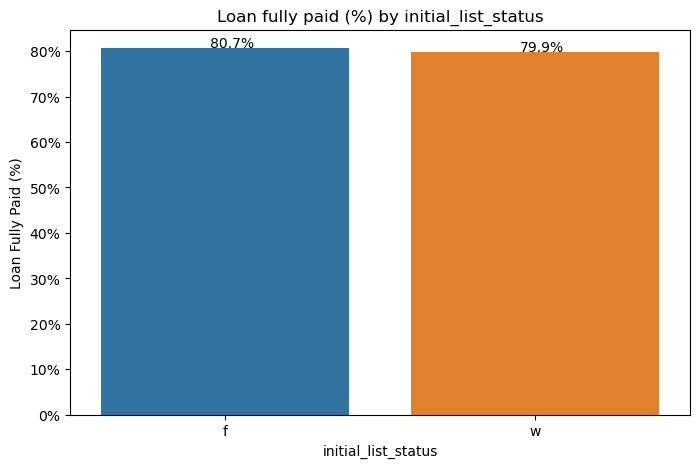

In [84]:
plt.figure(figsize = (8, 5))
ax = sns.barplot(x = loan_approve_pct_vs_initial_list_status['initial_list_status'],
                 y = loan_approve_pct_vs_initial_list_status['loan_fully_paid_pct'])
i = 0
for p in ax.patches:
    ax.annotate(f'{round(p.get_height(), 1)}%', (p.get_x() +0.35, p.get_height()+0.1))
    i += 1
plt.title('Loan fully paid (%) by initial_list_status')
plt.ylabel('Loan Fully Paid (%)')
plt.yticks(ticks = range(0, 90, 10), labels = [f'{i}%' for i in range(0, 90, 10)])
plt.show()

###  `22. loan_status vs application_type:` The percentage of loan fully paid is lowest for customers with application_type = "DIRECT_PAY" and highest for application_type = "JOINT"

In [85]:
loan_approve_pct_vs_application_type = (df.groupby('application_type').agg({'loan_status': [fully_paid_pct, 'count']})
                                 .reset_index().rename(columns = {'loan_status': 'loan_fully_paid_pct'}))
loan_approve_pct_vs_application_type.columns = ['application_type', 'loan_fully_paid_pct', 'sample size']

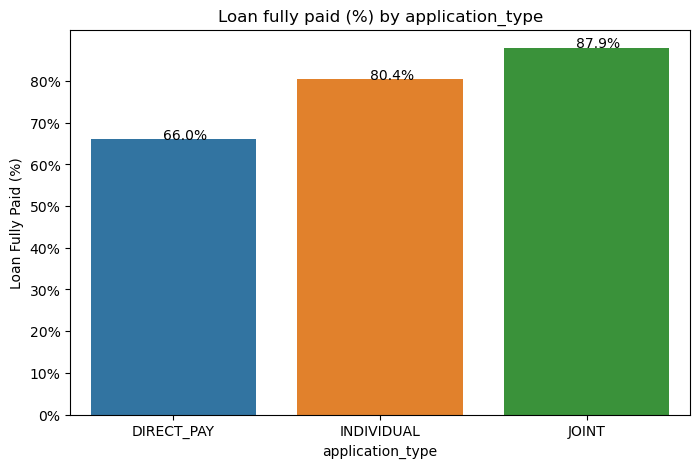

In [86]:
plt.figure(figsize = (8, 5))
ax = sns.barplot(x = loan_approve_pct_vs_application_type['application_type'],
                 y = loan_approve_pct_vs_application_type['loan_fully_paid_pct'])
i = 0
for p in ax.patches:
    ax.annotate(f'{round(p.get_height(), 1)}%', (p.get_x() +0.35, p.get_height()+0.1))
    i += 1
plt.title('Loan fully paid (%) by application_type')
plt.yticks(ticks = range(0, 90, 10), labels = [f'{i}%' for i in range(0, 90, 10)])
plt.ylabel('Loan Fully Paid (%)')
plt.show()

###  `23. loan_status vs mort_acc:`

In [87]:
loan_approve_pct_vs_mort_acc = df[['mort_acc', 'loan_status']].copy()
loan_approve_pct_vs_mort_acc = loan_approve_pct_vs_mort_acc[~loan_approve_pct_vs_mort_acc['mort_acc'].isnull()]
loan_approve_pct_vs_mort_acc['mort_acc'] = loan_approve_pct_vs_mort_acc['mort_acc'].apply(lambda x: '0' if x == 0 
                                                                                              else '1-3' if 0 < x <= 3
                                                                                              else '4-6' if 3 < x <= 6
                                                                                              else '7-10' if 6 < x <= 10
                                                                                              else '>10')
loan_approve_pct_vs_mort_acc = (loan_approve_pct_vs_mort_acc.groupby('mort_acc').agg({'loan_status': [fully_paid_pct, 'count']})
                                 .reset_index().rename(columns = {'loan_status': 'loan_fully_paid_pct'}))
loan_approve_pct_vs_mort_acc.columns = ['mort_acc', 'loan_fully_paid_pct', 'sample size']
loan_approve_pct_vs_mort_acc['order'] = loan_approve_pct_vs_mort_acc['mort_acc'].apply(lambda x: 0 if x == '0' else 1 if x == '1-5'
                                                                                          else 2)
loan_approve_pct_vs_mort_acc.sort_values(['order'], inplace = True)

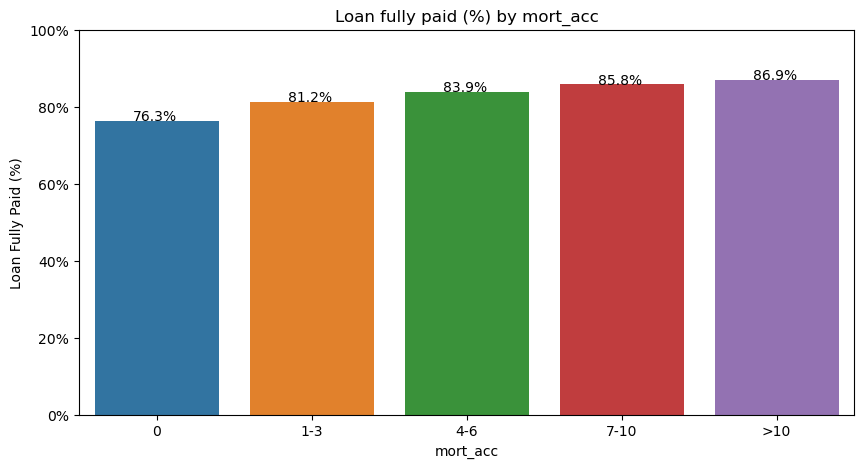

In [88]:
plt.figure(figsize = (10, 5))
ax = sns.barplot(x = loan_approve_pct_vs_mort_acc['mort_acc'], y = loan_approve_pct_vs_mort_acc['loan_fully_paid_pct'])
i = 0
for p in ax.patches:
    ax.annotate(f'{round(p.get_height(), 1)}%', (p.get_x() +0.25, p.get_height()+0.1))
    i += 1
plt.title('Loan fully paid (%) by mort_acc')
plt.ylabel('Loan Fully Paid (%)')
plt.yticks(ticks = range(0, 120, 20), labels = [f'{i}%' for i in range(0, 120, 20)])
plt.show()

###  `24. loan_status vs pub_rec_bankruptcies:` The percentage of loan fully paid is lowest for customers with pub_rec_bankruptcies > 3

In [89]:
loan_approve_pct_vs_pub_rec_bankruptcies = df[['pub_rec_bankruptcies', 'loan_status']].copy()
loan_approve_pct_vs_pub_rec_bankruptcies['pub_rec_bankruptcies'] = (loan_approve_pct_vs_pub_rec_bankruptcies['pub_rec_bankruptcies']
                                                                    .apply(lambda x: '0' if x == 0 else '1-3' if 1 <= x <= 3 
                                                                           else '>3'))
loan_approve_pct_vs_pub_rec_bankruptcies = (loan_approve_pct_vs_pub_rec_bankruptcies.groupby('pub_rec_bankruptcies')
                                            .agg({'loan_status': [fully_paid_pct, 'count']})
                                            .reset_index().rename(columns = {'loan_status': 'loan_fully_paid_pct'}))
loan_approve_pct_vs_pub_rec_bankruptcies.columns = ['pub_rec_bankruptcies', 'loan_fully_paid_pct', 'sample size']
loan_approve_pct_vs_pub_rec_bankruptcies['order'] = (loan_approve_pct_vs_pub_rec_bankruptcies['pub_rec_bankruptcies']
                                                     .apply(lambda x: 0 if x == '0-1' else 1 if x == '1-2' else 2))
loan_approve_pct_vs_pub_rec_bankruptcies.sort_values(['order'], inplace = True)

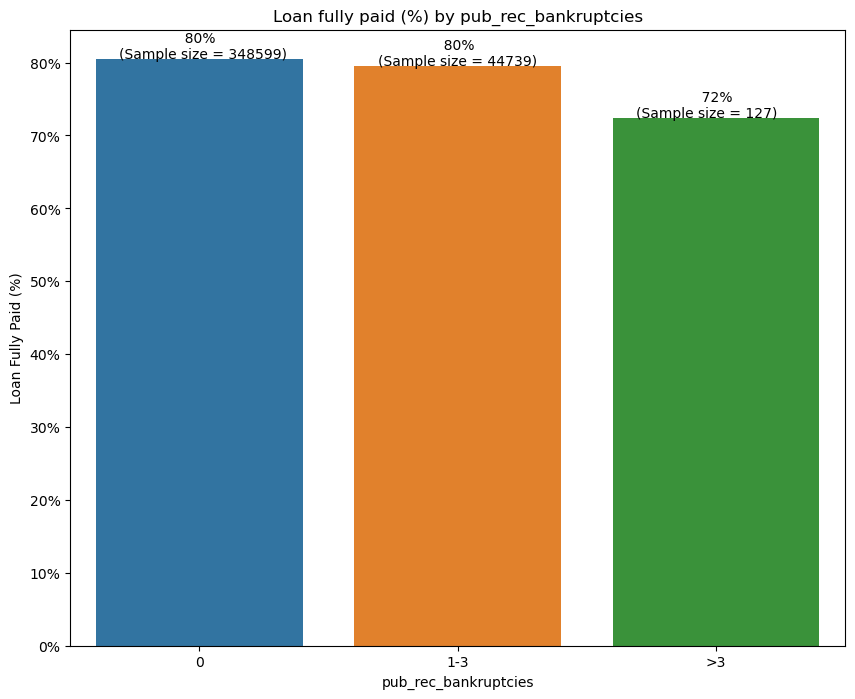

In [90]:
plt.figure(figsize = (10, 8))
ax = sns.barplot(x = loan_approve_pct_vs_pub_rec_bankruptcies['pub_rec_bankruptcies'], y = loan_approve_pct_vs_pub_rec_bankruptcies['loan_fully_paid_pct'])
i = 0
for p in ax.patches:
    ax.annotate(' ' * 15 + f'{round(p.get_height())}%\n(Sample size = {loan_approve_pct_vs_pub_rec_bankruptcies.loc[i, "sample size"]})',
                (p.get_x() +0.09, p.get_height()+0.1))
    i += 1
plt.title('Loan fully paid (%) by pub_rec_bankruptcies')
plt.yticks(ticks = range(0, 90, 10), labels = [f'{i}%' for i in range(0, 90, 10)])
plt.ylabel('Loan Fully Paid (%)')
plt.show()

###  `25. loan_status vs address:`

In [91]:
loan_approve_pct_vs_pincode = df[['loan_status', 'address']].copy()
loan_approve_pct_vs_pincode['address'] = df['address'].str.split().str[-2]
loan_approve_pct_vs_pincode = (loan_approve_pct_vs_pincode.groupby('address')
                                            .agg({'loan_status': [fully_paid_pct, 'count']})
                                            .reset_index().rename(columns = {'loan_status': 'loan_fully_paid_pct'}))
loan_approve_pct_vs_pincode.columns = ['address', 'loan_fully_paid_pct', 'sample size']

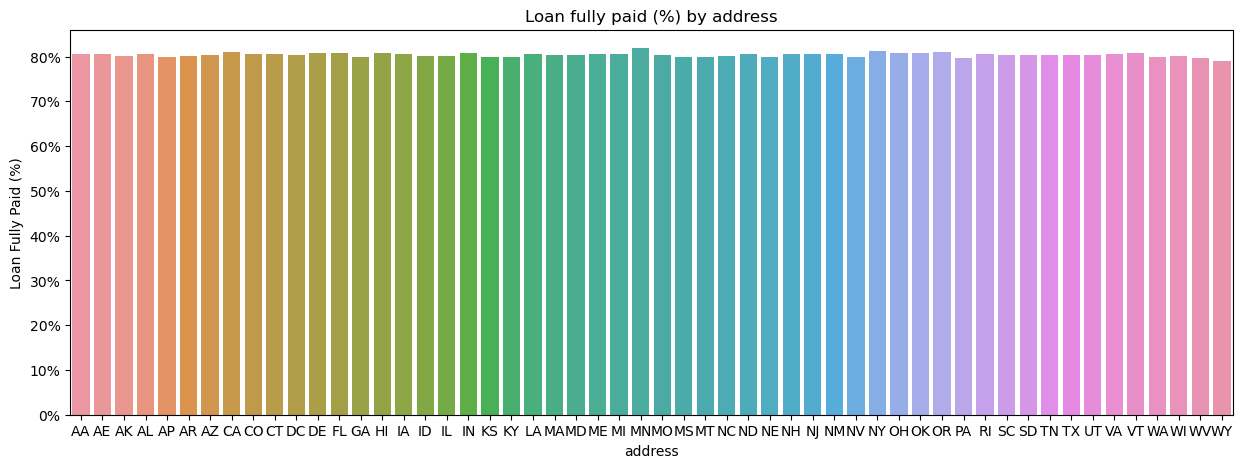

In [92]:
plt.figure(figsize = (15, 5))
ax = sns.barplot(x = loan_approve_pct_vs_pincode['address'], y = loan_approve_pct_vs_pincode['loan_fully_paid_pct'])
plt.title('Loan fully paid (%) by address')
plt.yticks(ticks = range(0, 90, 10), labels = [f'{i}%' for i in range(0, 90, 10)])
plt.ylabel('Loan Fully Paid (%)')
plt.show()

###  `25. loan_amnt vs installment:` As the loan_amnt increases, installment also increases which is very intuitive also.

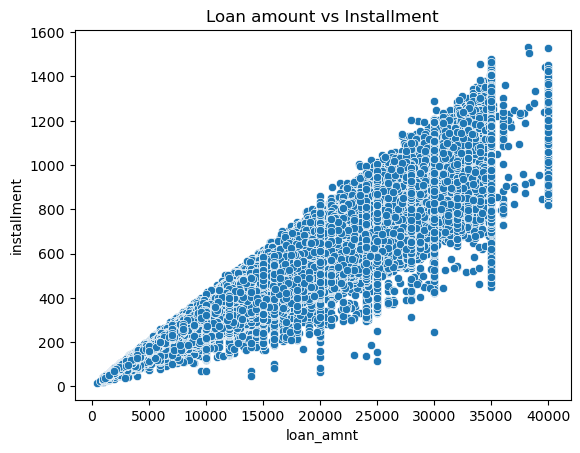

In [93]:
sns.scatterplot(df['loan_amnt'], df['installment'])
plt.title('Loan amount vs Installment')
plt.show()

In [94]:
df.isnull().sum()

loan_amnt                   0
term                        0
int_rate                    0
installment                 0
grade                       0
sub_grade                   0
emp_title                   0
emp_length                  0
home_ownership              0
annual_inc                  0
verification_status         0
issue_d                     0
loan_status                 0
purpose                     0
title                       0
dti                         0
earliest_cr_line            0
open_acc                    0
pub_rec                     0
revol_bal                   0
revol_util                  0
total_acc                   0
initial_list_status         0
application_type            0
mort_acc                37195
pub_rec_bankruptcies        0
address                     0
dtype: int64

***

# **`Feature Engineering`**

### **`1. term:`** As `term` has only 2 unique values therefore we'll do One Hot Encoding (OHE) on it.

In [95]:
df = pd.concat((df, pd.get_dummies(df['term'], prefix = 'term_').astype('int64')), axis = 1)
df.drop(columns = 'term', inplace = True)

## **`2. home_ownership:`** As `home_ownership` has only 6 unique values therefore we'll do One Hot Encoding (OHE) on it.

In [96]:
df = pd.concat((df, pd.get_dummies(df['home_ownership'], prefix = 'home_ownership_').astype('int64')), axis = 1)
df.drop(columns = 'home_ownership', inplace = True)

## **`3. initial_list_status:`** As `initial_list_status` has only 2 unique values i.e. `w` & `f` therefore we'll do One Hot Encoding (OHE) on it.

In [97]:
df = pd.concat((df, pd.get_dummies(df['initial_list_status'], prefix = 'initial_list_status_').astype('int64')), axis = 1)
df.drop(columns = 'initial_list_status', inplace = True)

## **`4. application_type:`** As `application_type` has only 3 unique values i.e. `INDIVIDUAL`, `JOINT` &  `DIRECT_PAY` therefore we'll do One Hot Encoding (OHE) on it.

In [98]:
df = pd.concat((df, pd.get_dummies(df['application_type'], prefix = 'application_type_').astype('int64')), axis = 1)
df.drop(columns = 'application_type', inplace = True)

## **`5. verification_status:`** As `application_type` has only 3 unique values i.e. `Not Verified`, `Source Verified` &  `Verified` therefore we'll do One Hot Encoding (OHE) on it.

In [99]:
df = pd.concat((df, pd.get_dummies(df['verification_status'], prefix = 'verification_status_').astype('int64')), axis = 1)
df.drop(columns = 'verification_status', inplace = True)

## **`6. loan_status:`** We will encode `Fully Paid` as class 1 (i.e. positive class) and `Charged Off` as class 0 (i.e. negative class)

In [100]:
df['loan_status'] = df['loan_status'].apply(lambda x: 1 if x == 'Fully Paid' else 0).astype('int64')

## **`7. grade:`** As `grade` has 7 unique values therefore we'll do Target Encoding on it.

In [101]:
encoder = TargetEncoder()
df['grade'] = encoder.fit_transform(df[['grade']], df['loan_status'])

## **`8. sub_grade:`** As `sub_grade` has 35 unique values therefore we'll do Target Encoding on it.

In [102]:
encoder = TargetEncoder()
df['sub_grade'] = encoder.fit_transform(df[['sub_grade']], df['loan_status'])

## **`9. emp_title:`** As `emp_title` has 167471 unique values therefore we'll do Target Encoding on it.

In [103]:
encoder = TargetEncoder()
df['emp_title'] = encoder.fit_transform(df[['emp_title']], df['loan_status'])

## **`10. emp_length:`** As `emp_length` has 12 unique values therefore we'll do Target Encoding on it.

In [104]:
encoder = TargetEncoder()
df['emp_length'] = encoder.fit_transform(df[['emp_length']], df['loan_status'])

## **`11. issue_d:`** As `issue_d` has 10 unique values therefore we'll do Target Encoding on it.

In [105]:
df['issue_d'] = df['issue_d'].str.split('-', expand=True)[1].astype('int64')
encoder = TargetEncoder()
df['issue_d'] = encoder.fit_transform(df[['issue_d']], df['loan_status'])

## **`12. purpose:`** As `purpose` has 14 unique values therefore we'll do Target Encoding on it.

In [106]:
encoder = TargetEncoder()
df['purpose'] = encoder.fit_transform(df[['purpose']], df['loan_status'])

## **`13. title:`** As `issue_d` has 47138 unique values therefore we'll do Target Encoding on it.

In [107]:
encoder = TargetEncoder()
df['title'] = encoder.fit_transform(df[['title']], df['loan_status'])

## **`14. earliest_cr_line:`** We'll use the year of earliest_cr_line and as the numerical value of that is not having a ordinal effect on the target variable (as we saw in the bivariate analysis) therefore we'll create categories out of it and then perform One Hot Encoding (OHE) on it as we're creating just 6 unique categories.

In [108]:
df['earliest_cr_line'] = df['earliest_cr_line'].str.split('-', expand=True)[1].astype('int64')
df['earliest_cr_line'] = df['earliest_cr_line'].apply(lambda x: '1940-1970' if 1940 <= x <= 1970 
                                                                   else '1971-1980' if 1971 <= x <= 1980
                                                                   else '1981-1990' if 1981 <= x <= 1990
                                                                   else '1991-2000' if 1991 <= x <= 2000
                                                                   else '2001-2010' if 2001 <= x <= 2010
                                                                   else '2011-2015')

In [109]:
df = pd.concat((df, pd.get_dummies(df['earliest_cr_line'], prefix = 'earliest_cr_line_')), axis = 1)
df.drop(columns = ['earliest_cr_line'], inplace = True)

## **`15. address:`** We'll extract pincode out of the `address` and then use that as a categorical variable and perform Target Encoding on it as numerical value of pincode doesn't have any ordinal effect on the target variable `loan_status`

In [110]:
df['pincode'] = df['address'].str.split().str[-1]
encoder = TargetEncoder()
df['pincode'] = encoder.fit_transform(df[['pincode']], df['loan_status'])
df.drop(columns = ['address'], inplace = True)

## **`16. mort_acc:`** As we know that `mort_acc` has nulls in it, so we'll use KNN Imputer to impute the missing values in `mort_acc` and then we will create a binary feature out of `mort_acc` i.e. 1 if `mort_acc` > 0 else 0

In [111]:
temp_df = df.copy()
ind_cols = [col for col in temp_df.columns if col not in  ('mort_acc', 'loan_status')]
X = temp_df.drop(columns = ['loan_status'])

#### `Using Standard Scaler to standardize the features for effective results of KNN Imputer`

In [112]:
scaler = StandardScaler()
X[ind_cols] = scaler.fit_transform(X[ind_cols])

#### `Using KNNImputer (with n_neighbors = 3) to fill up the missing values in mort_acc`

In [113]:
imputer = KNNImputer(n_neighbors = 3)
X = imputer.fit_transform(X)

In [119]:
df.loc[:, 'mort_acc'] = X[:, 17].round()

#### `Creating a binary feature out of mort_acc`

In [120]:
df['mort_acc'] = (df['mort_acc'] > 0).astype('int64')

In [121]:
df.head()

,loan_amnt,int_rate,installment,grade,sub_grade,emp_title,emp_length,annual_inc,issue_d,loan_status,...,verification_status__Not Verified,verification_status__Source Verified,verification_status__Verified,earliest_cr_line__1940-1970,earliest_cr_line__1971-1980,earliest_cr_line__1981-1990,earliest_cr_line__1991-2000,earliest_cr_line__2001-2010,earliest_cr_line__2011-2015,pincode
0,10000.0,11.44,329.48,0.873628,0.861127,0.767914,0.815054,117000.0,0.750446,1,...,1,0,0,0,0,1,0,0,0,0.806113
1,8000.0,11.99,265.68,0.874689,0.847275,0.883354,0.808058,65000.0,0.751769,1,...,1,0,0,0,0,0,0,1,0,1.000000
2,15600.0,10.49,506.97,0.875299,0.878304,0.883354,0.792073,43057.0,0.750446,1,...,0,1,0,0,0,0,0,1,0,1.000000
3,7200.0,6.49,220.65,0.936576,0.952251,0.803810,0.812477,54000.0,0.769519,1,...,1,0,0,0,0,0,0,1,0,1.000000
4,24375.0,17.27,609.33,0.787921,0.756764,0.803810,0.797836,55000.0,0.843025,0,...,0,0,1,0,0,0,1,0,0,0.000000


## **`17. pub_rec:`** We will create a binary feature out of `pub_rec` i.e. 1 if `pub_rec` > 0 else 0

In [122]:
df['pub_rec'] = (df['pub_rec'] > 0).astype('int64')

## **`18. pub_rec_bankruptcies:`** We will create a binary feature out of `pub_rec_bankruptcies` i.e. 1 if `pub_rec_bankruptcies` > 0 else 0

In [123]:
df['pub_rec_bankruptcies'] = (df['pub_rec_bankruptcies'] > 0).astype('int64')

***

# **`Train Test Split`**

#### `Separating features (independent variables) and response variable (dependent variables)`

In [124]:
X = df.drop(columns = ['loan_status'])
y = df['loan_status']

#### `Splitting the data into training and test datasets in ratio 70:30`

In [125]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 40)

***

# **`Feature Scaling`**

#### `Let's leave binary features for scaling.`

In [126]:
binary_cols = []
non_binary_cols = []
for col in X.columns:
    if X[col].isin([0, 1]).all():
        binary_cols.append(col)
    else:
        non_binary_cols.append(col)

In [127]:
X_train_binary = X_train[binary_cols]
X_train_non_binary = X_train[non_binary_cols]
X_test_binary = X_test[binary_cols]
X_test_non_binary = X_test[non_binary_cols]

#### `Instantiating object of MinMaxScaler class`

In [128]:
minmax = MinMaxScaler()

#### `Standardization of data`

In [129]:
minmax.fit(X_train_non_binary)

MinMaxScaler()

In [130]:
X_train_non_binary_std = minmax.transform(X_train_non_binary)
X_test_non_binary_std = minmax.transform(X_test_non_binary)

In [131]:
X_train_std = np.hstack((X_train_non_binary_std, X_train_binary))
X_test_std = np.hstack((X_test_non_binary_std, X_test_binary))

In [132]:
X_train_std = pd.DataFrame(columns = non_binary_cols + binary_cols, data = X_train_std)
X_test_std = pd.DataFrame(columns = non_binary_cols + binary_cols, data = X_test_std)
X_train_std.index = X_train.index.copy()
X_test_std.index = X_test.index.copy()

***

# **`Testing the assumption of Multicollinearity of Logistic Regression`**

In [133]:
vif = pd.DataFrame(columns = ['Feature', 'VIF'])
vif['Feature'] = X_train_std.columns
vif['VIF'] = [variance_inflation_factor(X_train_std.values, i) for i in range(X_train_std.shape[1])]
vif.sort_values(['VIF'], ascending = False, inplace = True)

In [134]:
vif

,Feature,VIF
21,term__60 months,inf
22,home_ownership__ANY,inf
24,home_ownership__NONE,inf
25,home_ownership__OTHER,inf
26,home_ownership__OWN,inf
27,home_ownership__RENT,inf
28,initial_list_status__f,inf
29,initial_list_status__w,inf
30,application_type__DIRECT_PAY,inf
31,application_type__INDIVIDUAL,inf


In [135]:
highest_corr_col_name = vif.iloc[0, 0]
highest_corr_col_name

'term__60 months'

#### `As we can see that 'term__60 months' is having a VIF value of 'inf' with other features. So let's drop it.`

In [136]:
X_train.drop(columns = highest_corr_col_name, inplace = True)
X_train_std.drop(columns = highest_corr_col_name, inplace = True)
X_test.drop(columns = highest_corr_col_name, inplace = True)
X_test_std.drop(columns = highest_corr_col_name, inplace = True)

In [137]:
vif = pd.DataFrame(columns = ['Feature', 'VIF'])
vif['Feature'] = X_train_std.columns
vif['VIF'] = [variance_inflation_factor(X_train_std.values, i) for i in range(X_train_std.shape[1])]
vif.sort_values(['VIF'], ascending = False, inplace = True)

In [138]:
vif

,Feature,VIF
40,earliest_cr_line__2011-2015,inf
21,home_ownership__ANY,inf
23,home_ownership__NONE,inf
24,home_ownership__OTHER,inf
25,home_ownership__OWN,inf
26,home_ownership__RENT,inf
27,initial_list_status__f,inf
28,initial_list_status__w,inf
29,application_type__DIRECT_PAY,inf
30,application_type__INDIVIDUAL,inf


In [140]:
highest_corr_col_name = vif.iloc[0, 0]
highest_corr_col_name

'earliest_cr_line__2011-2015'

#### `As we can see that 'earliest_cr_line__2011-2015' is having a VIF value of 'inf' with other features. So let's drop it.`

In [141]:
X_train.drop(columns = highest_corr_col_name, inplace = True)
X_train_std.drop(columns = highest_corr_col_name, inplace = True)
X_test.drop(columns = highest_corr_col_name, inplace = True)
X_test_std.drop(columns = highest_corr_col_name, inplace = True)

In [142]:
vif = pd.DataFrame(columns = ['Feature', 'VIF'])
vif['Feature'] = X_train_std.columns
vif['VIF'] = [variance_inflation_factor(X_train_std.values, i) for i in range(X_train_std.shape[1])]
vif.sort_values(['VIF'], ascending = False, inplace = True)

In [143]:
vif

,Feature,VIF
30,application_type__INDIVIDUAL,inf
21,home_ownership__ANY,inf
23,home_ownership__NONE,inf
24,home_ownership__OTHER,inf
25,home_ownership__OWN,inf
26,home_ownership__RENT,inf
27,initial_list_status__f,inf
28,initial_list_status__w,inf
29,application_type__DIRECT_PAY,inf
22,home_ownership__MORTGAGE,inf


In [145]:
highest_corr_col_name = vif.iloc[0, 0]
highest_corr_col_name

'application_type__INDIVIDUAL'

#### `As we can see that 'application_type__INDIVIDUAL' is having a VIF value of 'inf' with other features. So let's drop it.`

In [146]:
X_train.drop(columns = highest_corr_col_name, inplace = True)
X_train_std.drop(columns = highest_corr_col_name, inplace = True)
X_test.drop(columns = highest_corr_col_name, inplace = True)
X_test_std.drop(columns = highest_corr_col_name, inplace = True)

In [147]:
vif = pd.DataFrame(columns = ['Feature', 'VIF'])
vif['Feature'] = X_train_std.columns
vif['VIF'] = [variance_inflation_factor(X_train_std.values, i) for i in range(X_train_std.shape[1])]
vif.sort_values(['VIF'], ascending = False, inplace = True)

In [148]:
vif

,Feature,VIF
21,home_ownership__ANY,inf
33,verification_status__Verified,inf
32,verification_status__Source Verified,inf
31,verification_status__Not Verified,inf
28,initial_list_status__w,inf
27,initial_list_status__f,inf
26,home_ownership__RENT,inf
25,home_ownership__OWN,inf
24,home_ownership__OTHER,inf
23,home_ownership__NONE,inf


In [149]:
highest_corr_col_name = vif.iloc[0, 0]
highest_corr_col_name

'home_ownership__ANY'

#### `As we can see that 'home_ownership__ANY' is having a VIF value of 'inf' with other features. So let's drop it.`

In [150]:
X_train.drop(columns = highest_corr_col_name, inplace = True)
X_train_std.drop(columns = highest_corr_col_name, inplace = True)
X_test.drop(columns = highest_corr_col_name, inplace = True)
X_test_std.drop(columns = highest_corr_col_name, inplace = True)

In [151]:
vif = pd.DataFrame(columns = ['Feature', 'VIF'])
vif['Feature'] = X_train_std.columns
vif['VIF'] = [variance_inflation_factor(X_train_std.values, i) for i in range(X_train_std.shape[1])]
vif.sort_values(['VIF'], ascending = False, inplace = True)

In [152]:
vif

,Feature,VIF
32,verification_status__Verified,inf
31,verification_status__Source Verified,inf
30,verification_status__Not Verified,inf
27,initial_list_status__w,inf
26,initial_list_status__f,inf
21,home_ownership__MORTGAGE,3.935792e+04
25,home_ownership__RENT,3.788604e+04
24,home_ownership__OWN,1.359348e+04
0,loan_amnt,5.900257e+01
2,installment,5.131962e+01


In [153]:
highest_corr_col_name = vif.iloc[0, 0]
highest_corr_col_name

'verification_status__Verified'

#### `As we can see that 'verification_status__Verified' is having a VIF value of 'inf' with other features. So let's drop it.`

In [154]:
X_train.drop(columns = highest_corr_col_name, inplace = True)
X_train_std.drop(columns = highest_corr_col_name, inplace = True)
X_test.drop(columns = highest_corr_col_name, inplace = True)
X_test_std.drop(columns = highest_corr_col_name, inplace = True)

In [155]:
vif = pd.DataFrame(columns = ['Feature', 'VIF'])
vif['Feature'] = X_train_std.columns
vif['VIF'] = [variance_inflation_factor(X_train_std.values, i) for i in range(X_train_std.shape[1])]
vif.sort_values(['VIF'], ascending = False, inplace = True)

In [156]:
vif

,Feature,VIF
26,initial_list_status__f,95195.639484
27,initial_list_status__w,62864.925162
21,home_ownership__MORTGAGE,39357.921228
25,home_ownership__RENT,37886.035359
24,home_ownership__OWN,13593.482750
0,loan_amnt,59.002566
2,installment,51.319619
23,home_ownership__OTHER,45.999811
4,sub_grade,40.936661
35,earliest_cr_line__1991-2000,35.007546


In [158]:
highest_corr_col_name = vif.iloc[0, 0]
highest_corr_col_name

'initial_list_status__f'

#### `As we can see that 'initial_list_status__f' is having a VIF value of '95195' with other features. So let's drop it.`

In [159]:
X_train.drop(columns = highest_corr_col_name, inplace = True)
X_train_std.drop(columns = highest_corr_col_name, inplace = True)
X_test.drop(columns = highest_corr_col_name, inplace = True)
X_test_std.drop(columns = highest_corr_col_name, inplace = True)

In [160]:
vif = pd.DataFrame(columns = ['Feature', 'VIF'])
vif['Feature'] = X_train_std.columns
vif['VIF'] = [variance_inflation_factor(X_train_std.values, i) for i in range(X_train_std.shape[1])]
vif.sort_values(['VIF'], ascending = False, inplace = True)

In [161]:
vif

,Feature,VIF
4,sub_grade,471.740450
21,home_ownership__MORTGAGE,390.925594
25,home_ownership__RENT,310.432859
0,loan_amnt,215.919711
3,grade,200.514750
2,installment,192.674792
10,title,152.368650
1,int_rate,93.209823
24,home_ownership__OWN,74.242446
34,earliest_cr_line__1991-2000,63.402829


In [162]:
highest_corr_col_name = vif.iloc[0, 0]
highest_corr_col_name

'sub_grade'

#### `As we can see that 'sub_grade' is having a VIF value of '471' with other features. So let's drop it.`

In [163]:
X_train.drop(columns = highest_corr_col_name, inplace = True)
X_train_std.drop(columns = highest_corr_col_name, inplace = True)
X_test.drop(columns = highest_corr_col_name, inplace = True)
X_test_std.drop(columns = highest_corr_col_name, inplace = True)

In [164]:
vif = pd.DataFrame(columns = ['Feature', 'VIF'])
vif['Feature'] = X_train_std.columns
vif['VIF'] = [variance_inflation_factor(X_train_std.values, i) for i in range(X_train_std.shape[1])]
vif.sort_values(['VIF'], ascending = False, inplace = True)

In [165]:
vif

,Feature,VIF
20,home_ownership__MORTGAGE,286.178850
24,home_ownership__RENT,226.824605
0,loan_amnt,215.917114
2,installment,192.673566
9,title,152.240350
3,grade,101.337979
33,earliest_cr_line__1991-2000,63.332007
34,earliest_cr_line__2001-2010,55.240966
23,home_ownership__OWN,54.479933
1,int_rate,53.916914


In [167]:
highest_corr_col_name = vif.iloc[0, 0]
highest_corr_col_name

'home_ownership__MORTGAGE'

#### `As we can see that 'home_ownership__MORTGAGE' is having a VIF value of '286' with other features. So let's drop it.`

In [168]:
X_train.drop(columns = highest_corr_col_name, inplace = True)
X_train_std.drop(columns = highest_corr_col_name, inplace = True)
X_test.drop(columns = highest_corr_col_name, inplace = True)
X_test_std.drop(columns = highest_corr_col_name, inplace = True)

In [169]:
vif = pd.DataFrame(columns = ['Feature', 'VIF'])
vif['Feature'] = X_train_std.columns
vif['VIF'] = [variance_inflation_factor(X_train_std.values, i) for i in range(X_train_std.shape[1])]
vif.sort_values(['VIF'], ascending = False, inplace = True)

In [170]:
vif

,Feature,VIF
0,loan_amnt,200.765692
2,installment,179.897595
9,title,128.524695
3,grade,72.945186
32,earliest_cr_line__1991-2000,50.737896
33,earliest_cr_line__2001-2010,43.783726
4,emp_title,36.980420
1,int_rate,33.665168
7,issue_d,30.879592
19,term__36 months,26.077455


In [172]:
highest_corr_col_name = vif.iloc[0, 0]
highest_corr_col_name

'loan_amnt'

#### `As we can see that 'loan_amnt' is having a VIF value of '200' with other features. So let's drop it.`

In [173]:
X_train.drop(columns = highest_corr_col_name, inplace = True)
X_train_std.drop(columns = highest_corr_col_name, inplace = True)
X_test.drop(columns = highest_corr_col_name, inplace = True)
X_test_std.drop(columns = highest_corr_col_name, inplace = True)

In [174]:
vif = pd.DataFrame(columns = ['Feature', 'VIF'])
vif['Feature'] = X_train_std.columns
vif['VIF'] = [variance_inflation_factor(X_train_std.values, i) for i in range(X_train_std.shape[1])]
vif.sort_values(['VIF'], ascending = False, inplace = True)

In [175]:
vif

,Feature,VIF
8,title,126.652038
2,grade,70.153889
31,earliest_cr_line__1991-2000,49.856921
32,earliest_cr_line__2001-2010,43.024981
3,emp_title,36.820619
0,int_rate,33.433868
6,issue_d,30.856677
7,purpose,22.047429
4,emp_length,20.647310
30,earliest_cr_line__1981-1990,14.173778


In [176]:
highest_corr_col_name = vif.iloc[0, 0]
highest_corr_col_name

'title'

#### `As we can see that 'title' is having a VIF value of '126' with other features. So let's drop it.`

In [177]:
X_train.drop(columns = highest_corr_col_name, inplace = True)
X_train_std.drop(columns = highest_corr_col_name, inplace = True)
X_test.drop(columns = highest_corr_col_name, inplace = True)
X_test_std.drop(columns = highest_corr_col_name, inplace = True)

In [178]:
vif = pd.DataFrame(columns = ['Feature', 'VIF'])
vif['Feature'] = X_train_std.columns
vif['VIF'] = [variance_inflation_factor(X_train_std.values, i) for i in range(X_train_std.shape[1])]
vif.sort_values(['VIF'], ascending = False, inplace = True)

In [179]:
vif

,Feature,VIF
2,grade,62.214163
30,earliest_cr_line__1991-2000,46.622321
31,earliest_cr_line__2001-2010,40.183807
3,emp_title,36.267691
6,issue_d,29.627884
0,int_rate,29.425230
4,emp_length,20.548553
7,purpose,19.911700
29,earliest_cr_line__1981-1990,13.308184
13,pincode,10.851476


In [181]:
highest_corr_col_name = vif.iloc[1, 0]
highest_corr_col_name

'earliest_cr_line__1991-2000'

#### `As we can see that 'earliest_cr_line__1991-2000' is having a VIF value of '46' with other features. So let's drop it.`

In [182]:
X_train.drop(columns = highest_corr_col_name, inplace = True)
X_train_std.drop(columns = highest_corr_col_name, inplace = True)
X_test.drop(columns = highest_corr_col_name, inplace = True)
X_test_std.drop(columns = highest_corr_col_name, inplace = True)

In [183]:
vif = pd.DataFrame(columns = ['Feature', 'VIF'])
vif['Feature'] = X_train_std.columns
vif['VIF'] = [variance_inflation_factor(X_train_std.values, i) for i in range(X_train_std.shape[1])]
vif.sort_values(['VIF'], ascending = False, inplace = True)

In [184]:
vif

,Feature,VIF
2,grade,45.219825
3,emp_title,35.306771
6,issue_d,29.505418
0,int_rate,21.289046
4,emp_length,20.380182
7,purpose,19.646030
13,pincode,10.809701
12,total_acc,10.711497
9,open_acc,10.254886
11,revol_util,7.398160


In [185]:
highest_corr_col_name = vif.iloc[1, 0]
highest_corr_col_name

'emp_title'

#### `As we can see that 'emp_title' is having a VIF value of '35' with other features. So let's drop it.`

In [186]:
X_train.drop(columns = highest_corr_col_name, inplace = True)
X_train_std.drop(columns = highest_corr_col_name, inplace = True)
X_test.drop(columns = highest_corr_col_name, inplace = True)
X_test_std.drop(columns = highest_corr_col_name, inplace = True)

In [187]:
vif = pd.DataFrame(columns = ['Feature', 'VIF'])
vif['Feature'] = X_train_std.columns
vif['VIF'] = [variance_inflation_factor(X_train_std.values, i) for i in range(X_train_std.shape[1])]
vif.sort_values(['VIF'], ascending = False, inplace = True)

In [188]:
vif

,Feature,VIF
2,grade,39.813592
5,issue_d,29.301703
3,emp_length,19.998129
6,purpose,19.518666
0,int_rate,18.750921
12,pincode,10.747981
11,total_acc,10.704438
8,open_acc,10.248269
10,revol_util,7.392396
16,term__36 months,5.847399


In [190]:
highest_corr_col_name = vif.iloc[1, 0]
highest_corr_col_name

'issue_d'

#### `As we can see that 'issue_d' is having a VIF value of '29' with other features. So let's drop it.`

In [191]:
X_train.drop(columns = highest_corr_col_name, inplace = True)
X_train_std.drop(columns = highest_corr_col_name, inplace = True)
X_test.drop(columns = highest_corr_col_name, inplace = True)
X_test_std.drop(columns = highest_corr_col_name, inplace = True)

In [192]:
vif = pd.DataFrame(columns = ['Feature', 'VIF'])
vif['Feature'] = X_train_std.columns
vif['VIF'] = [variance_inflation_factor(X_train_std.values, i) for i in range(X_train_std.shape[1])]
vif.sort_values(['VIF'], ascending = False, inplace = True)

In [193]:
vif

,Feature,VIF
2,grade,28.918880
3,emp_length,19.953003
5,purpose,19.486478
0,int_rate,13.275752
10,total_acc,10.695817
11,pincode,10.687449
7,open_acc,10.240897
9,revol_util,7.388876
15,term__36 months,5.840549
1,installment,5.170115


In [194]:
highest_corr_col_name = vif.iloc[1, 0]
highest_corr_col_name

'emp_length'

#### `As we can see that 'emp_length' is having a VIF value of '20' with other features. So let's drop it.`

In [195]:
X_train.drop(columns = highest_corr_col_name, inplace = True)
X_train_std.drop(columns = highest_corr_col_name, inplace = True)
X_test.drop(columns = highest_corr_col_name, inplace = True)
X_test_std.drop(columns = highest_corr_col_name, inplace = True)

In [196]:
vif = pd.DataFrame(columns = ['Feature', 'VIF'])
vif['Feature'] = X_train_std.columns
vif['VIF'] = [variance_inflation_factor(X_train_std.values, i) for i in range(X_train_std.shape[1])]
vif.sort_values(['VIF'], ascending = False, inplace = True)

In [197]:
vif

,Feature,VIF
2,grade,24.799374
4,purpose,19.461843
0,int_rate,11.242704
9,total_acc,10.690362
10,pincode,10.646222
6,open_acc,10.225055
8,revol_util,7.375927
14,term__36 months,5.824505
1,installment,5.126694
12,mort_acc,4.992644


In [198]:
highest_corr_col_name = vif.iloc[1, 0]
highest_corr_col_name

'purpose'

#### `As we can see that 'purpose' is having a VIF value of '20' with other features. So let's drop it.`

In [199]:
X_train.drop(columns = highest_corr_col_name, inplace = True)
X_train_std.drop(columns = highest_corr_col_name, inplace = True)
X_test.drop(columns = highest_corr_col_name, inplace = True)
X_test_std.drop(columns = highest_corr_col_name, inplace = True)

In [200]:
vif = pd.DataFrame(columns = ['Feature', 'VIF'])
vif['Feature'] = X_train_std.columns
vif['VIF'] = [variance_inflation_factor(X_train_std.values, i) for i in range(X_train_std.shape[1])]
vif.sort_values(['VIF'], ascending = False, inplace = True)

In [201]:
vif

,Feature,VIF
2,grade,18.281189
8,total_acc,10.690266
9,pincode,10.614540
5,open_acc,10.212488
0,int_rate,9.320756
7,revol_util,7.346071
13,term__36 months,5.817565
1,installment,5.126637
11,mort_acc,4.986760
10,pub_rec,4.783536


In [203]:
highest_corr_col_name = vif.iloc[1, 0]
highest_corr_col_name

'total_acc'

#### `As we can see that 'total_acc' is having a VIF value of '10' with other features. So let's drop it.`

In [204]:
X_train.drop(columns = highest_corr_col_name, inplace = True)
X_train_std.drop(columns = highest_corr_col_name, inplace = True)
X_test.drop(columns = highest_corr_col_name, inplace = True)
X_test_std.drop(columns = highest_corr_col_name, inplace = True)

In [205]:
vif = pd.DataFrame(columns = ['Feature', 'VIF'])
vif['Feature'] = X_train_std.columns
vif['VIF'] = [variance_inflation_factor(X_train_std.values, i) for i in range(X_train_std.shape[1])]
vif.sort_values(['VIF'], ascending = False, inplace = True)

In [206]:
vif

,Feature,VIF
2,grade,18.108482
8,pincode,10.608246
0,int_rate,9.287216
7,revol_util,7.344811
12,term__36 months,5.808320
5,open_acc,5.707854
1,installment,5.118317
9,pub_rec,4.782239
10,mort_acc,4.755797
11,pub_rec_bankruptcies,4.588885


In [209]:
highest_corr_col_name = vif.iloc[0, 0]
highest_corr_col_name

'grade'

#### `As we can see that 'grade' is having a VIF value of '18' with other features. So let's drop it.`

In [210]:
X_train.drop(columns = highest_corr_col_name, inplace = True)
X_train_std.drop(columns = highest_corr_col_name, inplace = True)
X_test.drop(columns = highest_corr_col_name, inplace = True)
X_test_std.drop(columns = highest_corr_col_name, inplace = True)

In [211]:
vif = pd.DataFrame(columns = ['Feature', 'VIF'])
vif['Feature'] = X_train_std.columns
vif['VIF'] = [variance_inflation_factor(X_train_std.values, i) for i in range(X_train_std.shape[1])]
vif.sort_values(['VIF'], ascending = False, inplace = True)

In [212]:
vif

,Feature,VIF
7,pincode,8.472526
6,revol_util,6.878630
0,int_rate,5.852567
4,open_acc,5.283174
1,installment,5.004195
11,term__36 months,4.785568
8,pub_rec,4.782017
10,pub_rec_bankruptcies,4.588160
9,mort_acc,4.179821
2,annual_inc,3.130431


#### `As no features has VIF value > 10 now, we can safely say there's no major multicollinearity among the features`

# **`Model Building`**

#### `Instantiating objects of LogisticRegression class`

In [213]:
model = LogisticRegression()

#### `Fitting the LogisticRegression model to training data`

In [214]:
model.fit(X_train_std, y_train)

LogisticRegression()

#### `Both train and cross-validation accuracy are ~89% with standard deviation of only 0.1%`

In [215]:
kfold_results_acc = cross_validate(model, X_train_std, y_train, cv = 5, return_train_score = True, n_jobs = -1)
print('Train scores -->')
print(f"Train accuracy (mean): {round(kfold_results_acc['train_score'].mean(), 3)}")
print(f"Train accuracy (std): {round(kfold_results_acc['train_score'].std(), 3)}")
print('.' * 100)
print('Cross validation scores -->')
print(f"Cross validation accuracy (mean): {round(kfold_results_acc['test_score'].mean(), 3)}")
print(f"Cross validation accuracy (std): {round(kfold_results_acc['test_score'].std(), 3)}")

Train scores -->
Train accuracy (mean): 0.888
Train accuracy (std): 0.0
....................................................................................................
Cross validation scores -->
Cross validation accuracy (mean): 0.888
Cross validation accuracy (std): 0.001


#### `Both train and cross-validation f1 score are ~94% with standard deviation of ~0%`

In [216]:
kfold_results_f1 = cross_validate(model, X_train_std, y_train, cv = 5, return_train_score = True, n_jobs = -1, scoring='f1')
print('Train scores -->')
print(f"Train f1 score- (mean): {round(kfold_results_f1['train_score'].mean(), 3)}")
print(f"Train f1 score- (std): {round(kfold_results_f1['train_score'].std(), 3)}")
print('.' * 100)
print('Cross validation scores -->')
print(f"Cross validation f1 score (mean): {round(kfold_results_f1['test_score'].mean(), 3)}")
print(f"Cross validation f1 score (std): {round(kfold_results_f1['test_score'].std(), 3)}")

Train scores -->
Train f1 score- (mean): 0.934
Train f1 score- (std): 0.0
....................................................................................................
Cross validation scores -->
Cross validation f1 score (mean): 0.934
Cross validation f1 score (std): 0.0


#### `Adding a constant term to X dataset for statsmodels Logit model`

In [217]:
X_train_sm = sm.add_constant(X_train_std)
X_test_sm = sm.add_constant(X_test_std)

#### `Fitting statsmodels Logit model to training data`

In [218]:
logit = sm.Logit(y_train, X_train_sm).fit(method='lbfgs', maxiter=100)

In [219]:
print(logit.summary())

                           Logit Regression Results                           
Dep. Variable:            loan_status   No. Observations:               314772
Model:                          Logit   Df Residuals:                   314746
Method:                           MLE   Df Model:                           25
Date:                Fri, 18 Aug 2023   Pseudo R-squ.:                  0.4730
Time:                        22:29:33   Log-Likelihood:                -82095.
converged:                      False   LL-Null:                   -1.5579e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                           coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------
const                                  -34.9497      1.516    -23.055      0.000     -37.921     -31.978
int_rate                                -2.5305      

#### `As we can see the p-value of "dti" is 0.169 which is high as compared to the threshold (of 0.05) which means that this feature has no statistical significance in predicting the response variable. So let's drop this feature and then see if the accuracy drops or not`

In [220]:
X_train_std.drop(columns = 'dti', inplace = True)
X_test_std.drop(columns = 'dti', inplace = True)
X_train_sm.drop(columns = 'dti', inplace = True)
X_test_sm.drop(columns = 'dti', inplace = True)

In [221]:
model = LogisticRegression(penalty = 'none')

In [222]:
model.fit(X_train_std, y_train)

LogisticRegression(penalty='none')

#### `Both train and cross-validation accuracy are ~89% (as before even after dropping the feature "dti") with standard deviation of only 0.1%`

In [223]:
kfold_results_acc = cross_validate(model, X_train_std, y_train, cv = 5, return_train_score = True, n_jobs = -1)
print('Train scores -->')
print(f"Train accuracy (mean): {round(kfold_results_acc['train_score'].mean(), 3)}")
print(f"Train accuracy (std): {round(kfold_results_acc['train_score'].std(), 3)}")
print('.' * 100)
print('Cross validation scores -->')
print(f"Cross validation accuracy (mean): {round(kfold_results_acc['test_score'].mean(), 3)}")
print(f"Cross validation accuracy (std): {round(kfold_results_acc['test_score'].std(), 3)}")

Train scores -->
Train accuracy (mean): 0.888
Train accuracy (std): 0.0
....................................................................................................
Cross validation scores -->
Cross validation accuracy (mean): 0.888
Cross validation accuracy (std): 0.001


#### `Both train and cross-validation f1 score are ~94% (as before even after dropping the feature "dti") with standard deviation of ~0%`

In [224]:
kfold_results_f1 = cross_validate(model, X_train_std, y_train, cv = 5, return_train_score = True, n_jobs = -1, scoring='f1')
print('Train scores -->')
print(f"Train f1 score- (mean): {round(kfold_results_f1['train_score'].mean(), 3)}")
print(f"Train f1 score- (std): {round(kfold_results_f1['train_score'].std(), 3)}")
print('.' * 100)
print('Cross validation scores -->')
print(f"Cross validation f1 score (mean): {round(kfold_results_f1['test_score'].mean(), 3)}")
print(f"Cross validation f1 score (std): {round(kfold_results_f1['test_score'].std(), 3)}")

Train scores -->
Train f1 score- (mean): 0.934
Train f1 score- (std): 0.0
....................................................................................................
Cross validation scores -->
Cross validation f1 score (mean): 0.934
Cross validation f1 score (std): 0.001


#### `Fitting statsmodels Logit model again to training data`

In [225]:
logit = sm.Logit(y_train, X_train_sm).fit(method='lbfgs', maxiter=100)

In [226]:
print(logit.summary())

                           Logit Regression Results                           
Dep. Variable:            loan_status   No. Observations:               314772
Model:                          Logit   Df Residuals:                   314747
Method:                           MLE   Df Model:                           24
Date:                Fri, 18 Aug 2023   Pseudo R-squ.:                  0.4727
Time:                        22:32:08   Log-Likelihood:                -82150.
converged:                      False   LL-Null:                   -1.5579e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                           coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------
const                                  -35.5669      1.558    -22.833      0.000     -38.620     -32.514
int_rate                                -2.5765      

#### `As we can see the p-value of "home_ownership__OTHER " is 0.087 which is high as compared to the threshold (of 0.05) which means that this feature has no statistical significance in predicting the response variable. So let's drop this feature and then see if the accuracy drops or not`

In [228]:
X_train_std.drop(columns = 'home_ownership__OTHER', inplace = True)
X_test_std.drop(columns = 'home_ownership__OTHER', inplace = True)
X_train_sm.drop(columns = 'home_ownership__OTHER', inplace = True)
X_test_sm.drop(columns = 'home_ownership__OTHER', inplace = True)

In [229]:
model = LogisticRegression(penalty = 'none')

In [230]:
model.fit(X_train_std, y_train)

LogisticRegression(penalty='none')

#### `Both train and cross-validation accuracy are ~89% (as before even after dropping the feature "dti") with standard deviation of only 0.1%`

In [231]:
kfold_results_acc = cross_validate(model, X_train_std, y_train, cv = 5, return_train_score = True, n_jobs = -1)
print('Train scores -->')
print(f"Train accuracy (mean): {round(kfold_results_acc['train_score'].mean(), 3)}")
print(f"Train accuracy (std): {round(kfold_results_acc['train_score'].std(), 3)}")
print('.' * 100)
print('Cross validation scores -->')
print(f"Cross validation accuracy (mean): {round(kfold_results_acc['test_score'].mean(), 3)}")
print(f"Cross validation accuracy (std): {round(kfold_results_acc['test_score'].std(), 3)}")

Train scores -->
Train accuracy (mean): 0.888
Train accuracy (std): 0.0
....................................................................................................
Cross validation scores -->
Cross validation accuracy (mean): 0.888
Cross validation accuracy (std): 0.001


#### `Both train and cross-validation f1 score are ~94% (as before even after dropping the feature "dti") with standard deviation of ~0%`

In [232]:
kfold_results_f1 = cross_validate(model, X_train_std, y_train, cv = 5, return_train_score = True, n_jobs = -1, scoring='f1')
print('Train scores -->')
print(f"Train f1 score- (mean): {round(kfold_results_f1['train_score'].mean(), 3)}")
print(f"Train f1 score- (std): {round(kfold_results_f1['train_score'].std(), 3)}")
print('.' * 100)
print('Cross validation scores -->')
print(f"Cross validation f1 score (mean): {round(kfold_results_f1['test_score'].mean(), 3)}")
print(f"Cross validation f1 score (std): {round(kfold_results_f1['test_score'].std(), 3)}")

Train scores -->
Train f1 score- (mean): 0.934
Train f1 score- (std): 0.0
....................................................................................................
Cross validation scores -->
Cross validation f1 score (mean): 0.934
Cross validation f1 score (std): 0.001


#### `Fitting statsmodels Logit model again to training data`

In [233]:
logit = sm.Logit(y_train, X_train_sm).fit(method='lbfgs', maxiter=100)

In [234]:
print(logit.summary())

                           Logit Regression Results                           
Dep. Variable:            loan_status   No. Observations:               314772
Model:                          Logit   Df Residuals:                   314748
Method:                           MLE   Df Model:                           23
Date:                Fri, 18 Aug 2023   Pseudo R-squ.:                  0.4731
Time:                        22:37:35   Log-Likelihood:                -82092.
converged:                      False   LL-Null:                   -1.5579e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                           coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------
const                                  -28.9330      0.992    -29.160      0.000     -30.878     -26.988
int_rate                                -2.5349      

#### `As we can see the p-value of "earliest_cr_line__1981-1990" is 0.786 which is high as compared to the threshold (of 0.05) which means that this feature has no statistical significance in predicting the response variable. So let's drop this feature and then see if the accuracy drops or not`

In [235]:
X_train_std.drop(columns = 'earliest_cr_line__1981-1990', inplace = True)
X_test_std.drop(columns = 'earliest_cr_line__1981-1990', inplace = True)
X_train_sm.drop(columns = 'earliest_cr_line__1981-1990', inplace = True)
X_test_sm.drop(columns = 'earliest_cr_line__1981-1990', inplace = True)

In [236]:
model = LogisticRegression(penalty = 'none')

In [237]:
model.fit(X_train_std, y_train)

LogisticRegression(penalty='none')

#### `Both train and cross-validation accuracy are ~89% (as before even after dropping the feature "dti") with standard deviation of only 0.1%`

In [238]:
kfold_results_acc = cross_validate(model, X_train_std, y_train, cv = 5, return_train_score = True, n_jobs = -1)
print('Train scores -->')
print(f"Train accuracy (mean): {round(kfold_results_acc['train_score'].mean(), 3)}")
print(f"Train accuracy (std): {round(kfold_results_acc['train_score'].std(), 3)}")
print('.' * 100)
print('Cross validation scores -->')
print(f"Cross validation accuracy (mean): {round(kfold_results_acc['test_score'].mean(), 3)}")
print(f"Cross validation accuracy (std): {round(kfold_results_acc['test_score'].std(), 3)}")

Train scores -->
Train accuracy (mean): 0.888
Train accuracy (std): 0.0
....................................................................................................
Cross validation scores -->
Cross validation accuracy (mean): 0.888
Cross validation accuracy (std): 0.001


#### `Both train and cross-validation f1 score are ~94% (as before even after dropping the feature "dti") with standard deviation of ~0%`

In [239]:
kfold_results_f1 = cross_validate(model, X_train_std, y_train, cv = 5, return_train_score = True, n_jobs = -1, scoring='f1')
print('Train scores -->')
print(f"Train f1 score- (mean): {round(kfold_results_f1['train_score'].mean(), 3)}")
print(f"Train f1 score- (std): {round(kfold_results_f1['train_score'].std(), 3)}")
print('.' * 100)
print('Cross validation scores -->')
print(f"Cross validation f1 score (mean): {round(kfold_results_f1['test_score'].mean(), 3)}")
print(f"Cross validation f1 score (std): {round(kfold_results_f1['test_score'].std(), 3)}")

Train scores -->
Train f1 score- (mean): 0.934
Train f1 score- (std): 0.0
....................................................................................................
Cross validation scores -->
Cross validation f1 score (mean): 0.934
Cross validation f1 score (std): 0.0


#### `Fitting statsmodels Logit model again to training data`

In [240]:
logit = sm.Logit(y_train, X_train_sm).fit(method='lbfgs', maxiter=100)

In [241]:
print(logit.summary())

                           Logit Regression Results                           
Dep. Variable:            loan_status   No. Observations:               314772
Model:                          Logit   Df Residuals:                   314749
Method:                           MLE   Df Model:                           22
Date:                Fri, 18 Aug 2023   Pseudo R-squ.:                  0.4727
Time:                        22:38:58   Log-Likelihood:                -82144.
converged:                      False   LL-Null:                   -1.5579e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                           coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------
const                                  -22.2984      0.504    -44.274      0.000     -23.285     -21.311
int_rate                                -2.5491      

# **`Model Interpretation:`**

#### `1. Pincode:` Pincode is having highest significant in the model (highest coefficient i.e. 31) which means that geography is playing the most significant role in deciding whether the customer will pay his/her loan or not.
#### `2. Income:` The second most important feature in the model is annual income with a coefficient of 20 which means 1 unit increase in annual income (on a standardized scale) will correspond to an increase of 20 units in log-odds of a customer paying his/her loan.
#### `3. revol_bal:` The third most important feature in the model is revol_bal (total credit revolving balance) with a coefficient of 10 which means 1 unit increase in revol_bal (on a standardized scale) will correspond to an increase of 10 units in log-odds of a customer paying his/her loan.
#### `4. int_rate:` The next important feature in the model is int_rate (interest rate) with a coefficient of -2.5 which means 1 unit increase in int_rate (on a standardized scale) will correspond to a decrease of 2.5 units in log-odds of a customer paying his/her loan.
#### `5. open_acc:` The next important feature in the model is dti with a coefficient of -2 which means 1 unit increase in int_rate (on a standardized scale) will correspond to a decrease of 2 units in log-odds of a customer paying his/her loan.
#### `6. home_ownership__NONE:` The next important feature in the model is home_ownership__NONE (having "NONE" home_ownership) with a coefficient of 1.5 which means that the log-odds of a customer with home_ownership = "NONE" paying his loan will be 1.5 units less than that of a customer with home_ownership not equal to "NONE"
#### `6. application_type__JOINT:` The next important feature in the model is application_type__JOINT (having "OTHER" application_type) with a coefficient of 1.3 which means that the log-odds of a customer with application_type = "JOINT" paying his loan will be 1.3 units more than that of a customer with home_ownership not equal to "JOINT"
#### `8. revol_util:` The next important feature in the model is revol_util with a coefficient of 1 which means 1 unit revol_util (on a standardized scale) will correspond to a decrease of 1 units in log-odds of a customer paying his/her loan.
#### `10. term__36 months:` The next important feature in the model is term__36 months with a coefficient of 0.5 which means 1 unit increase in term__36 months (on a standardized scale) will correspond to a increase of 0.5 units in log-odds of a customer paying his/her loan.

#### `And many more...`

***

# **`Results Evaluation`**

## **`1. Accuracy Score:`** Both train and test accuracy of our model is 88.9% which seems pretty good.

In [243]:
print(f'Train Accuracy Score: {round(model.score(X_train_std, y_train), 3)}')
print(f'Test Accuracy Score: {round(model.score(X_test_std, y_test), 3)}')

Train Accuracy Score: 0.888
Test Accuracy Score: 0.888


## **`2. Recall Score on class 1 (i.e. loan fully paid):`** The recall on class 1 (i.e. loan fully paid) is 99.2 % which is pretty great.

In [244]:
y_test_pred = model.predict(X_test_std)

In [245]:
print(f'Test Recall Score: {round(recall_score(y_test, y_test_pred), 3)}')

Test Recall Score: 0.992


## **`3. Recall Score on class 0 (i.e. charged off):`** The recall on class 0 (i.e. charged off) is 46.2 % which is pretty low.

In [248]:
y_test_pred = model.predict(X_test_std)

In [249]:
print(f'Test Recall Score: {round(recall_score(y_test, y_test_pred, pos_label=0), 3)}')

Test Recall Score: 0.462


## **`4. Precision Score on class 1 (i.e. loan fully paid):`** The precision score on class 1 (i.e. loan fully paid) is 88.3 % which is pretty good.

In [251]:
print(f'Test Precision Score: {round(precision_score(y_test, y_test_pred), 3)}')

Test Precision Score: 0.883


## **`5. Precision Score on class 0 (i.e. charged off):`** The precision score on class 0 (i.e. charged off) is 93.6 % which is pretty good.

In [252]:
print(f'Test Precision Score: {round(precision_score(y_test, y_test_pred, pos_label=0), 3)}')

Test Precision Score: 0.936


## **`6. f1 Score on class 1 (i.e. loan fully paid):`** The f1 score on class 1 (i.e. loan fully paid) is 93.4 % which is pretty good.

In [253]:
print(f'Test f1 Score: {round(f1_score(y_test, y_test_pred, pos_label=1), 3)}')

Test f1 Score: 0.934


## **`7. f1 Score on class 0 (i.e. charged off):`** The f1 score on class 0 (i.e. charged off) is 61.8 % which is pretty bad.

In [254]:
print(f'Test f1 Score: {round(f1_score(y_test, y_test_pred, pos_label=0), 3)}')

Test f1 Score: 0.618


## **`8. Classification Report:`** Precision on both the classes are good i.e. 88% and 94% and so is the recall score on class 1 i.e. loan fully paid but the recall on class 0 i.e. charged off is pretty low i.e. only 46%. This disparity is due to the hue class imbalance in our data. We can tune our model to give close recalls on class 1 and class 0 by assigning class weights and making up for the imbalance that we have in the data.

In [256]:
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.94      0.46      0.62     15473
           1       0.88      0.99      0.93     63220

    accuracy                           0.89     78693
   macro avg       0.91      0.73      0.78     78693
weighted avg       0.89      0.89      0.87     78693



## **`9. Confusion Matrix:`** We can very well see from the confusion matrix that the recall score of class 0 i.e. Charged off is less than 50% which is due to huge class imbalance in the data.

In [257]:
y_pred_test = model.predict(X_test_std)

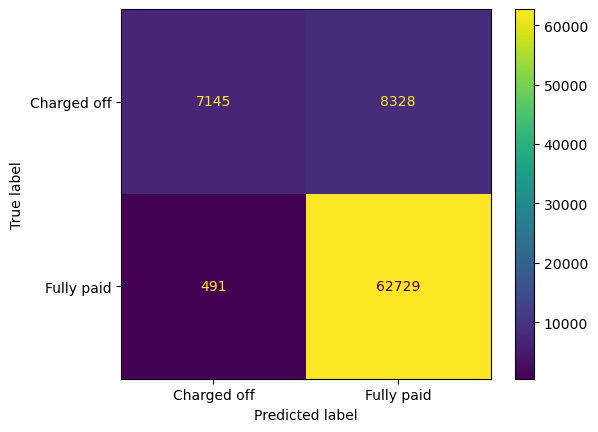

In [258]:
cm = confusion_matrix(y_test, y_pred_test)
ConfusionMatrixDisplay(cm, display_labels=['Charged off', 'Fully paid']).plot()
plt.show()

## **`10. ROC Curve:`** The area under ROC curve is 0.90 which is pretty good.

In [259]:
y_test_pred_prob = model.predict_proba(X_test_std)[:, 1]

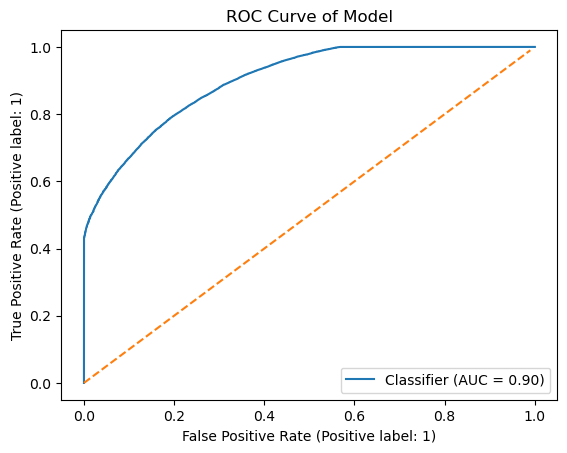

In [260]:
RocCurveDisplay.from_predictions(y_test, y_test_pred_prob)
plt.plot(np.arange(0, 1, 0.01), np.arange(0, 1, 0.01), '--')
plt.title('ROC Curve of Model')
plt.show()

## **`11. Precision Recall Curve:`** The area under Precision Recall curve is 0.97 which is pretty good.

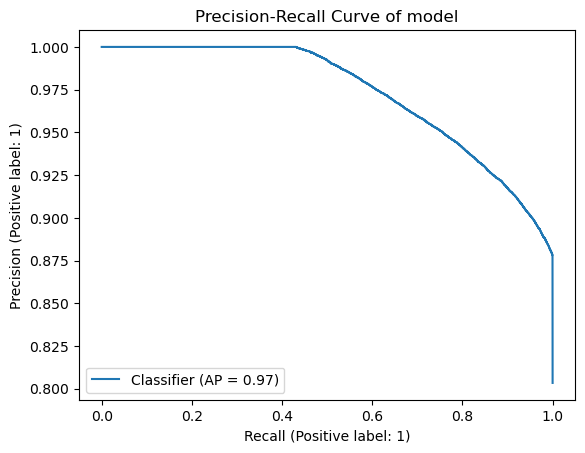

In [261]:
PrecisionRecallDisplay.from_predictions(y_test, y_test_pred_prob)
plt.title('Precision-Recall Curve of model')
plt.show()

***

# **`Tradeoff Questions:`**

### **`1. How can we make sure that our model can detect real defaulters and there are less false positives? This is important as we can lose out on an opportunity to finance more individuals and earn interest on it.`**

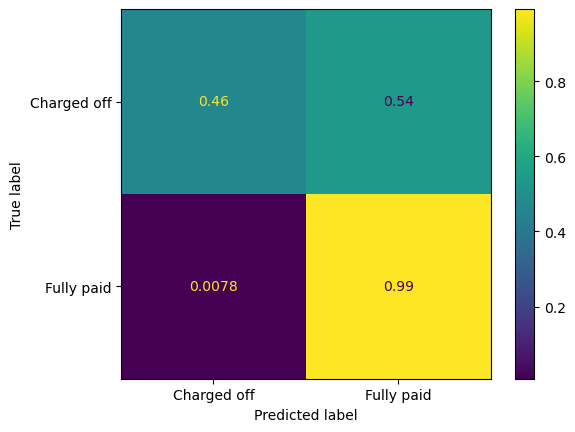

In [262]:
cm = confusion_matrix(y_test, y_pred_test, normalize='true')
ConfusionMatrixDisplay(cm, display_labels=['Charged off', 'Fully paid']).plot()
plt.show()

#### As we can that the recall on `'Full paid'` class is very high i.e over 99% which means that out of all the good non-defaulter customers, 99% of them are being correctly classified which inturn means that we will be disbursing loans to majority of people in good class. But at the same time, we can see that recall of negative class i.e `'Charged Off'` is only 47% which means that our model is labelling 53% of the bad customers (i.e. defaulters) as good customers which can increase the NPA. This is due to the class imbalance in the data. We can improve our model our model so that it classifies correctly more on the bad customer class by introducing `class_weight` in the model to take care of the imbalance.

In [263]:
balanced_model = LogisticRegression(class_weight = 'balanced')

In [264]:
balanced_model.fit(X_train_std, y_train)

LogisticRegression(class_weight='balanced')

In [265]:
y_test_pred_bal = balanced_model.predict(X_test_std)

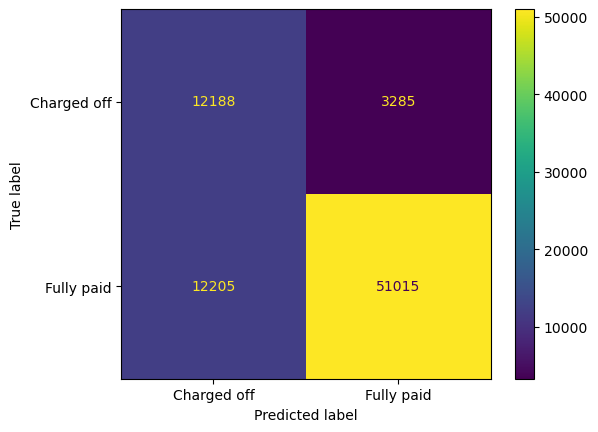

In [274]:
cm_bal = confusion_matrix(y_test, y_test_pred_bal)
ConfusionMatrixDisplay(cm_bal, display_labels=['Charged off', 'Fully paid']).plot()
plt.show()

In [267]:
print(classification_report(y_test, y_test_pred_bal))

              precision    recall  f1-score   support

           0       0.50      0.79      0.61     15473
           1       0.94      0.81      0.87     63220

    accuracy                           0.80     78693
   macro avg       0.72      0.80      0.74     78693
weighted avg       0.85      0.80      0.82     78693



### **`2. Since NPA (non-performing asset) is a real problem in this industry, it’s important we play safe and shouldn’t disburse loans to anyone`**

#### `To minimize NPA (non-performing asset), we can decrease the threshold probability above which we classify a customer as defaulter. This way, the model will become more inclusive towards the defaulter class but at the same time, false positives will also increase which means that we'll miss out on few opportunities of disbursing loan to good customers. So, it's a tradeoff at last.`

# **`Questionnaire`**

In [268]:
new_df = pd.read_csv('https://d2beiqkhq929f0.cloudfront.net/public_assets/assets/000/003/549/original/logistic_regression.csv?1651045921')

### **`1. What percentage of customers have fully paid their Loan Amount?`**

### **`~81% of the customers have fully paid their loan.`**

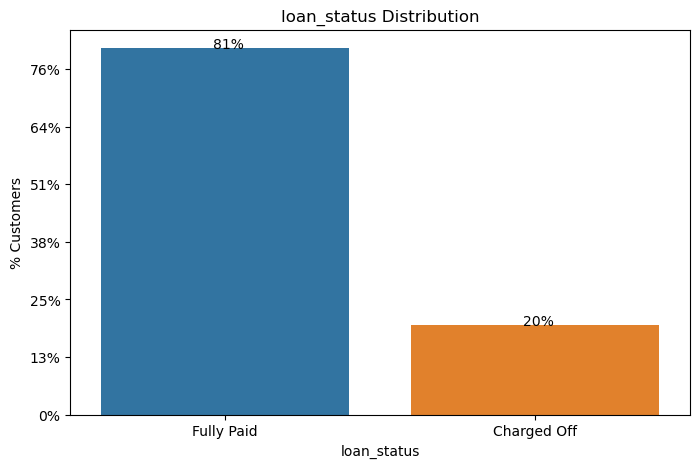

In [269]:
plt.figure(figsize = (8, 5))
ax = sns.countplot(new_df['loan_status'], order = new_df['loan_status'].value_counts().index)
for p in ax.patches:
    ax.annotate('{:.0f}%'.format(round(p.get_height() * 100 / total_size)), (p.get_x()+0.36, p.get_height()+0.01))

plt.title('loan_status Distribution')
plt.yticks(ticks = range(0, 350000, 50000), labels = [str(round(i * 100 / total_size)) + '%' for i in range(0, 350000, 50000)])
plt.ylabel('% Customers')
plt.show()

### **`2. Comment about the correlation between Loan Amount and Installment features.`**

### **`Loan Amount & Installment have a very strong positive linear correlation with Pearson correlation coefficient = 0.95 which means that as the loan amount increases, the installment also increases which is very intuitive also.`**

Text(0.5, 1.0, 'Loan Amount vs Installment \n(Pearson correlation coefficient = 0.95)')

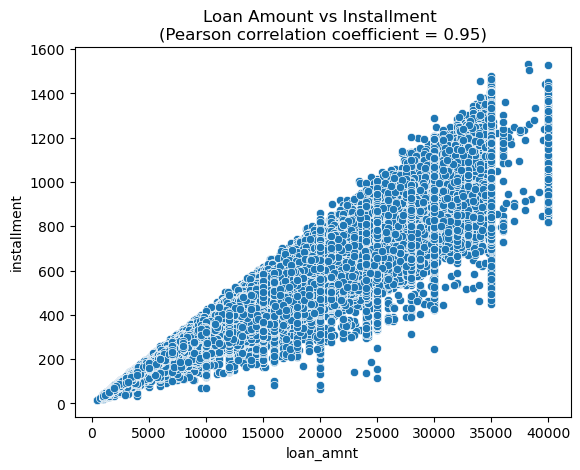

In [270]:
sns.scatterplot(new_df['loan_amnt'], new_df['installment'])
plt.title(f"Loan Amount vs Installment \n(Pearson correlation coefficient = {round(pearsonr(new_df['loan_amnt'], new_df['installment'])[0], 2)})")

### **`3. The majority of people have home ownership as _______`**

### **`The majority of people have home ownership as "mortgage"`**

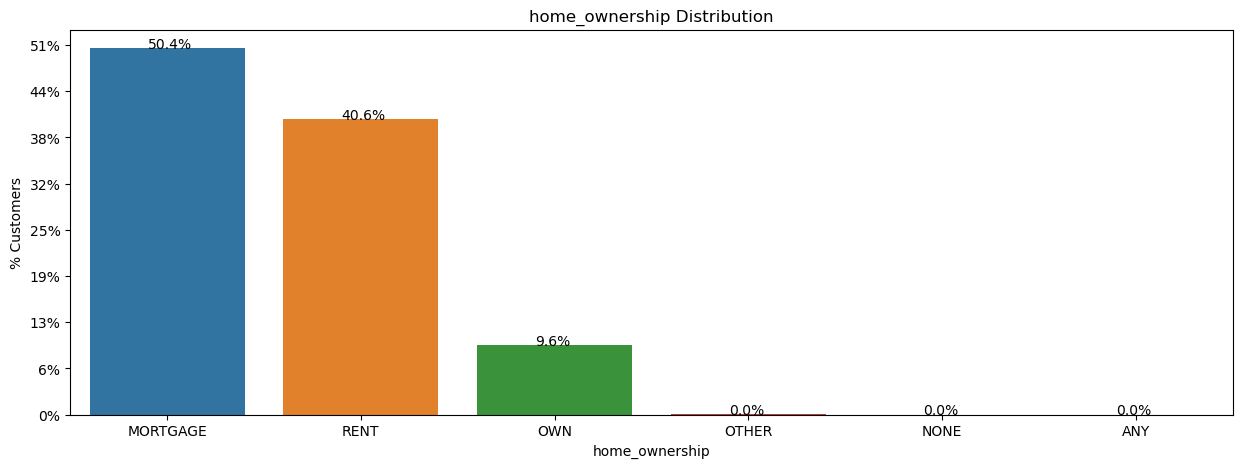

In [271]:
plt.figure(figsize = (15, 5))
ax = sns.countplot(new_df['home_ownership'], order = new_df['home_ownership'].value_counts().index)
for p in ax.patches:
    ax.annotate('{:.1f}%'.format(round(p.get_height() * 100 / total_size, 1)), (p.get_x()+0.3, p.get_height()+0.01))

plt.yticks(ticks = range(0, 225000, 25000), labels = [str(round(i * 100 / total_size)) + '%' for i in range(0, 225000, 25000)])
plt.ylabel('% Customers')
plt.title('home_ownership Distribution')
plt.show()

### **`4. From the Bank's perspective F1-Score is more important because if the Bank Focuses only Recall by decreasing the Threshold bank may be loosing potential customers thereby increasing the opportunity cost.`**

### **`If the threshold is decreased the bank may increase True Positive but on the other hand False Positive may also increase leading to non disbursement of loan to a potential customers. On the hand if the bank only focuses on Precision the bank may at the risk disbursing loan to a risky customers as precsion only focus on a single class rather than on relevant class which is Class 1 in this case. Thereby , the NPA risk is high.`**

### **`5. Will the results be affected by geographical location? (Yes/No)`**

### **`Since zip code is a part top of 10 variables in feature importance, therefore the results are affected by the geographical location.`**

### **`6. Which were the features that heavily affected the outcome?`**

#### `1. Pincode`
#### `2. Income` 
#### `3. revol_bal`
#### `4. int_rate`
#### `5. open_acc`
#### `6. home_ownership__NONE`
#### `6. application_type__JOINT`
#### `8. revol_util`
#### `10. term__36 months`
#### `and many more...`

# **`Questionnaire`**

# **`Actionable Insights & Recommendations`**

### `1. People with more income tend to pay the loan more than that with the low income.`
### `2. More is the total credit revolving balance of a customer, more is the percentage of loan paid.`
### `3. More is the rate of interest, less is the percentage of loan paid.`